In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [5]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS", "CB"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in contact
    def is_swing(description):
        return 1 if description in ["swinging_strike", "swinging_strike_blocked", 
                                "missed_bunt", "swinging_pitchout", 
                                "foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score"] else 0
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df

    def calculate_pitcher_stats(df):
        # Group by pitcher and pitch type
        grouped = df.groupby(['pitcher', 'pitch_type_condensed'])

        # Calculate mean for pfx_x, pfx_z, and velocity
        mean_values = grouped[['pfx_x', 'pfx_z', 'release_speed']].mean()
        mean_values = mean_values.rename(columns={'pfx_x': 'pfx_x_avg',
                                                  'pfx_z': 'pfx_z_avg',
                                                  'release_speed': 'avg_velo'})

        # Calculate max for pfx_x and pfx_z
        max_values = grouped[['pfx_x', 'pfx_z', 'release_speed']].max()
        max_values = max_values.rename(columns={'pfx_x': 'pfx_x_max',
                                                'pfx_z': 'pfx_z_max',
                                                'release_speed': 'max_velo'})

        # Combine mean and max values
        combined_stats = pd.concat([mean_values, max_values], axis=1)

        return combined_stats.reset_index()

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)
    
    def is_foul(description):
        return 1 if description in ["foul_tip", "foul_pitchout", 'foul', 'foul_pitchout'] else 0
    # Call the new function and store the result
    pitcher_stats = calculate_pitcher_stats(df)

    df = df.merge(pitcher_stats, how='left', on=['pitcher', 'pitch_type_condensed'])

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['swing'] = df['description'].apply(is_swing)
    df['foul'] = df['description'].apply(is_foul)
    df['total_movement'] = np.sqrt(df['pfx_x']**2 + df['pfx_z']**2)
    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [6]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('swing == 1')
testing_data_processed = preprocess_data(testing_data, height_df)

In [7]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')

# Fastball Model First

In [8]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'swing',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'swing',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [9]:
train_data = training_features.drop(['foul'], axis=1).copy()
train_label = training_features['foul'].copy()
testing_data = testing_features.drop(['foul'], axis=1).copy()
testing_label = testing_features['foul'].copy()

In [10]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'pfx_x_avg', 'pfx_z_avg', 'avg_velo', 'pfx_x_max', 'pfx_z_max',
       'max_velo', 'height_numeric'],
      dtype='object')

In [11]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'pfx_x_avg', 'pfx_z_avg', 'avg_velo', 'pfx_x_max', 'pfx_z_max',
       'max_velo', 'height_numeric'],
      dtype='object')

In [12]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [13]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [14]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.530354663637511
Log Loss: 0.6887695856230279


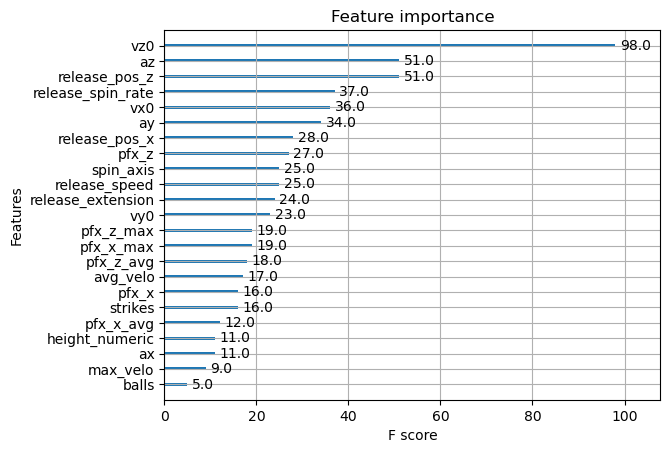

In [15]:
xgb.plot_importance(model)
plt.show()

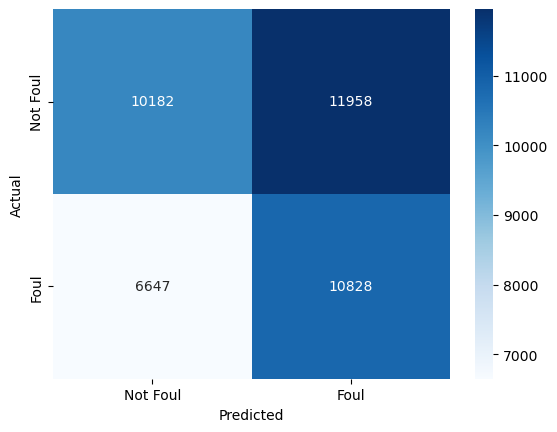

In [16]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [17]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [18]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-13 11:44:06,224] A new study created in memory with name: no-name-97a5aeef-fe67-44d3-98b4-5d5155b0c710


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69255
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69212
[5]	eval-logloss:0.69194
[6]	eval-logloss:0.69179
[7]	eval-logloss:0.69160
[8]	eval-logloss:0.69143
[9]	eval-logloss:0.69126
[10]	eval-logloss:0.69119
[11]	eval-logloss:0.69108
[12]	eval-logloss:0.69090
[13]	eval-logloss:0.69070
[14]	eval-logloss:0.69056
[15]	eval-logloss:0.69038
[16]	eval-logloss:0.69028
[17]	eval-logloss:0.69017
[18]	eval-logloss:0.69011
[19]	eval-logloss:0.69006
[20]	eval-logloss:0.68994
[21]	eval-logloss:0.68988
[22]	eval-logloss:0.68980
[23]	eval-logloss:0.68978
[24]	eval-logloss:0.68973
[25]	eval-logloss:0.68963
[26]	eval-logloss:0.68950
[27]	eval-logloss:0.68945
[28]	eval-logloss:0.68939
[29]	eval-logloss:0.68933
[30]	eval-logloss:0.68931
[31]	eval-logloss:0.68924
[32]	eval-logloss:0.68922
[33]	eval-logloss:0.68921
[34]	eval-logloss:0.68914
[35]	eval-logloss:0.68911
[36]	eval-logloss:0.68908
[37]	eval-logloss:0.68903
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:08,792] Trial 0 finished with value: 0.6883888716371919 and parameters: {'max_depth': 8, 'eta': 0.03200657833241361, 'subsample': 0.6308498949117306, 'colsample_bytree': 0.637865869028913}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.69083
[4]	eval-logloss:0.69066
[5]	eval-logloss:0.69068
[6]	eval-logloss:0.69042
[7]	eval-logloss:0.69059
[8]	eval-logloss:0.69050
[9]	eval-logloss:0.69041
[10]	eval-logloss:0.69039
[11]	eval-logloss:0.69041
[12]	eval-logloss:0.69035
[13]	eval-logloss:0.69027
[14]	eval-logloss:0.69023
[15]	eval-logloss:0.69022
[16]	eval-logloss:0.69041
[17]	eval-logloss:0.69049
[18]	eval-logloss:0.69054
[19]	eval-logloss:0.69059
[20]	eval-logloss:0.69052
[21]	eval-logloss:0.69071
[22]	eval-logloss:0.69086
[23]	eval-logloss:0.69095
[24]	eval-logloss:0.69107
[25]	eval-logloss:0.69090
[26]	eval-logloss:0.69095
[27]	eval-logloss:0.69114
[28]	eval-logloss:0.69129
[29]	eval-logloss:0.69124
[30]	eval-logloss:0.69129
[31]	eval-logloss:0.69130
[32]	eval-logloss:0.69152
[33]	eval-logloss:0.69160
[34]	eval-logloss:0.69163
[35]	eval-logloss:0.69171
[36]	eval-logloss:0.69175
[37]	eval-logloss:0.69177
[38]	eval-logloss:0.69

[I 2023-11-13 11:44:10,505] Trial 1 finished with value: 0.694394933062886 and parameters: {'max_depth': 8, 'eta': 0.1730445512655678, 'subsample': 0.6665287957155239, 'colsample_bytree': 0.5205276326677514}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69087
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.69011
[5]	eval-logloss:0.68996
[6]	eval-logloss:0.68982
[7]	eval-logloss:0.68963
[8]	eval-logloss:0.68954
[9]	eval-logloss:0.68955
[10]	eval-logloss:0.68946
[11]	eval-logloss:0.68944
[12]	eval-logloss:0.68926
[13]	eval-logloss:0.68917
[14]	eval-logloss:0.68917
[15]	eval-logloss:0.68911
[16]	eval-logloss:0.68913
[17]	eval-logloss:0.68917
[18]	eval-logloss:0.68928
[19]	eval-logloss:0.68929
[20]	eval-logloss:0.68920
[21]	eval-logloss:0.68929
[22]	eval-logloss:0.68928
[23]	eval-logloss:0.68930
[24]	eval-logloss:0.68948
[25]	eval-logloss:0.68953
[26]	eval-logloss:0.68946
[27]	eval-logloss:0.68948
[28]	eval-logloss:0.68934
[29]	eval-logloss:0.68942
[30]	eval-logloss:0.68943
[31]	eval-logloss:0.68951
[32]	eval-logloss:0.68963
[33]	eval-logloss:0.68963
[34]	eval-logloss:0.68968
[35]	eval-logloss:0.68966
[36]	eval-logloss:0.68971
[37]	eval-logloss:0.68977
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:12,061] Trial 2 finished with value: 0.6914794122899244 and parameters: {'max_depth': 7, 'eta': 0.15489193066521292, 'subsample': 0.6589244543239788, 'colsample_bytree': 0.790075180023533}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69125
[3]	eval-logloss:0.69077
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.69018
[6]	eval-logloss:0.68995
[7]	eval-logloss:0.68986
[8]	eval-logloss:0.68968
[9]	eval-logloss:0.68955
[10]	eval-logloss:0.68945
[11]	eval-logloss:0.68947
[12]	eval-logloss:0.68934
[13]	eval-logloss:0.68927
[14]	eval-logloss:0.68924
[15]	eval-logloss:0.68922
[16]	eval-logloss:0.68924
[17]	eval-logloss:0.68929
[18]	eval-logloss:0.68927
[19]	eval-logloss:0.68923
[20]	eval-logloss:0.68912
[21]	eval-logloss:0.68911
[22]	eval-logloss:0.68908
[23]	eval-logloss:0.68915
[24]	eval-logloss:0.68920
[25]	eval-logloss:0.68911
[26]	eval-logloss:0.68906
[27]	eval-logloss:0.68909
[28]	eval-logloss:0.68916
[29]	eval-logloss:0.68912
[30]	eval-logloss:0.68918
[31]	eval-logloss:0.68914
[32]	eval-logloss:0.68921
[33]	eval-logloss:0.68915
[34]	eval-logloss:0.68911
[35]	eval-logloss:0.68908
[36]	eval-logloss:0.68905
[37]	eval-logloss:0.68908
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:14,036] Trial 3 finished with value: 0.6906003523888298 and parameters: {'max_depth': 7, 'eta': 0.1252151317474931, 'subsample': 0.7464440393024077, 'colsample_bytree': 0.8395692152509268}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69048
[4]	eval-logloss:0.69012
[5]	eval-logloss:0.69009
[6]	eval-logloss:0.68973
[7]	eval-logloss:0.68983
[8]	eval-logloss:0.68971
[9]	eval-logloss:0.68956
[10]	eval-logloss:0.68960
[11]	eval-logloss:0.68959
[12]	eval-logloss:0.68946
[13]	eval-logloss:0.68935
[14]	eval-logloss:0.68944
[15]	eval-logloss:0.68946
[16]	eval-logloss:0.68951
[17]	eval-logloss:0.68965
[18]	eval-logloss:0.68963
[19]	eval-logloss:0.68967
[20]	eval-logloss:0.68955
[21]	eval-logloss:0.68967
[22]	eval-logloss:0.68986
[23]	eval-logloss:0.68983
[24]	eval-logloss:0.68991
[25]	eval-logloss:0.68987
[26]	eval-logloss:0.68984
[27]	eval-logloss:0.69003
[28]	eval-logloss:0.69013
[29]	eval-logloss:0.69017
[30]	eval-logloss:0.69029
[31]	eval-logloss:0.69035
[32]	eval-logloss:0.69046
[33]	eval-logloss:0.69049
[34]	eval-logloss:0.69053
[35]	eval-logloss:0.69064
[36]	eval-logloss:0.69068
[37]	eval-logloss:0.69087
[38]	eval-logloss:0.69

[I 2023-11-13 11:44:15,702] Trial 4 finished with value: 0.6931600190673656 and parameters: {'max_depth': 8, 'eta': 0.1641392689744885, 'subsample': 0.7416371361169303, 'colsample_bytree': 0.5278036076295525}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69100
[2]	eval-logloss:0.69028
[3]	eval-logloss:0.68995
[4]	eval-logloss:0.68976
[5]	eval-logloss:0.68955
[6]	eval-logloss:0.68956
[7]	eval-logloss:0.68962
[8]	eval-logloss:0.68946
[9]	eval-logloss:0.68920
[10]	eval-logloss:0.68929
[11]	eval-logloss:0.68941
[12]	eval-logloss:0.68945
[13]	eval-logloss:0.68923
[14]	eval-logloss:0.68924
[15]	eval-logloss:0.68924
[16]	eval-logloss:0.68939
[17]	eval-logloss:0.68943
[18]	eval-logloss:0.68949
[19]	eval-logloss:0.68937
[20]	eval-logloss:0.68953
[21]	eval-logloss:0.68964
[22]	eval-logloss:0.68971
[23]	eval-logloss:0.68963
[24]	eval-logloss:0.68981
[25]	eval-logloss:0.68967
[26]	eval-logloss:0.68938
[27]	eval-logloss:0.68947
[28]	eval-logloss:0.68952
[29]	eval-logloss:0.68942
[30]	eval-logloss:0.68945
[31]	eval-logloss:0.68939
[32]	eval-logloss:0.68952
[33]	eval-logloss:0.68957
[34]	eval-logloss:0.68969
[35]	eval-logloss:0.68971
[36]	eval-logloss:0.68970
[37]	eval-logloss:0.68964
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:16,765] Trial 5 finished with value: 0.6900070342040866 and parameters: {'max_depth': 4, 'eta': 0.28624033184701836, 'subsample': 0.709816898557635, 'colsample_bytree': 0.8093918156312019}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69079
[3]	eval-logloss:0.69036
[4]	eval-logloss:0.68996
[5]	eval-logloss:0.68983
[6]	eval-logloss:0.68958
[7]	eval-logloss:0.68944
[8]	eval-logloss:0.68928
[9]	eval-logloss:0.68929
[10]	eval-logloss:0.68932
[11]	eval-logloss:0.68929
[12]	eval-logloss:0.68928
[13]	eval-logloss:0.68920
[14]	eval-logloss:0.68915
[15]	eval-logloss:0.68924
[16]	eval-logloss:0.68925
[17]	eval-logloss:0.68937
[18]	eval-logloss:0.68936
[19]	eval-logloss:0.68938
[20]	eval-logloss:0.68942
[21]	eval-logloss:0.68949
[22]	eval-logloss:0.68954
[23]	eval-logloss:0.68956
[24]	eval-logloss:0.68957
[25]	eval-logloss:0.68957
[26]	eval-logloss:0.68959
[27]	eval-logloss:0.68962
[28]	eval-logloss:0.68958
[29]	eval-logloss:0.68959
[30]	eval-logloss:0.68962
[31]	eval-logloss:0.68976
[32]	eval-logloss:0.68994
[33]	eval-logloss:0.68993
[34]	eval-logloss:0.68996
[35]	eval-logloss:0.69009
[36]	eval-logloss:0.69011
[37]	eval-logloss:0.69019
[38]	eval-logloss:0.69

[I 2023-11-13 11:44:18,512] Trial 6 finished with value: 0.6923354301703787 and parameters: {'max_depth': 8, 'eta': 0.14308933405755178, 'subsample': 0.8484584356577193, 'colsample_bytree': 0.9384809103360156}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69120
[4]	eval-logloss:0.69105
[5]	eval-logloss:0.69092
[6]	eval-logloss:0.69071
[7]	eval-logloss:0.69072
[8]	eval-logloss:0.69047
[9]	eval-logloss:0.69040
[10]	eval-logloss:0.69032
[11]	eval-logloss:0.69033
[12]	eval-logloss:0.69023
[13]	eval-logloss:0.68994
[14]	eval-logloss:0.68986
[15]	eval-logloss:0.68977
[16]	eval-logloss:0.68979
[17]	eval-logloss:0.68975
[18]	eval-logloss:0.68969
[19]	eval-logloss:0.68967
[20]	eval-logloss:0.68962
[21]	eval-logloss:0.68958
[22]	eval-logloss:0.68966
[23]	eval-logloss:0.68960
[24]	eval-logloss:0.68968
[25]	eval-logloss:0.68951
[26]	eval-logloss:0.68933
[27]	eval-logloss:0.68939
[28]	eval-logloss:0.68931
[29]	eval-logloss:0.68919
[30]	eval-logloss:0.68924
[31]	eval-logloss:0.68921
[32]	eval-logloss:0.68926
[33]	eval-logloss:0.68923
[34]	eval-logloss:0.68919
[35]	eval-logloss:0.68915
[36]	eval-logloss:0.68917
[37]	eval-logloss:0.68916
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:19,930] Trial 7 finished with value: 0.6891521545450892 and parameters: {'max_depth': 3, 'eta': 0.16429846739097392, 'subsample': 0.6358762617734321, 'colsample_bytree': 0.5440145214708819}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69145
[2]	eval-logloss:0.69080
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.69013
[5]	eval-logloss:0.69009
[6]	eval-logloss:0.68997
[7]	eval-logloss:0.68992
[8]	eval-logloss:0.68989
[9]	eval-logloss:0.68985
[10]	eval-logloss:0.68984
[11]	eval-logloss:0.68986
[12]	eval-logloss:0.68980
[13]	eval-logloss:0.68970
[14]	eval-logloss:0.68978
[15]	eval-logloss:0.68978
[16]	eval-logloss:0.68973
[17]	eval-logloss:0.68978
[18]	eval-logloss:0.68980
[19]	eval-logloss:0.68985
[20]	eval-logloss:0.68989
[21]	eval-logloss:0.68992
[22]	eval-logloss:0.68999
[23]	eval-logloss:0.69001
[24]	eval-logloss:0.69015
[25]	eval-logloss:0.69004
[26]	eval-logloss:0.69015
[27]	eval-logloss:0.69034
[28]	eval-logloss:0.69032
[29]	eval-logloss:0.69035
[30]	eval-logloss:0.69040
[31]	eval-logloss:0.69038
[32]	eval-logloss:0.69053
[33]	eval-logloss:0.69064
[34]	eval-logloss:0.69063
[35]	eval-logloss:0.69065
[36]	eval-logloss:0.69062
[37]	eval-logloss:0.69073
[38]	eval-logloss:0.69

[I 2023-11-13 11:44:21,361] Trial 8 finished with value: 0.6923173799333419 and parameters: {'max_depth': 7, 'eta': 0.15889756085399923, 'subsample': 0.6958243719863023, 'colsample_bytree': 0.8543454915615516}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69220
[2]	eval-logloss:0.69141
[3]	eval-logloss:0.69099
[4]	eval-logloss:0.69068
[5]	eval-logloss:0.69039
[6]	eval-logloss:0.69012
[7]	eval-logloss:0.68989
[8]	eval-logloss:0.68980
[9]	eval-logloss:0.68967
[10]	eval-logloss:0.68955
[11]	eval-logloss:0.68963
[12]	eval-logloss:0.68963
[13]	eval-logloss:0.68953
[14]	eval-logloss:0.68949
[15]	eval-logloss:0.68943
[16]	eval-logloss:0.68942
[17]	eval-logloss:0.68948
[18]	eval-logloss:0.68952
[19]	eval-logloss:0.68950
[20]	eval-logloss:0.68942
[21]	eval-logloss:0.68942
[22]	eval-logloss:0.68945
[23]	eval-logloss:0.68943
[24]	eval-logloss:0.68941
[25]	eval-logloss:0.68941
[26]	eval-logloss:0.68935
[27]	eval-logloss:0.68940
[28]	eval-logloss:0.68952
[29]	eval-logloss:0.68949
[30]	eval-logloss:0.68941
[31]	eval-logloss:0.68952
[32]	eval-logloss:0.68966
[33]	eval-logloss:0.68973
[34]	eval-logloss:0.68986
[35]	eval-logloss:0.68997
[36]	eval-logloss:0.69004
[37]	eval-logloss:0.69005
[38]	eval-logloss:0.69

[I 2023-11-13 11:44:23,229] Trial 9 finished with value: 0.692267289226227 and parameters: {'max_depth': 8, 'eta': 0.14644627110261985, 'subsample': 0.8973983215131724, 'colsample_bytree': 0.5523648554694112}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69308
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69290
[3]	eval-logloss:0.69279
[4]	eval-logloss:0.69273
[5]	eval-logloss:0.69267
[6]	eval-logloss:0.69259
[7]	eval-logloss:0.69251
[8]	eval-logloss:0.69242
[9]	eval-logloss:0.69234
[10]	eval-logloss:0.69229
[11]	eval-logloss:0.69225
[12]	eval-logloss:0.69217
[13]	eval-logloss:0.69206
[14]	eval-logloss:0.69198
[15]	eval-logloss:0.69189
[16]	eval-logloss:0.69181
[17]	eval-logloss:0.69173
[18]	eval-logloss:0.69169
[19]	eval-logloss:0.69164
[20]	eval-logloss:0.69156
[21]	eval-logloss:0.69149
[22]	eval-logloss:0.69143
[23]	eval-logloss:0.69139
[24]	eval-logloss:0.69135
[25]	eval-logloss:0.69127
[26]	eval-logloss:0.69120
[27]	eval-logloss:0.69116
[28]	eval-logloss:0.69111
[29]	eval-logloss:0.69104
[30]	eval-logloss:0.69100
[31]	eval-logloss:0.69093
[32]	eval-logloss:0.69086
[33]	eval-logloss:0.69083
[34]	eval-logloss:0.69080
[35]	eval-logloss:0.69076
[36]	eval-logloss:0.69073
[37]	eval-logloss:0.69068
[38]	eval-logloss:0.69

[I 2023-11-13 11:44:25,156] Trial 10 finished with value: 0.68924404304307 and parameters: {'max_depth': 5, 'eta': 0.0153363235678699, 'subsample': 0.6001381694659602, 'colsample_bytree': 0.6760917700147417}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69308
[1]	eval-logloss:0.69302
[2]	eval-logloss:0.69292
[3]	eval-logloss:0.69285
[4]	eval-logloss:0.69280
[5]	eval-logloss:0.69275
[6]	eval-logloss:0.69268
[7]	eval-logloss:0.69262
[8]	eval-logloss:0.69256
[9]	eval-logloss:0.69250
[10]	eval-logloss:0.69245
[11]	eval-logloss:0.69240
[12]	eval-logloss:0.69233
[13]	eval-logloss:0.69224
[14]	eval-logloss:0.69218
[15]	eval-logloss:0.69211
[16]	eval-logloss:0.69205
[17]	eval-logloss:0.69200
[18]	eval-logloss:0.69194
[19]	eval-logloss:0.69190
[20]	eval-logloss:0.69185
[21]	eval-logloss:0.69179
[22]	eval-logloss:0.69175
[23]	eval-logloss:0.69172
[24]	eval-logloss:0.69168
[25]	eval-logloss:0.69162
[26]	eval-logloss:0.69156
[27]	eval-logloss:0.69152
[28]	eval-logloss:0.69149
[29]	eval-logloss:0.69143
[30]	eval-logloss:0.69139
[31]	eval-logloss:0.69134
[32]	eval-logloss:0.69131
[33]	eval-logloss:0.69128
[34]	eval-logloss:0.69125
[35]	eval-logloss:0.69122
[36]	eval-logloss:0.69119
[37]	eval-logloss:0.69115
[38]	eval-logloss:0.69

[I 2023-11-13 11:44:26,738] Trial 11 finished with value: 0.6899669947926391 and parameters: {'max_depth': 3, 'eta': 0.015956655557156047, 'subsample': 0.6196959203424725, 'colsample_bytree': 0.6440006608545549}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69222
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69178
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69140
[7]	eval-logloss:0.69132
[8]	eval-logloss:0.69114
[9]	eval-logloss:0.69103
[10]	eval-logloss:0.69095
[11]	eval-logloss:0.69090
[12]	eval-logloss:0.69077
[13]	eval-logloss:0.69057
[14]	eval-logloss:0.69046
[15]	eval-logloss:0.69031
[16]	eval-logloss:0.69025
[17]	eval-logloss:0.69023
[18]	eval-logloss:0.69016
[19]	eval-logloss:0.69013
[20]	eval-logloss:0.69001
[21]	eval-logloss:0.68994
[22]	eval-logloss:0.68993
[23]	eval-logloss:0.68990
[24]	eval-logloss:0.68988
[25]	eval-logloss:0.68976
[26]	eval-logloss:0.68966
[27]	eval-logloss:0.68964
[28]	eval-logloss:0.68957
[29]	eval-logloss:0.68950
[30]	eval-logloss:0.68948
[31]	eval-logloss:0.68946
[32]	eval-logloss:0.68947
[33]	eval-logloss:0.68944
[34]	eval-logloss:0.68941
[35]	eval-logloss:0.68938
[36]	eval-logloss:0.68937
[37]	eval-logloss:0.68933
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:28,192] Trial 12 finished with value: 0.6888811868572374 and parameters: {'max_depth': 3, 'eta': 0.0789069784674805, 'subsample': 0.6360272064860708, 'colsample_bytree': 0.6214822350505469}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69199
[4]	eval-logloss:0.69181
[5]	eval-logloss:0.69165
[6]	eval-logloss:0.69145
[7]	eval-logloss:0.69128
[8]	eval-logloss:0.69111
[9]	eval-logloss:0.69096
[10]	eval-logloss:0.69087
[11]	eval-logloss:0.69082
[12]	eval-logloss:0.69065
[13]	eval-logloss:0.69044
[14]	eval-logloss:0.69032
[15]	eval-logloss:0.69018
[16]	eval-logloss:0.69006
[17]	eval-logloss:0.69000
[18]	eval-logloss:0.68992
[19]	eval-logloss:0.68987
[20]	eval-logloss:0.68973
[21]	eval-logloss:0.68967
[22]	eval-logloss:0.68963
[23]	eval-logloss:0.68960
[24]	eval-logloss:0.68957
[25]	eval-logloss:0.68946
[26]	eval-logloss:0.68934
[27]	eval-logloss:0.68927
[28]	eval-logloss:0.68921
[29]	eval-logloss:0.68911
[30]	eval-logloss:0.68908
[31]	eval-logloss:0.68905
[32]	eval-logloss:0.68900
[33]	eval-logloss:0.68896
[34]	eval-logloss:0.68893
[35]	eval-logloss:0.68890
[36]	eval-logloss:0.68888
[37]	eval-logloss:0.68886
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:30,047] Trial 13 finished with value: 0.6885008929012006 and parameters: {'max_depth': 5, 'eta': 0.056687312851704134, 'subsample': 0.6031244965737907, 'colsample_bytree': 0.6723713747970912}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69223
[3]	eval-logloss:0.69188
[4]	eval-logloss:0.69170
[5]	eval-logloss:0.69156
[6]	eval-logloss:0.69131
[7]	eval-logloss:0.69112
[8]	eval-logloss:0.69094
[9]	eval-logloss:0.69078
[10]	eval-logloss:0.69068
[11]	eval-logloss:0.69064
[12]	eval-logloss:0.69046
[13]	eval-logloss:0.69023
[14]	eval-logloss:0.69012
[15]	eval-logloss:0.68997
[16]	eval-logloss:0.68986
[17]	eval-logloss:0.68981
[18]	eval-logloss:0.68977
[19]	eval-logloss:0.68973
[20]	eval-logloss:0.68961
[21]	eval-logloss:0.68956
[22]	eval-logloss:0.68954
[23]	eval-logloss:0.68949
[24]	eval-logloss:0.68949
[25]	eval-logloss:0.68939
[26]	eval-logloss:0.68926
[27]	eval-logloss:0.68922
[28]	eval-logloss:0.68915
[29]	eval-logloss:0.68908
[30]	eval-logloss:0.68905
[31]	eval-logloss:0.68904
[32]	eval-logloss:0.68900
[33]	eval-logloss:0.68893
[34]	eval-logloss:0.68889
[35]	eval-logloss:0.68887
[36]	eval-logloss:0.68883
[37]	eval-logloss:0.68882
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:31,864] Trial 14 finished with value: 0.6885215550831529 and parameters: {'max_depth': 5, 'eta': 0.06364442341594732, 'subsample': 0.6084507081801661, 'colsample_bytree': 0.7028699856042339}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69182
[4]	eval-logloss:0.69158
[5]	eval-logloss:0.69139
[6]	eval-logloss:0.69117
[7]	eval-logloss:0.69100
[8]	eval-logloss:0.69079
[9]	eval-logloss:0.69060
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69047
[12]	eval-logloss:0.69028
[13]	eval-logloss:0.69010
[14]	eval-logloss:0.68995
[15]	eval-logloss:0.68984
[16]	eval-logloss:0.68970
[17]	eval-logloss:0.68963
[18]	eval-logloss:0.68958
[19]	eval-logloss:0.68957
[20]	eval-logloss:0.68946
[21]	eval-logloss:0.68939
[22]	eval-logloss:0.68926
[23]	eval-logloss:0.68923
[24]	eval-logloss:0.68925
[25]	eval-logloss:0.68917
[26]	eval-logloss:0.68911
[27]	eval-logloss:0.68914
[28]	eval-logloss:0.68911
[29]	eval-logloss:0.68909
[30]	eval-logloss:0.68906
[31]	eval-logloss:0.68897
[32]	eval-logloss:0.68898
[33]	eval-logloss:0.68895
[34]	eval-logloss:0.68891
[35]	eval-logloss:0.68895
[36]	eval-logloss:0.68898
[37]	eval-logloss:0.68896
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:34,961] Trial 15 finished with value: 0.6890959248136911 and parameters: {'max_depth': 9, 'eta': 0.04915151111041961, 'subsample': 0.6694140628982049, 'colsample_bytree': 0.734098930919159}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69137
[4]	eval-logloss:0.69122
[5]	eval-logloss:0.69102
[6]	eval-logloss:0.69082
[7]	eval-logloss:0.69066
[8]	eval-logloss:0.69043
[9]	eval-logloss:0.69024
[10]	eval-logloss:0.69015
[11]	eval-logloss:0.69013
[12]	eval-logloss:0.68992
[13]	eval-logloss:0.68969
[14]	eval-logloss:0.68958
[15]	eval-logloss:0.68944
[16]	eval-logloss:0.68941
[17]	eval-logloss:0.68944
[18]	eval-logloss:0.68937
[19]	eval-logloss:0.68930
[20]	eval-logloss:0.68923
[21]	eval-logloss:0.68921
[22]	eval-logloss:0.68919
[23]	eval-logloss:0.68919
[24]	eval-logloss:0.68921
[25]	eval-logloss:0.68907
[26]	eval-logloss:0.68898
[27]	eval-logloss:0.68898
[28]	eval-logloss:0.68896
[29]	eval-logloss:0.68887
[30]	eval-logloss:0.68887
[31]	eval-logloss:0.68888
[32]	eval-logloss:0.68890
[33]	eval-logloss:0.68888
[34]	eval-logloss:0.68889
[35]	eval-logloss:0.68881
[36]	eval-logloss:0.68879
[37]	eval-logloss:0.68881
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:36,898] Trial 16 finished with value: 0.6893733095173767 and parameters: {'max_depth': 6, 'eta': 0.09392550005429111, 'subsample': 0.604830984127661, 'colsample_bytree': 0.6116188218800906}. Best is trial 0 with value: 0.6883888716371919.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69212
[4]	eval-logloss:0.69195
[5]	eval-logloss:0.69181
[6]	eval-logloss:0.69161
[7]	eval-logloss:0.69142
[8]	eval-logloss:0.69125
[9]	eval-logloss:0.69110
[10]	eval-logloss:0.69101
[11]	eval-logloss:0.69095
[12]	eval-logloss:0.69079
[13]	eval-logloss:0.69065
[14]	eval-logloss:0.69055
[15]	eval-logloss:0.69041
[16]	eval-logloss:0.69028
[17]	eval-logloss:0.69021
[18]	eval-logloss:0.69013
[19]	eval-logloss:0.69009
[20]	eval-logloss:0.68999
[21]	eval-logloss:0.68989
[22]	eval-logloss:0.68981
[23]	eval-logloss:0.68977
[24]	eval-logloss:0.68974
[25]	eval-logloss:0.68964
[26]	eval-logloss:0.68954
[27]	eval-logloss:0.68949
[28]	eval-logloss:0.68946
[29]	eval-logloss:0.68940
[30]	eval-logloss:0.68937
[31]	eval-logloss:0.68926
[32]	eval-logloss:0.68923
[33]	eval-logloss:0.68918
[34]	eval-logloss:0.68916
[35]	eval-logloss:0.68914
[36]	eval-logloss:0.68912
[37]	eval-logloss:0.68908
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:38,748] Trial 17 finished with value: 0.6882769109815163 and parameters: {'max_depth': 5, 'eta': 0.04183466124330983, 'subsample': 0.6942733476960493, 'colsample_bytree': 0.745421836457215}. Best is trial 17 with value: 0.6882769109815163.


[0]	eval-logloss:0.69308
[1]	eval-logloss:0.69295
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69262
[5]	eval-logloss:0.69256
[6]	eval-logloss:0.69246
[7]	eval-logloss:0.69237
[8]	eval-logloss:0.69227
[9]	eval-logloss:0.69219
[10]	eval-logloss:0.69214
[11]	eval-logloss:0.69209
[12]	eval-logloss:0.69201
[13]	eval-logloss:0.69192
[14]	eval-logloss:0.69184
[15]	eval-logloss:0.69174
[16]	eval-logloss:0.69167
[17]	eval-logloss:0.69159
[18]	eval-logloss:0.69155
[19]	eval-logloss:0.69149
[20]	eval-logloss:0.69142
[21]	eval-logloss:0.69135
[22]	eval-logloss:0.69126
[23]	eval-logloss:0.69122
[24]	eval-logloss:0.69117
[25]	eval-logloss:0.69110
[26]	eval-logloss:0.69103
[27]	eval-logloss:0.69097
[28]	eval-logloss:0.69094
[29]	eval-logloss:0.69087
[30]	eval-logloss:0.69084
[31]	eval-logloss:0.69077
[32]	eval-logloss:0.69071
[33]	eval-logloss:0.69065
[34]	eval-logloss:0.69063
[35]	eval-logloss:0.69060
[36]	eval-logloss:0.69057
[37]	eval-logloss:0.69051
[38]	eval-logloss:0.69

[I 2023-11-13 11:44:40,806] Trial 18 finished with value: 0.6889556073802834 and parameters: {'max_depth': 6, 'eta': 0.01468499197249196, 'subsample': 0.704154167671648, 'colsample_bytree': 0.7462998231739062}. Best is trial 17 with value: 0.6882769109815163.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69222
[3]	eval-logloss:0.69200
[4]	eval-logloss:0.69181
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69141
[7]	eval-logloss:0.69125
[8]	eval-logloss:0.69109
[9]	eval-logloss:0.69090
[10]	eval-logloss:0.69079
[11]	eval-logloss:0.69067
[12]	eval-logloss:0.69048
[13]	eval-logloss:0.69029
[14]	eval-logloss:0.69016
[15]	eval-logloss:0.68999
[16]	eval-logloss:0.68991
[17]	eval-logloss:0.68981
[18]	eval-logloss:0.68973
[19]	eval-logloss:0.68963
[20]	eval-logloss:0.68951
[21]	eval-logloss:0.68942
[22]	eval-logloss:0.68933
[23]	eval-logloss:0.68931
[24]	eval-logloss:0.68927
[25]	eval-logloss:0.68915
[26]	eval-logloss:0.68907
[27]	eval-logloss:0.68903
[28]	eval-logloss:0.68902
[29]	eval-logloss:0.68898
[30]	eval-logloss:0.68895
[31]	eval-logloss:0.68890
[32]	eval-logloss:0.68887
[33]	eval-logloss:0.68879
[34]	eval-logloss:0.68875
[35]	eval-logloss:0.68876
[36]	eval-logloss:0.68873
[37]	eval-logloss:0.68869
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:43,869] Trial 19 finished with value: 0.6884871216453384 and parameters: {'max_depth': 9, 'eta': 0.03767403509418858, 'subsample': 0.7891426276768274, 'colsample_bytree': 0.7232353647253691}. Best is trial 17 with value: 0.6882769109815163.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69245
[2]	eval-logloss:0.69201
[3]	eval-logloss:0.69162
[4]	eval-logloss:0.69142
[5]	eval-logloss:0.69126
[6]	eval-logloss:0.69103
[7]	eval-logloss:0.69090
[8]	eval-logloss:0.69071
[9]	eval-logloss:0.69058
[10]	eval-logloss:0.69049
[11]	eval-logloss:0.69041
[12]	eval-logloss:0.69021
[13]	eval-logloss:0.69005
[14]	eval-logloss:0.68994
[15]	eval-logloss:0.68980
[16]	eval-logloss:0.68977
[17]	eval-logloss:0.68977
[18]	eval-logloss:0.68973
[19]	eval-logloss:0.68974
[20]	eval-logloss:0.68957
[21]	eval-logloss:0.68953
[22]	eval-logloss:0.68952
[23]	eval-logloss:0.68948
[24]	eval-logloss:0.68947
[25]	eval-logloss:0.68935
[26]	eval-logloss:0.68924
[27]	eval-logloss:0.68926
[28]	eval-logloss:0.68925
[29]	eval-logloss:0.68913
[30]	eval-logloss:0.68910
[31]	eval-logloss:0.68906
[32]	eval-logloss:0.68911
[33]	eval-logloss:0.68909
[34]	eval-logloss:0.68905
[35]	eval-logloss:0.68903
[36]	eval-logloss:0.68902
[37]	eval-logloss:0.68899
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:45,579] Trial 20 finished with value: 0.6888155541441089 and parameters: {'max_depth': 4, 'eta': 0.08985668913098042, 'subsample': 0.653214945637336, 'colsample_bytree': 0.5952952951327615}. Best is trial 17 with value: 0.6882769109815163.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69196
[4]	eval-logloss:0.69180
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69139
[7]	eval-logloss:0.69125
[8]	eval-logloss:0.69105
[9]	eval-logloss:0.69081
[10]	eval-logloss:0.69069
[11]	eval-logloss:0.69059
[12]	eval-logloss:0.69036
[13]	eval-logloss:0.69019
[14]	eval-logloss:0.69007
[15]	eval-logloss:0.68992
[16]	eval-logloss:0.68977
[17]	eval-logloss:0.68963
[18]	eval-logloss:0.68954
[19]	eval-logloss:0.68944
[20]	eval-logloss:0.68937
[21]	eval-logloss:0.68928
[22]	eval-logloss:0.68920
[23]	eval-logloss:0.68919
[24]	eval-logloss:0.68914
[25]	eval-logloss:0.68901
[26]	eval-logloss:0.68893
[27]	eval-logloss:0.68890
[28]	eval-logloss:0.68888
[29]	eval-logloss:0.68881
[30]	eval-logloss:0.68875
[31]	eval-logloss:0.68868
[32]	eval-logloss:0.68863
[33]	eval-logloss:0.68856
[34]	eval-logloss:0.68852
[35]	eval-logloss:0.68850
[36]	eval-logloss:0.68849
[37]	eval-logloss:0.68848
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:48,740] Trial 21 finished with value: 0.6882280413424202 and parameters: {'max_depth': 9, 'eta': 0.036486088675393595, 'subsample': 0.7863476864256085, 'colsample_bytree': 0.7217409423634011}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69225
[4]	eval-logloss:0.69208
[5]	eval-logloss:0.69193
[6]	eval-logloss:0.69172
[7]	eval-logloss:0.69154
[8]	eval-logloss:0.69137
[9]	eval-logloss:0.69115
[10]	eval-logloss:0.69104
[11]	eval-logloss:0.69097
[12]	eval-logloss:0.69082
[13]	eval-logloss:0.69065
[14]	eval-logloss:0.69049
[15]	eval-logloss:0.69030
[16]	eval-logloss:0.69015
[17]	eval-logloss:0.69003
[18]	eval-logloss:0.68997
[19]	eval-logloss:0.68989
[20]	eval-logloss:0.68977
[21]	eval-logloss:0.68967
[22]	eval-logloss:0.68956
[23]	eval-logloss:0.68955
[24]	eval-logloss:0.68950
[25]	eval-logloss:0.68944
[26]	eval-logloss:0.68933
[27]	eval-logloss:0.68928
[28]	eval-logloss:0.68922
[29]	eval-logloss:0.68918
[30]	eval-logloss:0.68915
[31]	eval-logloss:0.68908
[32]	eval-logloss:0.68905
[33]	eval-logloss:0.68899
[34]	eval-logloss:0.68896
[35]	eval-logloss:0.68894
[36]	eval-logloss:0.68891
[37]	eval-logloss:0.68884
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:52,535] Trial 22 finished with value: 0.6884536006586967 and parameters: {'max_depth': 9, 'eta': 0.033088149730352776, 'subsample': 0.8076183011686955, 'colsample_bytree': 0.6901674239913813}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69197
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69141
[7]	eval-logloss:0.69120
[8]	eval-logloss:0.69100
[9]	eval-logloss:0.69078
[10]	eval-logloss:0.69070
[11]	eval-logloss:0.69055
[12]	eval-logloss:0.69037
[13]	eval-logloss:0.69022
[14]	eval-logloss:0.69005
[15]	eval-logloss:0.68988
[16]	eval-logloss:0.68977
[17]	eval-logloss:0.68969
[18]	eval-logloss:0.68967
[19]	eval-logloss:0.68957
[20]	eval-logloss:0.68947
[21]	eval-logloss:0.68939
[22]	eval-logloss:0.68925
[23]	eval-logloss:0.68921
[24]	eval-logloss:0.68919
[25]	eval-logloss:0.68905
[26]	eval-logloss:0.68895
[27]	eval-logloss:0.68889
[28]	eval-logloss:0.68883
[29]	eval-logloss:0.68877
[30]	eval-logloss:0.68872
[31]	eval-logloss:0.68861
[32]	eval-logloss:0.68858
[33]	eval-logloss:0.68854
[34]	eval-logloss:0.68852
[35]	eval-logloss:0.68848
[36]	eval-logloss:0.68848
[37]	eval-logloss:0.68847
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:55,911] Trial 23 finished with value: 0.6885391879005748 and parameters: {'max_depth': 9, 'eta': 0.04187713752111837, 'subsample': 0.7240877619708349, 'colsample_bytree': 0.7783569118908208}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69200
[3]	eval-logloss:0.69152
[4]	eval-logloss:0.69130
[5]	eval-logloss:0.69109
[6]	eval-logloss:0.69078
[7]	eval-logloss:0.69051
[8]	eval-logloss:0.69029
[9]	eval-logloss:0.69004
[10]	eval-logloss:0.68994
[11]	eval-logloss:0.68987
[12]	eval-logloss:0.68966
[13]	eval-logloss:0.68945
[14]	eval-logloss:0.68928
[15]	eval-logloss:0.68916
[16]	eval-logloss:0.68904
[17]	eval-logloss:0.68897
[18]	eval-logloss:0.68897
[19]	eval-logloss:0.68893
[20]	eval-logloss:0.68883
[21]	eval-logloss:0.68876
[22]	eval-logloss:0.68869
[23]	eval-logloss:0.68870
[24]	eval-logloss:0.68870
[25]	eval-logloss:0.68859
[26]	eval-logloss:0.68852
[27]	eval-logloss:0.68846
[28]	eval-logloss:0.68849
[29]	eval-logloss:0.68844
[30]	eval-logloss:0.68840
[31]	eval-logloss:0.68832
[32]	eval-logloss:0.68831
[33]	eval-logloss:0.68832
[34]	eval-logloss:0.68833
[35]	eval-logloss:0.68834
[36]	eval-logloss:0.68834
[37]	eval-logloss:0.68833
[38]	eval-logloss:0.68

[I 2023-11-13 11:44:58,247] Trial 24 finished with value: 0.6882724118328399 and parameters: {'max_depth': 7, 'eta': 0.06906705659637023, 'subsample': 0.7645101615195288, 'colsample_bytree': 0.6623162198486301}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69197
[3]	eval-logloss:0.69161
[4]	eval-logloss:0.69135
[5]	eval-logloss:0.69114
[6]	eval-logloss:0.69087
[7]	eval-logloss:0.69067
[8]	eval-logloss:0.69045
[9]	eval-logloss:0.69025
[10]	eval-logloss:0.69015
[11]	eval-logloss:0.69007
[12]	eval-logloss:0.68987
[13]	eval-logloss:0.68969
[14]	eval-logloss:0.68958
[15]	eval-logloss:0.68944
[16]	eval-logloss:0.68938
[17]	eval-logloss:0.68932
[18]	eval-logloss:0.68924
[19]	eval-logloss:0.68916
[20]	eval-logloss:0.68908
[21]	eval-logloss:0.68901
[22]	eval-logloss:0.68890
[23]	eval-logloss:0.68892
[24]	eval-logloss:0.68893
[25]	eval-logloss:0.68887
[26]	eval-logloss:0.68879
[27]	eval-logloss:0.68874
[28]	eval-logloss:0.68870
[29]	eval-logloss:0.68866
[30]	eval-logloss:0.68865
[31]	eval-logloss:0.68860
[32]	eval-logloss:0.68857
[33]	eval-logloss:0.68850
[34]	eval-logloss:0.68847
[35]	eval-logloss:0.68849
[36]	eval-logloss:0.68846
[37]	eval-logloss:0.68845
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:00,567] Trial 25 finished with value: 0.6883621366200664 and parameters: {'max_depth': 6, 'eta': 0.06318607727238593, 'subsample': 0.7591578284544381, 'colsample_bytree': 0.7528685899746406}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69187
[3]	eval-logloss:0.69146
[4]	eval-logloss:0.69127
[5]	eval-logloss:0.69105
[6]	eval-logloss:0.69077
[7]	eval-logloss:0.69062
[8]	eval-logloss:0.69039
[9]	eval-logloss:0.69020
[10]	eval-logloss:0.69012
[11]	eval-logloss:0.69010
[12]	eval-logloss:0.68998
[13]	eval-logloss:0.68980
[14]	eval-logloss:0.68975
[15]	eval-logloss:0.68959
[16]	eval-logloss:0.68947
[17]	eval-logloss:0.68939
[18]	eval-logloss:0.68931
[19]	eval-logloss:0.68926
[20]	eval-logloss:0.68919
[21]	eval-logloss:0.68915
[22]	eval-logloss:0.68911
[23]	eval-logloss:0.68910
[24]	eval-logloss:0.68918
[25]	eval-logloss:0.68908
[26]	eval-logloss:0.68903
[27]	eval-logloss:0.68900
[28]	eval-logloss:0.68899
[29]	eval-logloss:0.68887
[30]	eval-logloss:0.68878
[31]	eval-logloss:0.68873
[32]	eval-logloss:0.68873
[33]	eval-logloss:0.68869
[34]	eval-logloss:0.68866
[35]	eval-logloss:0.68867
[36]	eval-logloss:0.68868
[37]	eval-logloss:0.68863
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:02,551] Trial 26 finished with value: 0.6883126691640347 and parameters: {'max_depth': 4, 'eta': 0.10373775326009477, 'subsample': 0.7675604272654234, 'colsample_bytree': 0.7020719830462244}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69151
[4]	eval-logloss:0.69132
[5]	eval-logloss:0.69114
[6]	eval-logloss:0.69081
[7]	eval-logloss:0.69058
[8]	eval-logloss:0.69038
[9]	eval-logloss:0.69006
[10]	eval-logloss:0.68999
[11]	eval-logloss:0.68994
[12]	eval-logloss:0.68976
[13]	eval-logloss:0.68954
[14]	eval-logloss:0.68943
[15]	eval-logloss:0.68929
[16]	eval-logloss:0.68911
[17]	eval-logloss:0.68906
[18]	eval-logloss:0.68898
[19]	eval-logloss:0.68892
[20]	eval-logloss:0.68880
[21]	eval-logloss:0.68875
[22]	eval-logloss:0.68867
[23]	eval-logloss:0.68865
[24]	eval-logloss:0.68861
[25]	eval-logloss:0.68855
[26]	eval-logloss:0.68849
[27]	eval-logloss:0.68844
[28]	eval-logloss:0.68845
[29]	eval-logloss:0.68841
[30]	eval-logloss:0.68840
[31]	eval-logloss:0.68838
[32]	eval-logloss:0.68838
[33]	eval-logloss:0.68837
[34]	eval-logloss:0.68833
[35]	eval-logloss:0.68834
[36]	eval-logloss:0.68835
[37]	eval-logloss:0.68835
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:05,286] Trial 27 finished with value: 0.688464390721612 and parameters: {'max_depth': 7, 'eta': 0.06925396856968567, 'subsample': 0.7882270396029195, 'colsample_bytree': 0.6683183168877729}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69212
[3]	eval-logloss:0.69181
[4]	eval-logloss:0.69158
[5]	eval-logloss:0.69145
[6]	eval-logloss:0.69119
[7]	eval-logloss:0.69103
[8]	eval-logloss:0.69084
[9]	eval-logloss:0.69063
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69051
[12]	eval-logloss:0.69032
[13]	eval-logloss:0.69011
[14]	eval-logloss:0.69004
[15]	eval-logloss:0.68990
[16]	eval-logloss:0.68977
[17]	eval-logloss:0.68967
[18]	eval-logloss:0.68962
[19]	eval-logloss:0.68955
[20]	eval-logloss:0.68953
[21]	eval-logloss:0.68946
[22]	eval-logloss:0.68935
[23]	eval-logloss:0.68931
[24]	eval-logloss:0.68932
[25]	eval-logloss:0.68923
[26]	eval-logloss:0.68916
[27]	eval-logloss:0.68909
[28]	eval-logloss:0.68907
[29]	eval-logloss:0.68900
[30]	eval-logloss:0.68896
[31]	eval-logloss:0.68889
[32]	eval-logloss:0.68890
[33]	eval-logloss:0.68891
[34]	eval-logloss:0.68888
[35]	eval-logloss:0.68890
[36]	eval-logloss:0.68888
[37]	eval-logloss:0.68885
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:07,638] Trial 28 finished with value: 0.6885365896566786 and parameters: {'max_depth': 5, 'eta': 0.07070710306124806, 'subsample': 0.7297324389878957, 'colsample_bytree': 0.5788889073582009}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69225
[4]	eval-logloss:0.69209
[5]	eval-logloss:0.69199
[6]	eval-logloss:0.69177
[7]	eval-logloss:0.69161
[8]	eval-logloss:0.69142
[9]	eval-logloss:0.69127
[10]	eval-logloss:0.69119
[11]	eval-logloss:0.69113
[12]	eval-logloss:0.69095
[13]	eval-logloss:0.69077
[14]	eval-logloss:0.69065
[15]	eval-logloss:0.69050
[16]	eval-logloss:0.69037
[17]	eval-logloss:0.69027
[18]	eval-logloss:0.69022
[19]	eval-logloss:0.69018
[20]	eval-logloss:0.69009
[21]	eval-logloss:0.68999
[22]	eval-logloss:0.68988
[23]	eval-logloss:0.68983
[24]	eval-logloss:0.68977
[25]	eval-logloss:0.68964
[26]	eval-logloss:0.68958
[27]	eval-logloss:0.68951
[28]	eval-logloss:0.68946
[29]	eval-logloss:0.68940
[30]	eval-logloss:0.68932
[31]	eval-logloss:0.68920
[32]	eval-logloss:0.68921
[33]	eval-logloss:0.68918
[34]	eval-logloss:0.68912
[35]	eval-logloss:0.68911
[36]	eval-logloss:0.68909
[37]	eval-logloss:0.68904
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:10,788] Trial 29 finished with value: 0.6884225844609974 and parameters: {'max_depth': 7, 'eta': 0.03822382834507434, 'subsample': 0.6919396127492848, 'colsample_bytree': 0.647387467650202}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69309
[1]	eval-logloss:0.69304
[2]	eval-logloss:0.69296
[3]	eval-logloss:0.69287
[4]	eval-logloss:0.69282
[5]	eval-logloss:0.69278
[6]	eval-logloss:0.69271
[7]	eval-logloss:0.69264
[8]	eval-logloss:0.69256
[9]	eval-logloss:0.69249
[10]	eval-logloss:0.69244
[11]	eval-logloss:0.69240
[12]	eval-logloss:0.69233
[13]	eval-logloss:0.69225
[14]	eval-logloss:0.69219
[15]	eval-logloss:0.69212
[16]	eval-logloss:0.69205
[17]	eval-logloss:0.69198
[18]	eval-logloss:0.69194
[19]	eval-logloss:0.69190
[20]	eval-logloss:0.69184
[21]	eval-logloss:0.69177
[22]	eval-logloss:0.69172
[23]	eval-logloss:0.69168
[24]	eval-logloss:0.69163
[25]	eval-logloss:0.69157
[26]	eval-logloss:0.69151
[27]	eval-logloss:0.69145
[28]	eval-logloss:0.69142
[29]	eval-logloss:0.69137
[30]	eval-logloss:0.69133
[31]	eval-logloss:0.69127
[32]	eval-logloss:0.69125
[33]	eval-logloss:0.69122
[34]	eval-logloss:0.69119
[35]	eval-logloss:0.69117
[36]	eval-logloss:0.69114
[37]	eval-logloss:0.69108
[38]	eval-logloss:0.69

[I 2023-11-13 11:45:13,784] Trial 30 finished with value: 0.6895807968144846 and parameters: {'max_depth': 6, 'eta': 0.010839781738407283, 'subsample': 0.7612036083428603, 'colsample_bytree': 0.6427040960721864}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69213
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69129
[4]	eval-logloss:0.69109
[5]	eval-logloss:0.69090
[6]	eval-logloss:0.69067
[7]	eval-logloss:0.69051
[8]	eval-logloss:0.69036
[9]	eval-logloss:0.69015
[10]	eval-logloss:0.69004
[11]	eval-logloss:0.69002
[12]	eval-logloss:0.68989
[13]	eval-logloss:0.68975
[14]	eval-logloss:0.68970
[15]	eval-logloss:0.68957
[16]	eval-logloss:0.68943
[17]	eval-logloss:0.68937
[18]	eval-logloss:0.68931
[19]	eval-logloss:0.68930
[20]	eval-logloss:0.68924
[21]	eval-logloss:0.68922
[22]	eval-logloss:0.68918
[23]	eval-logloss:0.68918
[24]	eval-logloss:0.68922
[25]	eval-logloss:0.68914
[26]	eval-logloss:0.68911
[27]	eval-logloss:0.68906
[28]	eval-logloss:0.68904
[29]	eval-logloss:0.68899
[30]	eval-logloss:0.68894
[31]	eval-logloss:0.68890
[32]	eval-logloss:0.68890
[33]	eval-logloss:0.68888
[34]	eval-logloss:0.68887
[35]	eval-logloss:0.68889
[36]	eval-logloss:0.68888
[37]	eval-logloss:0.68882
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:15,877] Trial 31 finished with value: 0.6885018789973228 and parameters: {'max_depth': 4, 'eta': 0.10037134463420289, 'subsample': 0.7696475560531021, 'colsample_bytree': 0.709246584895883}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69211
[2]	eval-logloss:0.69155
[3]	eval-logloss:0.69119
[4]	eval-logloss:0.69102
[5]	eval-logloss:0.69082
[6]	eval-logloss:0.69060
[7]	eval-logloss:0.69048
[8]	eval-logloss:0.69027
[9]	eval-logloss:0.69011
[10]	eval-logloss:0.69001
[11]	eval-logloss:0.69001
[12]	eval-logloss:0.68989
[13]	eval-logloss:0.68974
[14]	eval-logloss:0.68971
[15]	eval-logloss:0.68962
[16]	eval-logloss:0.68950
[17]	eval-logloss:0.68942
[18]	eval-logloss:0.68939
[19]	eval-logloss:0.68936
[20]	eval-logloss:0.68928
[21]	eval-logloss:0.68927
[22]	eval-logloss:0.68916
[23]	eval-logloss:0.68911
[24]	eval-logloss:0.68920
[25]	eval-logloss:0.68910
[26]	eval-logloss:0.68907
[27]	eval-logloss:0.68906
[28]	eval-logloss:0.68904
[29]	eval-logloss:0.68897
[30]	eval-logloss:0.68893
[31]	eval-logloss:0.68890
[32]	eval-logloss:0.68891
[33]	eval-logloss:0.68888
[34]	eval-logloss:0.68889
[35]	eval-logloss:0.68889
[36]	eval-logloss:0.68886
[37]	eval-logloss:0.68883
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:18,285] Trial 32 finished with value: 0.6885185960608249 and parameters: {'max_depth': 4, 'eta': 0.1093136684808512, 'subsample': 0.7293960356780768, 'colsample_bytree': 0.712960448498692}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69220
[2]	eval-logloss:0.69177
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69114
[5]	eval-logloss:0.69095
[6]	eval-logloss:0.69071
[7]	eval-logloss:0.69056
[8]	eval-logloss:0.69038
[9]	eval-logloss:0.69018
[10]	eval-logloss:0.69008
[11]	eval-logloss:0.69005
[12]	eval-logloss:0.68992
[13]	eval-logloss:0.68977
[14]	eval-logloss:0.68969
[15]	eval-logloss:0.68956
[16]	eval-logloss:0.68945
[17]	eval-logloss:0.68936
[18]	eval-logloss:0.68931
[19]	eval-logloss:0.68926
[20]	eval-logloss:0.68917
[21]	eval-logloss:0.68909
[22]	eval-logloss:0.68900
[23]	eval-logloss:0.68901
[24]	eval-logloss:0.68900
[25]	eval-logloss:0.68891
[26]	eval-logloss:0.68886
[27]	eval-logloss:0.68882
[28]	eval-logloss:0.68880
[29]	eval-logloss:0.68876
[30]	eval-logloss:0.68874
[31]	eval-logloss:0.68872
[32]	eval-logloss:0.68874
[33]	eval-logloss:0.68871
[34]	eval-logloss:0.68869
[35]	eval-logloss:0.68868
[36]	eval-logloss:0.68866
[37]	eval-logloss:0.68863
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:21,002] Trial 33 finished with value: 0.6885564233142757 and parameters: {'max_depth': 5, 'eta': 0.07906952048149793, 'subsample': 0.7722064644892763, 'colsample_bytree': 0.7708847378964738}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69225
[3]	eval-logloss:0.69200
[4]	eval-logloss:0.69184
[5]	eval-logloss:0.69168
[6]	eval-logloss:0.69148
[7]	eval-logloss:0.69135
[8]	eval-logloss:0.69122
[9]	eval-logloss:0.69102
[10]	eval-logloss:0.69093
[11]	eval-logloss:0.69088
[12]	eval-logloss:0.69072
[13]	eval-logloss:0.69058
[14]	eval-logloss:0.69052
[15]	eval-logloss:0.69038
[16]	eval-logloss:0.69027
[17]	eval-logloss:0.69018
[18]	eval-logloss:0.69012
[19]	eval-logloss:0.69005
[20]	eval-logloss:0.68994
[21]	eval-logloss:0.68985
[22]	eval-logloss:0.68980
[23]	eval-logloss:0.68977
[24]	eval-logloss:0.68972
[25]	eval-logloss:0.68964
[26]	eval-logloss:0.68955
[27]	eval-logloss:0.68951
[28]	eval-logloss:0.68948
[29]	eval-logloss:0.68942
[30]	eval-logloss:0.68939
[31]	eval-logloss:0.68932
[32]	eval-logloss:0.68930
[33]	eval-logloss:0.68924
[34]	eval-logloss:0.68920
[35]	eval-logloss:0.68918
[36]	eval-logloss:0.68915
[37]	eval-logloss:0.68911
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:23,228] Trial 34 finished with value: 0.6885196835233779 and parameters: {'max_depth': 4, 'eta': 0.05364321658964419, 'subsample': 0.7465375721812246, 'colsample_bytree': 0.7393408119438203}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69110
[4]	eval-logloss:0.69087
[5]	eval-logloss:0.69067
[6]	eval-logloss:0.69031
[7]	eval-logloss:0.69012
[8]	eval-logloss:0.68988
[9]	eval-logloss:0.68960
[10]	eval-logloss:0.68954
[11]	eval-logloss:0.68952
[12]	eval-logloss:0.68941
[13]	eval-logloss:0.68929
[14]	eval-logloss:0.68919
[15]	eval-logloss:0.68907
[16]	eval-logloss:0.68891
[17]	eval-logloss:0.68883
[18]	eval-logloss:0.68881
[19]	eval-logloss:0.68876
[20]	eval-logloss:0.68872
[21]	eval-logloss:0.68871
[22]	eval-logloss:0.68864
[23]	eval-logloss:0.68864
[24]	eval-logloss:0.68870
[25]	eval-logloss:0.68872
[26]	eval-logloss:0.68871
[27]	eval-logloss:0.68869
[28]	eval-logloss:0.68862
[29]	eval-logloss:0.68861
[30]	eval-logloss:0.68855
[31]	eval-logloss:0.68857
[32]	eval-logloss:0.68855
[33]	eval-logloss:0.68856
[34]	eval-logloss:0.68859
[35]	eval-logloss:0.68866
[36]	eval-logloss:0.68865
[37]	eval-logloss:0.68866
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:25,230] Trial 35 finished with value: 0.689170687279453 and parameters: {'max_depth': 6, 'eta': 0.11630775951979878, 'subsample': 0.811827635601789, 'colsample_bytree': 0.6826264637991075}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69220
[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69125
[4]	eval-logloss:0.69105
[5]	eval-logloss:0.69091
[6]	eval-logloss:0.69063
[7]	eval-logloss:0.69046
[8]	eval-logloss:0.69029
[9]	eval-logloss:0.69011
[10]	eval-logloss:0.69004
[11]	eval-logloss:0.68995
[12]	eval-logloss:0.68982
[13]	eval-logloss:0.68962
[14]	eval-logloss:0.68954
[15]	eval-logloss:0.68942
[16]	eval-logloss:0.68933
[17]	eval-logloss:0.68932
[18]	eval-logloss:0.68938
[19]	eval-logloss:0.68941
[20]	eval-logloss:0.68928
[21]	eval-logloss:0.68924
[22]	eval-logloss:0.68916
[23]	eval-logloss:0.68917
[24]	eval-logloss:0.68918
[25]	eval-logloss:0.68911
[26]	eval-logloss:0.68906
[27]	eval-logloss:0.68902
[28]	eval-logloss:0.68896
[29]	eval-logloss:0.68893
[30]	eval-logloss:0.68899
[31]	eval-logloss:0.68896
[32]	eval-logloss:0.68900
[33]	eval-logloss:0.68895
[34]	eval-logloss:0.68897
[35]	eval-logloss:0.68901
[36]	eval-logloss:0.68901
[37]	eval-logloss:0.68905
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:28,310] Trial 36 finished with value: 0.6896788251329092 and parameters: {'max_depth': 8, 'eta': 0.08301754557016285, 'subsample': 0.7403137639909216, 'colsample_bytree': 0.7086212042126876}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69131
[3]	eval-logloss:0.69085
[4]	eval-logloss:0.69061
[5]	eval-logloss:0.69037
[6]	eval-logloss:0.69020
[7]	eval-logloss:0.69000
[8]	eval-logloss:0.68973
[9]	eval-logloss:0.68960
[10]	eval-logloss:0.68950
[11]	eval-logloss:0.68952
[12]	eval-logloss:0.68933
[13]	eval-logloss:0.68918
[14]	eval-logloss:0.68915
[15]	eval-logloss:0.68907
[16]	eval-logloss:0.68906
[17]	eval-logloss:0.68908
[18]	eval-logloss:0.68904
[19]	eval-logloss:0.68895
[20]	eval-logloss:0.68888
[21]	eval-logloss:0.68883
[22]	eval-logloss:0.68877
[23]	eval-logloss:0.68875
[24]	eval-logloss:0.68880
[25]	eval-logloss:0.68870
[26]	eval-logloss:0.68868
[27]	eval-logloss:0.68873
[28]	eval-logloss:0.68871
[29]	eval-logloss:0.68865
[30]	eval-logloss:0.68863
[31]	eval-logloss:0.68865
[32]	eval-logloss:0.68867
[33]	eval-logloss:0.68863
[34]	eval-logloss:0.68861
[35]	eval-logloss:0.68865
[36]	eval-logloss:0.68861
[37]	eval-logloss:0.68863
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:30,604] Trial 37 finished with value: 0.6890723995281435 and parameters: {'max_depth': 5, 'eta': 0.12637237956951544, 'subsample': 0.6757183102068363, 'colsample_bytree': 0.8128746003091395}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69260
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69209
[9]	eval-logloss:0.69197
[10]	eval-logloss:0.69189
[11]	eval-logloss:0.69183
[12]	eval-logloss:0.69172
[13]	eval-logloss:0.69159
[14]	eval-logloss:0.69153
[15]	eval-logloss:0.69141
[16]	eval-logloss:0.69130
[17]	eval-logloss:0.69119
[18]	eval-logloss:0.69113
[19]	eval-logloss:0.69108
[20]	eval-logloss:0.69103
[21]	eval-logloss:0.69094
[22]	eval-logloss:0.69088
[23]	eval-logloss:0.69084
[24]	eval-logloss:0.69077
[25]	eval-logloss:0.69069
[26]	eval-logloss:0.69064
[27]	eval-logloss:0.69058
[28]	eval-logloss:0.69054
[29]	eval-logloss:0.69047
[30]	eval-logloss:0.69042
[31]	eval-logloss:0.69035
[32]	eval-logloss:0.69033
[33]	eval-logloss:0.69031
[34]	eval-logloss:0.69028
[35]	eval-logloss:0.69027
[36]	eval-logloss:0.69023
[37]	eval-logloss:0.69018
[38]	eval-logloss:0.69

[I 2023-11-13 11:45:32,982] Trial 38 finished with value: 0.6892105952620876 and parameters: {'max_depth': 4, 'eta': 0.029604575630860674, 'subsample': 0.723199458244915, 'colsample_bytree': 0.5055531714986874}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69208
[3]	eval-logloss:0.69179
[4]	eval-logloss:0.69155
[5]	eval-logloss:0.69135
[6]	eval-logloss:0.69113
[7]	eval-logloss:0.69095
[8]	eval-logloss:0.69072
[9]	eval-logloss:0.69054
[10]	eval-logloss:0.69049
[11]	eval-logloss:0.69040
[12]	eval-logloss:0.69021
[13]	eval-logloss:0.69002
[14]	eval-logloss:0.68988
[15]	eval-logloss:0.68969
[16]	eval-logloss:0.68958
[17]	eval-logloss:0.68952
[18]	eval-logloss:0.68944
[19]	eval-logloss:0.68936
[20]	eval-logloss:0.68923
[21]	eval-logloss:0.68915
[22]	eval-logloss:0.68905
[23]	eval-logloss:0.68902
[24]	eval-logloss:0.68897
[25]	eval-logloss:0.68885
[26]	eval-logloss:0.68879
[27]	eval-logloss:0.68877
[28]	eval-logloss:0.68874
[29]	eval-logloss:0.68868
[30]	eval-logloss:0.68864
[31]	eval-logloss:0.68858
[32]	eval-logloss:0.68857
[33]	eval-logloss:0.68856
[34]	eval-logloss:0.68852
[35]	eval-logloss:0.68851
[36]	eval-logloss:0.68848
[37]	eval-logloss:0.68849
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:36,756] Trial 39 finished with value: 0.6884678326480353 and parameters: {'max_depth': 8, 'eta': 0.04992368883148149, 'subsample': 0.7485824171663942, 'colsample_bytree': 0.7523224311733765}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69233
[2]	eval-logloss:0.69170
[3]	eval-logloss:0.69117
[4]	eval-logloss:0.69095
[5]	eval-logloss:0.69079
[6]	eval-logloss:0.69051
[7]	eval-logloss:0.69028
[8]	eval-logloss:0.68999
[9]	eval-logloss:0.68983
[10]	eval-logloss:0.68984
[11]	eval-logloss:0.68980
[12]	eval-logloss:0.68960
[13]	eval-logloss:0.68941
[14]	eval-logloss:0.68937
[15]	eval-logloss:0.68920
[16]	eval-logloss:0.68916
[17]	eval-logloss:0.68918
[18]	eval-logloss:0.68921
[19]	eval-logloss:0.68920
[20]	eval-logloss:0.68916
[21]	eval-logloss:0.68915
[22]	eval-logloss:0.68911
[23]	eval-logloss:0.68907
[24]	eval-logloss:0.68912
[25]	eval-logloss:0.68904
[26]	eval-logloss:0.68911
[27]	eval-logloss:0.68907
[28]	eval-logloss:0.68900
[29]	eval-logloss:0.68897
[30]	eval-logloss:0.68896
[31]	eval-logloss:0.68889
[32]	eval-logloss:0.68893
[33]	eval-logloss:0.68895
[34]	eval-logloss:0.68894
[35]	eval-logloss:0.68892
[36]	eval-logloss:0.68894
[37]	eval-logloss:0.68894
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:39,771] Trial 40 finished with value: 0.6897090799207912 and parameters: {'max_depth': 7, 'eta': 0.09569956615974037, 'subsample': 0.6869136967971783, 'colsample_bytree': 0.6552792743866787}. Best is trial 21 with value: 0.6882280413424202.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69196
[3]	eval-logloss:0.69161
[4]	eval-logloss:0.69133
[5]	eval-logloss:0.69115
[6]	eval-logloss:0.69089
[7]	eval-logloss:0.69069
[8]	eval-logloss:0.69045
[9]	eval-logloss:0.69024
[10]	eval-logloss:0.69017
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68990
[13]	eval-logloss:0.68971
[14]	eval-logloss:0.68960
[15]	eval-logloss:0.68948
[16]	eval-logloss:0.68937
[17]	eval-logloss:0.68930
[18]	eval-logloss:0.68925
[19]	eval-logloss:0.68917
[20]	eval-logloss:0.68909
[21]	eval-logloss:0.68902
[22]	eval-logloss:0.68892
[23]	eval-logloss:0.68892
[24]	eval-logloss:0.68891
[25]	eval-logloss:0.68882
[26]	eval-logloss:0.68873
[27]	eval-logloss:0.68868
[28]	eval-logloss:0.68863
[29]	eval-logloss:0.68860
[30]	eval-logloss:0.68857
[31]	eval-logloss:0.68853
[32]	eval-logloss:0.68850
[33]	eval-logloss:0.68850
[34]	eval-logloss:0.68848
[35]	eval-logloss:0.68847
[36]	eval-logloss:0.68843
[37]	eval-logloss:0.68842
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:42,823] Trial 41 finished with value: 0.688150509273984 and parameters: {'max_depth': 6, 'eta': 0.0633465942884034, 'subsample': 0.7611236570495371, 'colsample_bytree': 0.7652900644981901}. Best is trial 41 with value: 0.688150509273984.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69174
[3]	eval-logloss:0.69136
[4]	eval-logloss:0.69111
[5]	eval-logloss:0.69091
[6]	eval-logloss:0.69070
[7]	eval-logloss:0.69045
[8]	eval-logloss:0.69029
[9]	eval-logloss:0.69011
[10]	eval-logloss:0.69002
[11]	eval-logloss:0.68992
[12]	eval-logloss:0.68977
[13]	eval-logloss:0.68962
[14]	eval-logloss:0.68956
[15]	eval-logloss:0.68940
[16]	eval-logloss:0.68928
[17]	eval-logloss:0.68919
[18]	eval-logloss:0.68914
[19]	eval-logloss:0.68913
[20]	eval-logloss:0.68909
[21]	eval-logloss:0.68906
[22]	eval-logloss:0.68901
[23]	eval-logloss:0.68897
[24]	eval-logloss:0.68900
[25]	eval-logloss:0.68893
[26]	eval-logloss:0.68887
[27]	eval-logloss:0.68881
[28]	eval-logloss:0.68875
[29]	eval-logloss:0.68868
[30]	eval-logloss:0.68867
[31]	eval-logloss:0.68865
[32]	eval-logloss:0.68862
[33]	eval-logloss:0.68863
[34]	eval-logloss:0.68865
[35]	eval-logloss:0.68866
[36]	eval-logloss:0.68866
[37]	eval-logloss:0.68864
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:45,668] Trial 42 finished with value: 0.6891646130259637 and parameters: {'max_depth': 7, 'eta': 0.0724051383848191, 'subsample': 0.708332208583192, 'colsample_bytree': 0.793494795209208}. Best is trial 41 with value: 0.688150509273984.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69235
[5]	eval-logloss:0.69224
[6]	eval-logloss:0.69208
[7]	eval-logloss:0.69193
[8]	eval-logloss:0.69177
[9]	eval-logloss:0.69163
[10]	eval-logloss:0.69155
[11]	eval-logloss:0.69148
[12]	eval-logloss:0.69133
[13]	eval-logloss:0.69117
[14]	eval-logloss:0.69105
[15]	eval-logloss:0.69093
[16]	eval-logloss:0.69080
[17]	eval-logloss:0.69069
[18]	eval-logloss:0.69063
[19]	eval-logloss:0.69057
[20]	eval-logloss:0.69045
[21]	eval-logloss:0.69037
[22]	eval-logloss:0.69029
[23]	eval-logloss:0.69026
[24]	eval-logloss:0.69019
[25]	eval-logloss:0.69010
[26]	eval-logloss:0.69001
[27]	eval-logloss:0.68995
[28]	eval-logloss:0.68991
[29]	eval-logloss:0.68985
[30]	eval-logloss:0.68980
[31]	eval-logloss:0.68973
[32]	eval-logloss:0.68967
[33]	eval-logloss:0.68965
[34]	eval-logloss:0.68961
[35]	eval-logloss:0.68960
[36]	eval-logloss:0.68957
[37]	eval-logloss:0.68951
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:48,112] Trial 43 finished with value: 0.6883408335941718 and parameters: {'max_depth': 6, 'eta': 0.027760960597459437, 'subsample': 0.7785344484329781, 'colsample_bytree': 0.6983344461690776}. Best is trial 41 with value: 0.688150509273984.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69190
[4]	eval-logloss:0.69172
[5]	eval-logloss:0.69154
[6]	eval-logloss:0.69131
[7]	eval-logloss:0.69114
[8]	eval-logloss:0.69094
[9]	eval-logloss:0.69075
[10]	eval-logloss:0.69065
[11]	eval-logloss:0.69059
[12]	eval-logloss:0.69043
[13]	eval-logloss:0.69025
[14]	eval-logloss:0.69017
[15]	eval-logloss:0.69003
[16]	eval-logloss:0.68994
[17]	eval-logloss:0.68984
[18]	eval-logloss:0.68978
[19]	eval-logloss:0.68972
[20]	eval-logloss:0.68963
[21]	eval-logloss:0.68956
[22]	eval-logloss:0.68949
[23]	eval-logloss:0.68948
[24]	eval-logloss:0.68944
[25]	eval-logloss:0.68934
[26]	eval-logloss:0.68927
[27]	eval-logloss:0.68922
[28]	eval-logloss:0.68917
[29]	eval-logloss:0.68911
[30]	eval-logloss:0.68908
[31]	eval-logloss:0.68900
[32]	eval-logloss:0.68896
[33]	eval-logloss:0.68891
[34]	eval-logloss:0.68888
[35]	eval-logloss:0.68887
[36]	eval-logloss:0.68885
[37]	eval-logloss:0.68882
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:50,745] Trial 44 finished with value: 0.6883255786659909 and parameters: {'max_depth': 5, 'eta': 0.051939562717257914, 'subsample': 0.755980866468714, 'colsample_bytree': 0.7665460098707683}. Best is trial 41 with value: 0.688150509273984.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69176
[3]	eval-logloss:0.69134
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69086
[6]	eval-logloss:0.69050
[7]	eval-logloss:0.69029
[8]	eval-logloss:0.69010
[9]	eval-logloss:0.68988
[10]	eval-logloss:0.68981
[11]	eval-logloss:0.68977
[12]	eval-logloss:0.68960
[13]	eval-logloss:0.68947
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68924
[16]	eval-logloss:0.68913
[17]	eval-logloss:0.68906
[18]	eval-logloss:0.68902
[19]	eval-logloss:0.68894
[20]	eval-logloss:0.68887
[21]	eval-logloss:0.68884
[22]	eval-logloss:0.68876
[23]	eval-logloss:0.68875
[24]	eval-logloss:0.68868
[25]	eval-logloss:0.68865
[26]	eval-logloss:0.68862
[27]	eval-logloss:0.68859
[28]	eval-logloss:0.68858
[29]	eval-logloss:0.68851
[30]	eval-logloss:0.68848
[31]	eval-logloss:0.68848
[32]	eval-logloss:0.68844
[33]	eval-logloss:0.68837
[34]	eval-logloss:0.68834
[35]	eval-logloss:0.68835
[36]	eval-logloss:0.68837
[37]	eval-logloss:0.68838
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:54,825] Trial 45 finished with value: 0.6885883525342582 and parameters: {'max_depth': 6, 'eta': 0.08127045997561763, 'subsample': 0.8045104529136764, 'colsample_bytree': 0.7274475661197243}. Best is trial 41 with value: 0.688150509273984.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69222
[2]	eval-logloss:0.69178
[3]	eval-logloss:0.69136
[4]	eval-logloss:0.69109
[5]	eval-logloss:0.69088
[6]	eval-logloss:0.69060
[7]	eval-logloss:0.69040
[8]	eval-logloss:0.69017
[9]	eval-logloss:0.68994
[10]	eval-logloss:0.68978
[11]	eval-logloss:0.68958
[12]	eval-logloss:0.68942
[13]	eval-logloss:0.68919
[14]	eval-logloss:0.68913
[15]	eval-logloss:0.68898
[16]	eval-logloss:0.68889
[17]	eval-logloss:0.68887
[18]	eval-logloss:0.68882
[19]	eval-logloss:0.68870
[20]	eval-logloss:0.68862
[21]	eval-logloss:0.68859
[22]	eval-logloss:0.68855
[23]	eval-logloss:0.68854
[24]	eval-logloss:0.68856
[25]	eval-logloss:0.68851
[26]	eval-logloss:0.68847
[27]	eval-logloss:0.68843
[28]	eval-logloss:0.68838
[29]	eval-logloss:0.68840
[30]	eval-logloss:0.68837
[31]	eval-logloss:0.68832
[32]	eval-logloss:0.68833
[33]	eval-logloss:0.68827
[34]	eval-logloss:0.68824
[35]	eval-logloss:0.68829
[36]	eval-logloss:0.68825
[37]	eval-logloss:0.68822
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:57,779] Trial 46 finished with value: 0.688647119602288 and parameters: {'max_depth': 8, 'eta': 0.06154113554608872, 'subsample': 0.7617905388957308, 'colsample_bytree': 0.8352453778854683}. Best is trial 41 with value: 0.688150509273984.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69222
[5]	eval-logloss:0.69211
[6]	eval-logloss:0.69195
[7]	eval-logloss:0.69184
[8]	eval-logloss:0.69171
[9]	eval-logloss:0.69159
[10]	eval-logloss:0.69149
[11]	eval-logloss:0.69144
[12]	eval-logloss:0.69131
[13]	eval-logloss:0.69117
[14]	eval-logloss:0.69108
[15]	eval-logloss:0.69096
[16]	eval-logloss:0.69085
[17]	eval-logloss:0.69077
[18]	eval-logloss:0.69071
[19]	eval-logloss:0.69066
[20]	eval-logloss:0.69057
[21]	eval-logloss:0.69050
[22]	eval-logloss:0.69043
[23]	eval-logloss:0.69041
[24]	eval-logloss:0.69038
[25]	eval-logloss:0.69030
[26]	eval-logloss:0.69020
[27]	eval-logloss:0.69013
[28]	eval-logloss:0.69010
[29]	eval-logloss:0.69003
[30]	eval-logloss:0.68999
[31]	eval-logloss:0.68991
[32]	eval-logloss:0.68989
[33]	eval-logloss:0.68987
[34]	eval-logloss:0.68984
[35]	eval-logloss:0.68984
[36]	eval-logloss:0.68982
[37]	eval-logloss:0.68979
[38]	eval-logloss:0.68

[I 2023-11-13 11:45:59,181] Trial 47 finished with value: 0.6890770775642034 and parameters: {'max_depth': 3, 'eta': 0.04637727043238884, 'subsample': 0.737929326387789, 'colsample_bytree': 0.6650324049373514}. Best is trial 41 with value: 0.688150509273984.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69262
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69211
[9]	eval-logloss:0.69201
[10]	eval-logloss:0.69193
[11]	eval-logloss:0.69187
[12]	eval-logloss:0.69177
[13]	eval-logloss:0.69164
[14]	eval-logloss:0.69155
[15]	eval-logloss:0.69145
[16]	eval-logloss:0.69135
[17]	eval-logloss:0.69125
[18]	eval-logloss:0.69119
[19]	eval-logloss:0.69112
[20]	eval-logloss:0.69105
[21]	eval-logloss:0.69097
[22]	eval-logloss:0.69090
[23]	eval-logloss:0.69086
[24]	eval-logloss:0.69082
[25]	eval-logloss:0.69074
[26]	eval-logloss:0.69065
[27]	eval-logloss:0.69060
[28]	eval-logloss:0.69057
[29]	eval-logloss:0.69050
[30]	eval-logloss:0.69045
[31]	eval-logloss:0.69038
[32]	eval-logloss:0.69032
[33]	eval-logloss:0.69030
[34]	eval-logloss:0.69027
[35]	eval-logloss:0.69024
[36]	eval-logloss:0.69021
[37]	eval-logloss:0.69015
[38]	eval-logloss:0.69

[I 2023-11-13 11:46:00,848] Trial 48 finished with value: 0.6890101491333008 and parameters: {'max_depth': 4, 'eta': 0.026394792443132038, 'subsample': 0.7161105649995905, 'colsample_bytree': 0.6861408586745984}. Best is trial 41 with value: 0.688150509273984.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69139
[4]	eval-logloss:0.69122
[5]	eval-logloss:0.69103
[6]	eval-logloss:0.69068
[7]	eval-logloss:0.69045
[8]	eval-logloss:0.69017
[9]	eval-logloss:0.68996
[10]	eval-logloss:0.68989
[11]	eval-logloss:0.68989
[12]	eval-logloss:0.68978
[13]	eval-logloss:0.68962
[14]	eval-logloss:0.68954
[15]	eval-logloss:0.68939
[16]	eval-logloss:0.68931
[17]	eval-logloss:0.68926
[18]	eval-logloss:0.68923
[19]	eval-logloss:0.68917
[20]	eval-logloss:0.68904
[21]	eval-logloss:0.68897
[22]	eval-logloss:0.68889
[23]	eval-logloss:0.68886
[24]	eval-logloss:0.68887
[25]	eval-logloss:0.68879
[26]	eval-logloss:0.68874
[27]	eval-logloss:0.68871
[28]	eval-logloss:0.68870
[29]	eval-logloss:0.68869
[30]	eval-logloss:0.68864
[31]	eval-logloss:0.68864
[32]	eval-logloss:0.68866
[33]	eval-logloss:0.68867
[34]	eval-logloss:0.68868
[35]	eval-logloss:0.68869
[36]	eval-logloss:0.68870
[37]	eval-logloss:0.68865
[38]	eval-logloss:0.68

[I 2023-11-13 11:46:03,442] Trial 49 finished with value: 0.6887030849283565 and parameters: {'max_depth': 5, 'eta': 0.10279487273494042, 'subsample': 0.8195740753283732, 'colsample_bytree': 0.6246833629907212}. Best is trial 41 with value: 0.688150509273984.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69189
[3]	eval-logloss:0.69157
[4]	eval-logloss:0.69133
[5]	eval-logloss:0.69109
[6]	eval-logloss:0.69082
[7]	eval-logloss:0.69063
[8]	eval-logloss:0.69047
[9]	eval-logloss:0.69028
[10]	eval-logloss:0.69017
[11]	eval-logloss:0.69008
[12]	eval-logloss:0.68992
[13]	eval-logloss:0.68974
[14]	eval-logloss:0.68961
[15]	eval-logloss:0.68946
[16]	eval-logloss:0.68938
[17]	eval-logloss:0.68928
[18]	eval-logloss:0.68922
[19]	eval-logloss:0.68919
[20]	eval-logloss:0.68911
[21]	eval-logloss:0.68900
[22]	eval-logloss:0.68891
[23]	eval-logloss:0.68891
[24]	eval-logloss:0.68888
[25]	eval-logloss:0.68880
[26]	eval-logloss:0.68875
[27]	eval-logloss:0.68869
[28]	eval-logloss:0.68866
[29]	eval-logloss:0.68861
[30]	eval-logloss:0.68861
[31]	eval-logloss:0.68855
[32]	eval-logloss:0.68853
[33]	eval-logloss:0.68846
[34]	eval-logloss:0.68842
[35]	eval-logloss:0.68839
[36]	eval-logloss:0.68839
[37]	eval-logloss:0.68836
[38]	eval-logloss:0.68

[I 2023-11-13 11:46:06,368] Trial 50 finished with value: 0.6882726457969298 and parameters: {'max_depth': 7, 'eta': 0.059545558425367656, 'subsample': 0.7824489741471106, 'colsample_bytree': 0.7306259041888614}. Best is trial 41 with value: 0.688150509273984.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69189
[3]	eval-logloss:0.69151
[4]	eval-logloss:0.69125
[5]	eval-logloss:0.69104
[6]	eval-logloss:0.69075
[7]	eval-logloss:0.69054
[8]	eval-logloss:0.69032
[9]	eval-logloss:0.69009
[10]	eval-logloss:0.68997
[11]	eval-logloss:0.68987
[12]	eval-logloss:0.68970
[13]	eval-logloss:0.68953
[14]	eval-logloss:0.68944
[15]	eval-logloss:0.68930
[16]	eval-logloss:0.68917
[17]	eval-logloss:0.68908
[18]	eval-logloss:0.68899
[19]	eval-logloss:0.68891
[20]	eval-logloss:0.68881
[21]	eval-logloss:0.68874
[22]	eval-logloss:0.68869
[23]	eval-logloss:0.68871
[24]	eval-logloss:0.68867
[25]	eval-logloss:0.68855
[26]	eval-logloss:0.68848
[27]	eval-logloss:0.68851
[28]	eval-logloss:0.68851
[29]	eval-logloss:0.68846
[30]	eval-logloss:0.68841
[31]	eval-logloss:0.68839
[32]	eval-logloss:0.68832
[33]	eval-logloss:0.68837
[34]	eval-logloss:0.68835
[35]	eval-logloss:0.68835
[36]	eval-logloss:0.68831
[37]	eval-logloss:0.68830
[38]	eval-logloss:0.68

[I 2023-11-13 11:46:09,470] Trial 51 finished with value: 0.6884440432175972 and parameters: {'max_depth': 7, 'eta': 0.0618703477044926, 'subsample': 0.7731298667384415, 'colsample_bytree': 0.7388110964554139}. Best is trial 41 with value: 0.688150509273984.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69210
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69122
[4]	eval-logloss:0.69097
[5]	eval-logloss:0.69072
[6]	eval-logloss:0.69048
[7]	eval-logloss:0.69028
[8]	eval-logloss:0.69005
[9]	eval-logloss:0.68986
[10]	eval-logloss:0.68979
[11]	eval-logloss:0.68975
[12]	eval-logloss:0.68966
[13]	eval-logloss:0.68945
[14]	eval-logloss:0.68935
[15]	eval-logloss:0.68923
[16]	eval-logloss:0.68903
[17]	eval-logloss:0.68897
[18]	eval-logloss:0.68893
[19]	eval-logloss:0.68884
[20]	eval-logloss:0.68878
[21]	eval-logloss:0.68879
[22]	eval-logloss:0.68871
[23]	eval-logloss:0.68873
[24]	eval-logloss:0.68872
[25]	eval-logloss:0.68866
[26]	eval-logloss:0.68867
[27]	eval-logloss:0.68857
[28]	eval-logloss:0.68857
[29]	eval-logloss:0.68851
[30]	eval-logloss:0.68853
[31]	eval-logloss:0.68851
[32]	eval-logloss:0.68852
[33]	eval-logloss:0.68856
[34]	eval-logloss:0.68854
[35]	eval-logloss:0.68854
[36]	eval-logloss:0.68853
[37]	eval-logloss:0.68851
[38]	eval-logloss:0.68

[I 2023-11-13 11:46:12,562] Trial 52 finished with value: 0.6889288803191292 and parameters: {'max_depth': 7, 'eta': 0.08834727930196826, 'subsample': 0.7950885516553928, 'colsample_bytree': 0.7306065361377878}. Best is trial 41 with value: 0.688150509273984.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69188
[4]	eval-logloss:0.69167
[5]	eval-logloss:0.69149
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69106
[8]	eval-logloss:0.69081
[9]	eval-logloss:0.69060
[10]	eval-logloss:0.69053
[11]	eval-logloss:0.69045
[12]	eval-logloss:0.69025
[13]	eval-logloss:0.69010
[14]	eval-logloss:0.68996
[15]	eval-logloss:0.68981
[16]	eval-logloss:0.68969
[17]	eval-logloss:0.68956
[18]	eval-logloss:0.68946
[19]	eval-logloss:0.68933
[20]	eval-logloss:0.68922
[21]	eval-logloss:0.68914
[22]	eval-logloss:0.68906
[23]	eval-logloss:0.68902
[24]	eval-logloss:0.68899
[25]	eval-logloss:0.68891
[26]	eval-logloss:0.68882
[27]	eval-logloss:0.68877
[28]	eval-logloss:0.68871
[29]	eval-logloss:0.68867
[30]	eval-logloss:0.68863
[31]	eval-logloss:0.68858
[32]	eval-logloss:0.68856
[33]	eval-logloss:0.68852
[34]	eval-logloss:0.68848
[35]	eval-logloss:0.68845
[36]	eval-logloss:0.68843
[37]	eval-logloss:0.68841
[38]	eval-logloss:0.68

[I 2023-11-13 11:46:16,169] Trial 53 finished with value: 0.6882773491000667 and parameters: {'max_depth': 8, 'eta': 0.044288502393676266, 'subsample': 0.783394042286666, 'colsample_bytree': 0.765779312752421}. Best is trial 41 with value: 0.688150509273984.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69249
[3]	eval-logloss:0.69230
[4]	eval-logloss:0.69212
[5]	eval-logloss:0.69199
[6]	eval-logloss:0.69184
[7]	eval-logloss:0.69170
[8]	eval-logloss:0.69157
[9]	eval-logloss:0.69138
[10]	eval-logloss:0.69131
[11]	eval-logloss:0.69119
[12]	eval-logloss:0.69100
[13]	eval-logloss:0.69083
[14]	eval-logloss:0.69071
[15]	eval-logloss:0.69057
[16]	eval-logloss:0.69048
[17]	eval-logloss:0.69037
[18]	eval-logloss:0.69028
[19]	eval-logloss:0.69014
[20]	eval-logloss:0.69004
[21]	eval-logloss:0.68996
[22]	eval-logloss:0.68985
[23]	eval-logloss:0.68980
[24]	eval-logloss:0.68979
[25]	eval-logloss:0.68968
[26]	eval-logloss:0.68960
[27]	eval-logloss:0.68953
[28]	eval-logloss:0.68946
[29]	eval-logloss:0.68938
[30]	eval-logloss:0.68934
[31]	eval-logloss:0.68927
[32]	eval-logloss:0.68924
[33]	eval-logloss:0.68916
[34]	eval-logloss:0.68909
[35]	eval-logloss:0.68902
[36]	eval-logloss:0.68899
[37]	eval-logloss:0.68896
[38]	eval-logloss:0.68

[I 2023-11-13 11:46:20,498] Trial 54 finished with value: 0.688113881546582 and parameters: {'max_depth': 9, 'eta': 0.026569568116149807, 'subsample': 0.7827524176719832, 'colsample_bytree': 0.7925231310684192}. Best is trial 54 with value: 0.688113881546582.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69218
[5]	eval-logloss:0.69205
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69170
[8]	eval-logloss:0.69153
[9]	eval-logloss:0.69137
[10]	eval-logloss:0.69129
[11]	eval-logloss:0.69117
[12]	eval-logloss:0.69102
[13]	eval-logloss:0.69083
[14]	eval-logloss:0.69068
[15]	eval-logloss:0.69053
[16]	eval-logloss:0.69045
[17]	eval-logloss:0.69033
[18]	eval-logloss:0.69025
[19]	eval-logloss:0.69014
[20]	eval-logloss:0.69005
[21]	eval-logloss:0.68997
[22]	eval-logloss:0.68989
[23]	eval-logloss:0.68982
[24]	eval-logloss:0.68977
[25]	eval-logloss:0.68964
[26]	eval-logloss:0.68956
[27]	eval-logloss:0.68952
[28]	eval-logloss:0.68944
[29]	eval-logloss:0.68939
[30]	eval-logloss:0.68932
[31]	eval-logloss:0.68926
[32]	eval-logloss:0.68923
[33]	eval-logloss:0.68916
[34]	eval-logloss:0.68910
[35]	eval-logloss:0.68908
[36]	eval-logloss:0.68907
[37]	eval-logloss:0.68901
[38]	eval-logloss:0.68

[I 2023-11-13 11:46:24,814] Trial 55 finished with value: 0.6883418312254791 and parameters: {'max_depth': 9, 'eta': 0.028731013050084957, 'subsample': 0.7528043598093511, 'colsample_bytree': 0.7928957835331959}. Best is trial 54 with value: 0.688113881546582.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69294
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69262
[5]	eval-logloss:0.69256
[6]	eval-logloss:0.69246
[7]	eval-logloss:0.69237
[8]	eval-logloss:0.69228
[9]	eval-logloss:0.69218
[10]	eval-logloss:0.69213
[11]	eval-logloss:0.69206
[12]	eval-logloss:0.69198
[13]	eval-logloss:0.69187
[14]	eval-logloss:0.69178
[15]	eval-logloss:0.69170
[16]	eval-logloss:0.69162
[17]	eval-logloss:0.69154
[18]	eval-logloss:0.69148
[19]	eval-logloss:0.69144
[20]	eval-logloss:0.69137
[21]	eval-logloss:0.69129
[22]	eval-logloss:0.69122
[23]	eval-logloss:0.69118
[24]	eval-logloss:0.69113
[25]	eval-logloss:0.69105
[26]	eval-logloss:0.69099
[27]	eval-logloss:0.69092
[28]	eval-logloss:0.69087
[29]	eval-logloss:0.69079
[30]	eval-logloss:0.69075
[31]	eval-logloss:0.69069
[32]	eval-logloss:0.69063
[33]	eval-logloss:0.69056
[34]	eval-logloss:0.69052
[35]	eval-logloss:0.69046
[36]	eval-logloss:0.69042
[37]	eval-logloss:0.69038
[38]	eval-logloss:0.69

[I 2023-11-13 11:46:29,325] Trial 56 finished with value: 0.6886218099544336 and parameters: {'max_depth': 9, 'eta': 0.011865323503352369, 'subsample': 0.796033742860557, 'colsample_bytree': 0.7556782824661862}. Best is trial 54 with value: 0.688113881546582.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69194
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69138
[7]	eval-logloss:0.69120
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69079
[10]	eval-logloss:0.69072
[11]	eval-logloss:0.69064
[12]	eval-logloss:0.69044
[13]	eval-logloss:0.69029
[14]	eval-logloss:0.69015
[15]	eval-logloss:0.68997
[16]	eval-logloss:0.68987
[17]	eval-logloss:0.68978
[18]	eval-logloss:0.68969
[19]	eval-logloss:0.68958
[20]	eval-logloss:0.68945
[21]	eval-logloss:0.68938
[22]	eval-logloss:0.68931
[23]	eval-logloss:0.68926
[24]	eval-logloss:0.68926
[25]	eval-logloss:0.68918
[26]	eval-logloss:0.68908
[27]	eval-logloss:0.68902
[28]	eval-logloss:0.68895
[29]	eval-logloss:0.68889
[30]	eval-logloss:0.68888
[31]	eval-logloss:0.68882
[32]	eval-logloss:0.68879
[33]	eval-logloss:0.68874
[34]	eval-logloss:0.68867
[35]	eval-logloss:0.68868
[36]	eval-logloss:0.68866
[37]	eval-logloss:0.68865
[38]	eval-logloss:0.68

[I 2023-11-13 11:46:32,341] Trial 57 finished with value: 0.6880775029980256 and parameters: {'max_depth': 8, 'eta': 0.039564556082957496, 'subsample': 0.7810993317418319, 'colsample_bytree': 0.8077305628647178}. Best is trial 57 with value: 0.6880775029980256.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69225
[5]	eval-logloss:0.69214
[6]	eval-logloss:0.69199
[7]	eval-logloss:0.69186
[8]	eval-logloss:0.69172
[9]	eval-logloss:0.69155
[10]	eval-logloss:0.69141
[11]	eval-logloss:0.69128
[12]	eval-logloss:0.69113
[13]	eval-logloss:0.69098
[14]	eval-logloss:0.69087
[15]	eval-logloss:0.69074
[16]	eval-logloss:0.69064
[17]	eval-logloss:0.69054
[18]	eval-logloss:0.69047
[19]	eval-logloss:0.69035
[20]	eval-logloss:0.69025
[21]	eval-logloss:0.69018
[22]	eval-logloss:0.69010
[23]	eval-logloss:0.69004
[24]	eval-logloss:0.68999
[25]	eval-logloss:0.68991
[26]	eval-logloss:0.68983
[27]	eval-logloss:0.68977
[28]	eval-logloss:0.68970
[29]	eval-logloss:0.68963
[30]	eval-logloss:0.68959
[31]	eval-logloss:0.68954
[32]	eval-logloss:0.68947
[33]	eval-logloss:0.68942
[34]	eval-logloss:0.68934
[35]	eval-logloss:0.68930
[36]	eval-logloss:0.68927
[37]	eval-logloss:0.68923
[38]	eval-logloss:0.68

[I 2023-11-13 11:46:35,365] Trial 58 finished with value: 0.6879462305938747 and parameters: {'max_depth': 8, 'eta': 0.02309271559633791, 'subsample': 0.7824647283958471, 'colsample_bytree': 0.8722717134236748}. Best is trial 58 with value: 0.6879462305938747.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69233
[4]	eval-logloss:0.69214
[5]	eval-logloss:0.69203
[6]	eval-logloss:0.69188
[7]	eval-logloss:0.69175
[8]	eval-logloss:0.69156
[9]	eval-logloss:0.69141
[10]	eval-logloss:0.69128
[11]	eval-logloss:0.69116
[12]	eval-logloss:0.69100
[13]	eval-logloss:0.69081
[14]	eval-logloss:0.69071
[15]	eval-logloss:0.69056
[16]	eval-logloss:0.69046
[17]	eval-logloss:0.69035
[18]	eval-logloss:0.69029
[19]	eval-logloss:0.69016
[20]	eval-logloss:0.69005
[21]	eval-logloss:0.68998
[22]	eval-logloss:0.68991
[23]	eval-logloss:0.68986
[24]	eval-logloss:0.68979
[25]	eval-logloss:0.68971
[26]	eval-logloss:0.68966
[27]	eval-logloss:0.68962
[28]	eval-logloss:0.68956
[29]	eval-logloss:0.68949
[30]	eval-logloss:0.68942
[31]	eval-logloss:0.68937
[32]	eval-logloss:0.68933
[33]	eval-logloss:0.68930
[34]	eval-logloss:0.68923
[35]	eval-logloss:0.68918
[36]	eval-logloss:0.68914
[37]	eval-logloss:0.68911
[38]	eval-logloss:0.68

[I 2023-11-13 11:46:39,058] Trial 59 finished with value: 0.6880139038287276 and parameters: {'max_depth': 8, 'eta': 0.02568105203709397, 'subsample': 0.7768641417270441, 'colsample_bytree': 0.8797941848494244}. Best is trial 58 with value: 0.6879462305938747.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69216
[6]	eval-logloss:0.69200
[7]	eval-logloss:0.69186
[8]	eval-logloss:0.69170
[9]	eval-logloss:0.69153
[10]	eval-logloss:0.69139
[11]	eval-logloss:0.69127
[12]	eval-logloss:0.69112
[13]	eval-logloss:0.69098
[14]	eval-logloss:0.69085
[15]	eval-logloss:0.69073
[16]	eval-logloss:0.69060
[17]	eval-logloss:0.69049
[18]	eval-logloss:0.69042
[19]	eval-logloss:0.69031
[20]	eval-logloss:0.69021
[21]	eval-logloss:0.69014
[22]	eval-logloss:0.69006
[23]	eval-logloss:0.69001
[24]	eval-logloss:0.68995
[25]	eval-logloss:0.68987
[26]	eval-logloss:0.68979
[27]	eval-logloss:0.68973
[28]	eval-logloss:0.68965
[29]	eval-logloss:0.68958
[30]	eval-logloss:0.68953
[31]	eval-logloss:0.68947
[32]	eval-logloss:0.68940
[33]	eval-logloss:0.68934
[34]	eval-logloss:0.68928
[35]	eval-logloss:0.68924
[36]	eval-logloss:0.68920
[37]	eval-logloss:0.68915
[38]	eval-logloss:0.68

[I 2023-11-13 11:46:42,812] Trial 60 finished with value: 0.6879606616329832 and parameters: {'max_depth': 8, 'eta': 0.022744336027949397, 'subsample': 0.8236872152179865, 'colsample_bytree': 0.8884604943063357}. Best is trial 58 with value: 0.6879462305938747.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69224
[5]	eval-logloss:0.69214
[6]	eval-logloss:0.69197
[7]	eval-logloss:0.69181
[8]	eval-logloss:0.69167
[9]	eval-logloss:0.69150
[10]	eval-logloss:0.69136
[11]	eval-logloss:0.69123
[12]	eval-logloss:0.69108
[13]	eval-logloss:0.69093
[14]	eval-logloss:0.69081
[15]	eval-logloss:0.69068
[16]	eval-logloss:0.69056
[17]	eval-logloss:0.69045
[18]	eval-logloss:0.69038
[19]	eval-logloss:0.69029
[20]	eval-logloss:0.69018
[21]	eval-logloss:0.69011
[22]	eval-logloss:0.69003
[23]	eval-logloss:0.68998
[24]	eval-logloss:0.68993
[25]	eval-logloss:0.68984
[26]	eval-logloss:0.68975
[27]	eval-logloss:0.68969
[28]	eval-logloss:0.68961
[29]	eval-logloss:0.68953
[30]	eval-logloss:0.68949
[31]	eval-logloss:0.68944
[32]	eval-logloss:0.68938
[33]	eval-logloss:0.68931
[34]	eval-logloss:0.68925
[35]	eval-logloss:0.68921
[36]	eval-logloss:0.68918
[37]	eval-logloss:0.68914
[38]	eval-logloss:0.68

[I 2023-11-13 11:46:45,815] Trial 61 finished with value: 0.6879709917547673 and parameters: {'max_depth': 8, 'eta': 0.02321393186360198, 'subsample': 0.8233598694758953, 'colsample_bytree': 0.8868040241874782}. Best is trial 58 with value: 0.6879462305938747.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69233
[5]	eval-logloss:0.69222
[6]	eval-logloss:0.69206
[7]	eval-logloss:0.69193
[8]	eval-logloss:0.69179
[9]	eval-logloss:0.69162
[10]	eval-logloss:0.69150
[11]	eval-logloss:0.69139
[12]	eval-logloss:0.69125
[13]	eval-logloss:0.69110
[14]	eval-logloss:0.69098
[15]	eval-logloss:0.69088
[16]	eval-logloss:0.69075
[17]	eval-logloss:0.69064
[18]	eval-logloss:0.69056
[19]	eval-logloss:0.69046
[20]	eval-logloss:0.69036
[21]	eval-logloss:0.69029
[22]	eval-logloss:0.69023
[23]	eval-logloss:0.69018
[24]	eval-logloss:0.69013
[25]	eval-logloss:0.69006
[26]	eval-logloss:0.68998
[27]	eval-logloss:0.68990
[28]	eval-logloss:0.68983
[29]	eval-logloss:0.68975
[30]	eval-logloss:0.68971
[31]	eval-logloss:0.68966
[32]	eval-logloss:0.68961
[33]	eval-logloss:0.68954
[34]	eval-logloss:0.68948
[35]	eval-logloss:0.68943
[36]	eval-logloss:0.68940
[37]	eval-logloss:0.68936
[38]	eval-logloss:0.68

[I 2023-11-13 11:46:49,190] Trial 62 finished with value: 0.6880556417905317 and parameters: {'max_depth': 8, 'eta': 0.021255058404557464, 'subsample': 0.8257227862879944, 'colsample_bytree': 0.8898361401694826}. Best is trial 58 with value: 0.6879462305938747.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69248
[4]	eval-logloss:0.69232
[5]	eval-logloss:0.69221
[6]	eval-logloss:0.69204
[7]	eval-logloss:0.69191
[8]	eval-logloss:0.69177
[9]	eval-logloss:0.69160
[10]	eval-logloss:0.69147
[11]	eval-logloss:0.69134
[12]	eval-logloss:0.69121
[13]	eval-logloss:0.69109
[14]	eval-logloss:0.69098
[15]	eval-logloss:0.69088
[16]	eval-logloss:0.69075
[17]	eval-logloss:0.69064
[18]	eval-logloss:0.69058
[19]	eval-logloss:0.69046
[20]	eval-logloss:0.69038
[21]	eval-logloss:0.69029
[22]	eval-logloss:0.69019
[23]	eval-logloss:0.69013
[24]	eval-logloss:0.69008
[25]	eval-logloss:0.68999
[26]	eval-logloss:0.68990
[27]	eval-logloss:0.68982
[28]	eval-logloss:0.68974
[29]	eval-logloss:0.68966
[30]	eval-logloss:0.68961
[31]	eval-logloss:0.68955
[32]	eval-logloss:0.68948
[33]	eval-logloss:0.68942
[34]	eval-logloss:0.68937
[35]	eval-logloss:0.68933
[36]	eval-logloss:0.68929
[37]	eval-logloss:0.68927
[38]	eval-logloss:0.68

[I 2023-11-13 11:46:52,127] Trial 63 finished with value: 0.6879277153502802 and parameters: {'max_depth': 8, 'eta': 0.021133415148466075, 'subsample': 0.832546007081066, 'colsample_bytree': 0.885873943277388}. Best is trial 63 with value: 0.6879277153502802.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69249
[4]	eval-logloss:0.69234
[5]	eval-logloss:0.69224
[6]	eval-logloss:0.69209
[7]	eval-logloss:0.69195
[8]	eval-logloss:0.69182
[9]	eval-logloss:0.69166
[10]	eval-logloss:0.69152
[11]	eval-logloss:0.69140
[12]	eval-logloss:0.69126
[13]	eval-logloss:0.69113
[14]	eval-logloss:0.69103
[15]	eval-logloss:0.69091
[16]	eval-logloss:0.69078
[17]	eval-logloss:0.69066
[18]	eval-logloss:0.69060
[19]	eval-logloss:0.69049
[20]	eval-logloss:0.69039
[21]	eval-logloss:0.69031
[22]	eval-logloss:0.69024
[23]	eval-logloss:0.69019
[24]	eval-logloss:0.69013
[25]	eval-logloss:0.69007
[26]	eval-logloss:0.68999
[27]	eval-logloss:0.68993
[28]	eval-logloss:0.68987
[29]	eval-logloss:0.68977
[30]	eval-logloss:0.68973
[31]	eval-logloss:0.68967
[32]	eval-logloss:0.68962
[33]	eval-logloss:0.68956
[34]	eval-logloss:0.68951
[35]	eval-logloss:0.68947
[36]	eval-logloss:0.68944
[37]	eval-logloss:0.68938
[38]	eval-logloss:0.68

[I 2023-11-13 11:46:55,014] Trial 64 finished with value: 0.6880549679298947 and parameters: {'max_depth': 8, 'eta': 0.02096962457042061, 'subsample': 0.828841722093022, 'colsample_bytree': 0.8827737618536329}. Best is trial 63 with value: 0.6879277153502802.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69255
[4]	eval-logloss:0.69240
[5]	eval-logloss:0.69230
[6]	eval-logloss:0.69216
[7]	eval-logloss:0.69202
[8]	eval-logloss:0.69188
[9]	eval-logloss:0.69175
[10]	eval-logloss:0.69162
[11]	eval-logloss:0.69151
[12]	eval-logloss:0.69138
[13]	eval-logloss:0.69124
[14]	eval-logloss:0.69113
[15]	eval-logloss:0.69103
[16]	eval-logloss:0.69092
[17]	eval-logloss:0.69081
[18]	eval-logloss:0.69075
[19]	eval-logloss:0.69063
[20]	eval-logloss:0.69054
[21]	eval-logloss:0.69046
[22]	eval-logloss:0.69038
[23]	eval-logloss:0.69033
[24]	eval-logloss:0.69027
[25]	eval-logloss:0.69019
[26]	eval-logloss:0.69009
[27]	eval-logloss:0.69001
[28]	eval-logloss:0.68993
[29]	eval-logloss:0.68986
[30]	eval-logloss:0.68981
[31]	eval-logloss:0.68976
[32]	eval-logloss:0.68970
[33]	eval-logloss:0.68964
[34]	eval-logloss:0.68958
[35]	eval-logloss:0.68954
[36]	eval-logloss:0.68951
[37]	eval-logloss:0.68946
[38]	eval-logloss:0.68

[I 2023-11-13 11:46:58,109] Trial 65 finished with value: 0.6880561322489068 and parameters: {'max_depth': 8, 'eta': 0.018664181870781442, 'subsample': 0.8320759981085681, 'colsample_bytree': 0.8915884034125293}. Best is trial 63 with value: 0.6879277153502802.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69251
[4]	eval-logloss:0.69235
[5]	eval-logloss:0.69225
[6]	eval-logloss:0.69209
[7]	eval-logloss:0.69193
[8]	eval-logloss:0.69180
[9]	eval-logloss:0.69165
[10]	eval-logloss:0.69152
[11]	eval-logloss:0.69138
[12]	eval-logloss:0.69125
[13]	eval-logloss:0.69110
[14]	eval-logloss:0.69099
[15]	eval-logloss:0.69088
[16]	eval-logloss:0.69078
[17]	eval-logloss:0.69068
[18]	eval-logloss:0.69061
[19]	eval-logloss:0.69051
[20]	eval-logloss:0.69042
[21]	eval-logloss:0.69035
[22]	eval-logloss:0.69026
[23]	eval-logloss:0.69021
[24]	eval-logloss:0.69015
[25]	eval-logloss:0.69006
[26]	eval-logloss:0.68997
[27]	eval-logloss:0.68990
[28]	eval-logloss:0.68982
[29]	eval-logloss:0.68975
[30]	eval-logloss:0.68970
[31]	eval-logloss:0.68965
[32]	eval-logloss:0.68959
[33]	eval-logloss:0.68952
[34]	eval-logloss:0.68946
[35]	eval-logloss:0.68942
[36]	eval-logloss:0.68939
[37]	eval-logloss:0.68934
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:00,965] Trial 66 finished with value: 0.6879638861912577 and parameters: {'max_depth': 8, 'eta': 0.020364478377184324, 'subsample': 0.8352454056397617, 'colsample_bytree': 0.8913614648412624}. Best is trial 63 with value: 0.6879277153502802.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69254
[4]	eval-logloss:0.69239
[5]	eval-logloss:0.69230
[6]	eval-logloss:0.69214
[7]	eval-logloss:0.69200
[8]	eval-logloss:0.69188
[9]	eval-logloss:0.69174
[10]	eval-logloss:0.69160
[11]	eval-logloss:0.69148
[12]	eval-logloss:0.69136
[13]	eval-logloss:0.69121
[14]	eval-logloss:0.69109
[15]	eval-logloss:0.69099
[16]	eval-logloss:0.69087
[17]	eval-logloss:0.69079
[18]	eval-logloss:0.69073
[19]	eval-logloss:0.69061
[20]	eval-logloss:0.69052
[21]	eval-logloss:0.69044
[22]	eval-logloss:0.69034
[23]	eval-logloss:0.69030
[24]	eval-logloss:0.69022
[25]	eval-logloss:0.69016
[26]	eval-logloss:0.69008
[27]	eval-logloss:0.69001
[28]	eval-logloss:0.68993
[29]	eval-logloss:0.68985
[30]	eval-logloss:0.68979
[31]	eval-logloss:0.68975
[32]	eval-logloss:0.68969
[33]	eval-logloss:0.68964
[34]	eval-logloss:0.68958
[35]	eval-logloss:0.68953
[36]	eval-logloss:0.68950
[37]	eval-logloss:0.68944
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:03,859] Trial 67 finished with value: 0.6880913761344719 and parameters: {'max_depth': 8, 'eta': 0.020072896877150838, 'subsample': 0.8450167987611554, 'colsample_bytree': 0.9134541243283517}. Best is trial 63 with value: 0.6879277153502802.


[0]	eval-logloss:0.69308
[1]	eval-logloss:0.69295
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69261
[5]	eval-logloss:0.69255
[6]	eval-logloss:0.69245
[7]	eval-logloss:0.69234
[8]	eval-logloss:0.69224
[9]	eval-logloss:0.69214
[10]	eval-logloss:0.69205
[11]	eval-logloss:0.69195
[12]	eval-logloss:0.69185
[13]	eval-logloss:0.69173
[14]	eval-logloss:0.69165
[15]	eval-logloss:0.69155
[16]	eval-logloss:0.69147
[17]	eval-logloss:0.69138
[18]	eval-logloss:0.69133
[19]	eval-logloss:0.69123
[20]	eval-logloss:0.69114
[21]	eval-logloss:0.69106
[22]	eval-logloss:0.69100
[23]	eval-logloss:0.69096
[24]	eval-logloss:0.69090
[25]	eval-logloss:0.69083
[26]	eval-logloss:0.69076
[27]	eval-logloss:0.69071
[28]	eval-logloss:0.69064
[29]	eval-logloss:0.69059
[30]	eval-logloss:0.69054
[31]	eval-logloss:0.69048
[32]	eval-logloss:0.69041
[33]	eval-logloss:0.69035
[34]	eval-logloss:0.69030
[35]	eval-logloss:0.69024
[36]	eval-logloss:0.69019
[37]	eval-logloss:0.69014
[38]	eval-logloss:0.69

[I 2023-11-13 11:47:07,401] Trial 68 finished with value: 0.6884012252892399 and parameters: {'max_depth': 8, 'eta': 0.013725113641531186, 'subsample': 0.8594484018309254, 'colsample_bytree': 0.9503797064897905}. Best is trial 63 with value: 0.6879277153502802.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69190
[5]	eval-logloss:0.69175
[6]	eval-logloss:0.69154
[7]	eval-logloss:0.69135
[8]	eval-logloss:0.69119
[9]	eval-logloss:0.69101
[10]	eval-logloss:0.69082
[11]	eval-logloss:0.69067
[12]	eval-logloss:0.69050
[13]	eval-logloss:0.69033
[14]	eval-logloss:0.69020
[15]	eval-logloss:0.69007
[16]	eval-logloss:0.68998
[17]	eval-logloss:0.68986
[18]	eval-logloss:0.68980
[19]	eval-logloss:0.68970
[20]	eval-logloss:0.68960
[21]	eval-logloss:0.68952
[22]	eval-logloss:0.68945
[23]	eval-logloss:0.68942
[24]	eval-logloss:0.68936
[25]	eval-logloss:0.68927
[26]	eval-logloss:0.68919
[27]	eval-logloss:0.68914
[28]	eval-logloss:0.68907
[29]	eval-logloss:0.68902
[30]	eval-logloss:0.68898
[31]	eval-logloss:0.68893
[32]	eval-logloss:0.68888
[33]	eval-logloss:0.68880
[34]	eval-logloss:0.68873
[35]	eval-logloss:0.68874
[36]	eval-logloss:0.68870
[37]	eval-logloss:0.68866
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:10,252] Trial 69 finished with value: 0.6882357813720866 and parameters: {'max_depth': 8, 'eta': 0.03497629393423575, 'subsample': 0.8356348284145012, 'colsample_bytree': 0.870292252078458}. Best is trial 63 with value: 0.6879277153502802.


[0]	eval-logloss:0.69308
[1]	eval-logloss:0.69296
[2]	eval-logloss:0.69287
[3]	eval-logloss:0.69275
[4]	eval-logloss:0.69266
[5]	eval-logloss:0.69259
[6]	eval-logloss:0.69251
[7]	eval-logloss:0.69242
[8]	eval-logloss:0.69234
[9]	eval-logloss:0.69224
[10]	eval-logloss:0.69216
[11]	eval-logloss:0.69208
[12]	eval-logloss:0.69198
[13]	eval-logloss:0.69189
[14]	eval-logloss:0.69181
[15]	eval-logloss:0.69173
[16]	eval-logloss:0.69164
[17]	eval-logloss:0.69157
[18]	eval-logloss:0.69153
[19]	eval-logloss:0.69146
[20]	eval-logloss:0.69139
[21]	eval-logloss:0.69132
[22]	eval-logloss:0.69125
[23]	eval-logloss:0.69120
[24]	eval-logloss:0.69115
[25]	eval-logloss:0.69108
[26]	eval-logloss:0.69102
[27]	eval-logloss:0.69096
[28]	eval-logloss:0.69090
[29]	eval-logloss:0.69085
[30]	eval-logloss:0.69080
[31]	eval-logloss:0.69076
[32]	eval-logloss:0.69071
[33]	eval-logloss:0.69065
[34]	eval-logloss:0.69060
[35]	eval-logloss:0.69056
[36]	eval-logloss:0.69053
[37]	eval-logloss:0.69048
[38]	eval-logloss:0.69

[I 2023-11-13 11:47:12,349] Trial 70 finished with value: 0.688698455796035 and parameters: {'max_depth': 8, 'eta': 0.011599520116681847, 'subsample': 0.820143362143704, 'colsample_bytree': 0.9189534794167263}. Best is trial 63 with value: 0.6879277153502802.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69229
[5]	eval-logloss:0.69219
[6]	eval-logloss:0.69201
[7]	eval-logloss:0.69185
[8]	eval-logloss:0.69173
[9]	eval-logloss:0.69158
[10]	eval-logloss:0.69147
[11]	eval-logloss:0.69133
[12]	eval-logloss:0.69119
[13]	eval-logloss:0.69106
[14]	eval-logloss:0.69094
[15]	eval-logloss:0.69083
[16]	eval-logloss:0.69070
[17]	eval-logloss:0.69059
[18]	eval-logloss:0.69052
[19]	eval-logloss:0.69041
[20]	eval-logloss:0.69031
[21]	eval-logloss:0.69022
[22]	eval-logloss:0.69013
[23]	eval-logloss:0.69008
[24]	eval-logloss:0.69003
[25]	eval-logloss:0.68994
[26]	eval-logloss:0.68985
[27]	eval-logloss:0.68979
[28]	eval-logloss:0.68973
[29]	eval-logloss:0.68964
[30]	eval-logloss:0.68958
[31]	eval-logloss:0.68951
[32]	eval-logloss:0.68945
[33]	eval-logloss:0.68938
[34]	eval-logloss:0.68933
[35]	eval-logloss:0.68928
[36]	eval-logloss:0.68924
[37]	eval-logloss:0.68917
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:14,525] Trial 71 finished with value: 0.6880458355982222 and parameters: {'max_depth': 8, 'eta': 0.02316039920881899, 'subsample': 0.8580214916139884, 'colsample_bytree': 0.8883617088420562}. Best is trial 63 with value: 0.6879277153502802.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69238
[4]	eval-logloss:0.69218
[5]	eval-logloss:0.69207
[6]	eval-logloss:0.69190
[7]	eval-logloss:0.69172
[8]	eval-logloss:0.69159
[9]	eval-logloss:0.69144
[10]	eval-logloss:0.69129
[11]	eval-logloss:0.69115
[12]	eval-logloss:0.69102
[13]	eval-logloss:0.69088
[14]	eval-logloss:0.69076
[15]	eval-logloss:0.69063
[16]	eval-logloss:0.69051
[17]	eval-logloss:0.69039
[18]	eval-logloss:0.69033
[19]	eval-logloss:0.69021
[20]	eval-logloss:0.69014
[21]	eval-logloss:0.69005
[22]	eval-logloss:0.68996
[23]	eval-logloss:0.68989
[24]	eval-logloss:0.68983
[25]	eval-logloss:0.68974
[26]	eval-logloss:0.68965
[27]	eval-logloss:0.68959
[28]	eval-logloss:0.68950
[29]	eval-logloss:0.68944
[30]	eval-logloss:0.68938
[31]	eval-logloss:0.68935
[32]	eval-logloss:0.68928
[33]	eval-logloss:0.68923
[34]	eval-logloss:0.68917
[35]	eval-logloss:0.68912
[36]	eval-logloss:0.68911
[37]	eval-logloss:0.68907
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:16,611] Trial 72 finished with value: 0.6878891128900724 and parameters: {'max_depth': 8, 'eta': 0.0251895918450324, 'subsample': 0.8475369851577924, 'colsample_bytree': 0.8553203680420649}. Best is trial 72 with value: 0.6878891128900724.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69203
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69136
[7]	eval-logloss:0.69114
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69079
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69042
[12]	eval-logloss:0.69027
[13]	eval-logloss:0.69009
[14]	eval-logloss:0.68996
[15]	eval-logloss:0.68983
[16]	eval-logloss:0.68970
[17]	eval-logloss:0.68957
[18]	eval-logloss:0.68953
[19]	eval-logloss:0.68941
[20]	eval-logloss:0.68933
[21]	eval-logloss:0.68926
[22]	eval-logloss:0.68918
[23]	eval-logloss:0.68914
[24]	eval-logloss:0.68906
[25]	eval-logloss:0.68900
[26]	eval-logloss:0.68892
[27]	eval-logloss:0.68886
[28]	eval-logloss:0.68881
[29]	eval-logloss:0.68875
[30]	eval-logloss:0.68872
[31]	eval-logloss:0.68865
[32]	eval-logloss:0.68856
[33]	eval-logloss:0.68856
[34]	eval-logloss:0.68850
[35]	eval-logloss:0.68849
[36]	eval-logloss:0.68848
[37]	eval-logloss:0.68842
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:18,941] Trial 73 finished with value: 0.6879368761317161 and parameters: {'max_depth': 9, 'eta': 0.03688964395781389, 'subsample': 0.8615356594759489, 'colsample_bytree': 0.8493371432347754}. Best is trial 72 with value: 0.6878891128900724.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69206
[4]	eval-logloss:0.69179
[5]	eval-logloss:0.69166
[6]	eval-logloss:0.69138
[7]	eval-logloss:0.69119
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69082
[10]	eval-logloss:0.69065
[11]	eval-logloss:0.69045
[12]	eval-logloss:0.69029
[13]	eval-logloss:0.69013
[14]	eval-logloss:0.68999
[15]	eval-logloss:0.68984
[16]	eval-logloss:0.68973
[17]	eval-logloss:0.68957
[18]	eval-logloss:0.68956
[19]	eval-logloss:0.68944
[20]	eval-logloss:0.68935
[21]	eval-logloss:0.68930
[22]	eval-logloss:0.68921
[23]	eval-logloss:0.68913
[24]	eval-logloss:0.68909
[25]	eval-logloss:0.68901
[26]	eval-logloss:0.68893
[27]	eval-logloss:0.68884
[28]	eval-logloss:0.68879
[29]	eval-logloss:0.68872
[30]	eval-logloss:0.68870
[31]	eval-logloss:0.68867
[32]	eval-logloss:0.68863
[33]	eval-logloss:0.68857
[34]	eval-logloss:0.68850
[35]	eval-logloss:0.68848
[36]	eval-logloss:0.68845
[37]	eval-logloss:0.68839
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:21,232] Trial 74 finished with value: 0.6878779729560845 and parameters: {'max_depth': 9, 'eta': 0.035771018410182494, 'subsample': 0.8469205698367253, 'colsample_bytree': 0.8544964799686522}. Best is trial 74 with value: 0.6878779729560845.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69200
[4]	eval-logloss:0.69173
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69133
[7]	eval-logloss:0.69115
[8]	eval-logloss:0.69092
[9]	eval-logloss:0.69074
[10]	eval-logloss:0.69053
[11]	eval-logloss:0.69037
[12]	eval-logloss:0.69020
[13]	eval-logloss:0.69000
[14]	eval-logloss:0.68984
[15]	eval-logloss:0.68972
[16]	eval-logloss:0.68958
[17]	eval-logloss:0.68942
[18]	eval-logloss:0.68939
[19]	eval-logloss:0.68926
[20]	eval-logloss:0.68918
[21]	eval-logloss:0.68910
[22]	eval-logloss:0.68899
[23]	eval-logloss:0.68893
[24]	eval-logloss:0.68885
[25]	eval-logloss:0.68880
[26]	eval-logloss:0.68873
[27]	eval-logloss:0.68863
[28]	eval-logloss:0.68858
[29]	eval-logloss:0.68849
[30]	eval-logloss:0.68844
[31]	eval-logloss:0.68843
[32]	eval-logloss:0.68836
[33]	eval-logloss:0.68831
[34]	eval-logloss:0.68825
[35]	eval-logloss:0.68823
[36]	eval-logloss:0.68822
[37]	eval-logloss:0.68819
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:23,577] Trial 75 finished with value: 0.6878418474875144 and parameters: {'max_depth': 9, 'eta': 0.039950742016423346, 'subsample': 0.8415013964639698, 'colsample_bytree': 0.8565461672686104}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69212
[4]	eval-logloss:0.69190
[5]	eval-logloss:0.69178
[6]	eval-logloss:0.69154
[7]	eval-logloss:0.69134
[8]	eval-logloss:0.69117
[9]	eval-logloss:0.69093
[10]	eval-logloss:0.69079
[11]	eval-logloss:0.69061
[12]	eval-logloss:0.69044
[13]	eval-logloss:0.69030
[14]	eval-logloss:0.69016
[15]	eval-logloss:0.69001
[16]	eval-logloss:0.68987
[17]	eval-logloss:0.68974
[18]	eval-logloss:0.68968
[19]	eval-logloss:0.68959
[20]	eval-logloss:0.68955
[21]	eval-logloss:0.68945
[22]	eval-logloss:0.68940
[23]	eval-logloss:0.68932
[24]	eval-logloss:0.68925
[25]	eval-logloss:0.68916
[26]	eval-logloss:0.68909
[27]	eval-logloss:0.68903
[28]	eval-logloss:0.68899
[29]	eval-logloss:0.68891
[30]	eval-logloss:0.68889
[31]	eval-logloss:0.68886
[32]	eval-logloss:0.68880
[33]	eval-logloss:0.68878
[34]	eval-logloss:0.68873
[35]	eval-logloss:0.68870
[36]	eval-logloss:0.68872
[37]	eval-logloss:0.68867
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:25,879] Trial 76 finished with value: 0.6883460924874348 and parameters: {'max_depth': 9, 'eta': 0.035520982556445944, 'subsample': 0.8657544085590475, 'colsample_bytree': 0.8463541513114207}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69141
[5]	eval-logloss:0.69123
[6]	eval-logloss:0.69093
[7]	eval-logloss:0.69076
[8]	eval-logloss:0.69051
[9]	eval-logloss:0.69027
[10]	eval-logloss:0.69009
[11]	eval-logloss:0.68989
[12]	eval-logloss:0.68971
[13]	eval-logloss:0.68951
[14]	eval-logloss:0.68939
[15]	eval-logloss:0.68927
[16]	eval-logloss:0.68918
[17]	eval-logloss:0.68904
[18]	eval-logloss:0.68899
[19]	eval-logloss:0.68889
[20]	eval-logloss:0.68878
[21]	eval-logloss:0.68875
[22]	eval-logloss:0.68861
[23]	eval-logloss:0.68859
[24]	eval-logloss:0.68853
[25]	eval-logloss:0.68848
[26]	eval-logloss:0.68842
[27]	eval-logloss:0.68833
[28]	eval-logloss:0.68829
[29]	eval-logloss:0.68824
[30]	eval-logloss:0.68823
[31]	eval-logloss:0.68811
[32]	eval-logloss:0.68811
[33]	eval-logloss:0.68813
[34]	eval-logloss:0.68809
[35]	eval-logloss:0.68808
[36]	eval-logloss:0.68806
[37]	eval-logloss:0.68803
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:27,931] Trial 77 finished with value: 0.6879581494390424 and parameters: {'max_depth': 9, 'eta': 0.04966074901378571, 'subsample': 0.8409142497796344, 'colsample_bytree': 0.8585755414185995}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69189
[4]	eval-logloss:0.69157
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69115
[7]	eval-logloss:0.69086
[8]	eval-logloss:0.69069
[9]	eval-logloss:0.69045
[10]	eval-logloss:0.69024
[11]	eval-logloss:0.69008
[12]	eval-logloss:0.68992
[13]	eval-logloss:0.68979
[14]	eval-logloss:0.68965
[15]	eval-logloss:0.68954
[16]	eval-logloss:0.68943
[17]	eval-logloss:0.68931
[18]	eval-logloss:0.68926
[19]	eval-logloss:0.68911
[20]	eval-logloss:0.68901
[21]	eval-logloss:0.68894
[22]	eval-logloss:0.68891
[23]	eval-logloss:0.68888
[24]	eval-logloss:0.68882
[25]	eval-logloss:0.68876
[26]	eval-logloss:0.68867
[27]	eval-logloss:0.68862
[28]	eval-logloss:0.68859
[29]	eval-logloss:0.68848
[30]	eval-logloss:0.68845
[31]	eval-logloss:0.68840
[32]	eval-logloss:0.68835
[33]	eval-logloss:0.68834
[34]	eval-logloss:0.68832
[35]	eval-logloss:0.68833
[36]	eval-logloss:0.68834
[37]	eval-logloss:0.68833
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:30,198] Trial 78 finished with value: 0.6881338572065324 and parameters: {'max_depth': 9, 'eta': 0.04620250728556449, 'subsample': 0.8452325308922294, 'colsample_bytree': 0.8591477816501705}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69212
[3]	eval-logloss:0.69180
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69137
[6]	eval-logloss:0.69100
[7]	eval-logloss:0.69075
[8]	eval-logloss:0.69056
[9]	eval-logloss:0.69036
[10]	eval-logloss:0.69022
[11]	eval-logloss:0.69006
[12]	eval-logloss:0.68989
[13]	eval-logloss:0.68976
[14]	eval-logloss:0.68968
[15]	eval-logloss:0.68954
[16]	eval-logloss:0.68942
[17]	eval-logloss:0.68924
[18]	eval-logloss:0.68920
[19]	eval-logloss:0.68917
[20]	eval-logloss:0.68914
[21]	eval-logloss:0.68905
[22]	eval-logloss:0.68900
[23]	eval-logloss:0.68898
[24]	eval-logloss:0.68896
[25]	eval-logloss:0.68894
[26]	eval-logloss:0.68891
[27]	eval-logloss:0.68885
[28]	eval-logloss:0.68886
[29]	eval-logloss:0.68879
[30]	eval-logloss:0.68878
[31]	eval-logloss:0.68873
[32]	eval-logloss:0.68871
[33]	eval-logloss:0.68871
[34]	eval-logloss:0.68871
[35]	eval-logloss:0.68869
[36]	eval-logloss:0.68870
[37]	eval-logloss:0.68870
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:32,391] Trial 79 finished with value: 0.6889630532474522 and parameters: {'max_depth': 9, 'eta': 0.05525435780400017, 'subsample': 0.8698667311437249, 'colsample_bytree': 0.8392323451744759}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69208
[4]	eval-logloss:0.69184
[5]	eval-logloss:0.69169
[6]	eval-logloss:0.69143
[7]	eval-logloss:0.69125
[8]	eval-logloss:0.69103
[9]	eval-logloss:0.69084
[10]	eval-logloss:0.69071
[11]	eval-logloss:0.69054
[12]	eval-logloss:0.69041
[13]	eval-logloss:0.69027
[14]	eval-logloss:0.69014
[15]	eval-logloss:0.69001
[16]	eval-logloss:0.68989
[17]	eval-logloss:0.68980
[18]	eval-logloss:0.68977
[19]	eval-logloss:0.68965
[20]	eval-logloss:0.68956
[21]	eval-logloss:0.68944
[22]	eval-logloss:0.68938
[23]	eval-logloss:0.68938
[24]	eval-logloss:0.68934
[25]	eval-logloss:0.68926
[26]	eval-logloss:0.68920
[27]	eval-logloss:0.68915
[28]	eval-logloss:0.68909
[29]	eval-logloss:0.68905
[30]	eval-logloss:0.68901
[31]	eval-logloss:0.68895
[32]	eval-logloss:0.68894
[33]	eval-logloss:0.68893
[34]	eval-logloss:0.68887
[35]	eval-logloss:0.68884
[36]	eval-logloss:0.68885
[37]	eval-logloss:0.68882
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:34,558] Trial 80 finished with value: 0.6883994661947479 and parameters: {'max_depth': 9, 'eta': 0.03571487477756892, 'subsample': 0.8795170219167026, 'colsample_bytree': 0.8577648665413069}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69201
[4]	eval-logloss:0.69175
[5]	eval-logloss:0.69157
[6]	eval-logloss:0.69130
[7]	eval-logloss:0.69108
[8]	eval-logloss:0.69092
[9]	eval-logloss:0.69073
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69036
[12]	eval-logloss:0.69017
[13]	eval-logloss:0.69001
[14]	eval-logloss:0.68989
[15]	eval-logloss:0.68976
[16]	eval-logloss:0.68964
[17]	eval-logloss:0.68948
[18]	eval-logloss:0.68945
[19]	eval-logloss:0.68934
[20]	eval-logloss:0.68923
[21]	eval-logloss:0.68914
[22]	eval-logloss:0.68904
[23]	eval-logloss:0.68901
[24]	eval-logloss:0.68895
[25]	eval-logloss:0.68886
[26]	eval-logloss:0.68878
[27]	eval-logloss:0.68873
[28]	eval-logloss:0.68868
[29]	eval-logloss:0.68865
[30]	eval-logloss:0.68862
[31]	eval-logloss:0.68855
[32]	eval-logloss:0.68847
[33]	eval-logloss:0.68843
[34]	eval-logloss:0.68838
[35]	eval-logloss:0.68836
[36]	eval-logloss:0.68837
[37]	eval-logloss:0.68837
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:36,814] Trial 81 finished with value: 0.6879455010617881 and parameters: {'max_depth': 9, 'eta': 0.04067628718224922, 'subsample': 0.8365270030131523, 'colsample_bytree': 0.8675066661976206}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69217
[3]	eval-logloss:0.69184
[4]	eval-logloss:0.69168
[5]	eval-logloss:0.69149
[6]	eval-logloss:0.69122
[7]	eval-logloss:0.69098
[8]	eval-logloss:0.69080
[9]	eval-logloss:0.69056
[10]	eval-logloss:0.69047
[11]	eval-logloss:0.69038
[12]	eval-logloss:0.69018
[13]	eval-logloss:0.68996
[14]	eval-logloss:0.68987
[15]	eval-logloss:0.68971
[16]	eval-logloss:0.68958
[17]	eval-logloss:0.68948
[18]	eval-logloss:0.68942
[19]	eval-logloss:0.68930
[20]	eval-logloss:0.68923
[21]	eval-logloss:0.68914
[22]	eval-logloss:0.68907
[23]	eval-logloss:0.68901
[24]	eval-logloss:0.68892
[25]	eval-logloss:0.68884
[26]	eval-logloss:0.68880
[27]	eval-logloss:0.68879
[28]	eval-logloss:0.68873
[29]	eval-logloss:0.68865
[30]	eval-logloss:0.68858
[31]	eval-logloss:0.68854
[32]	eval-logloss:0.68850
[33]	eval-logloss:0.68844
[34]	eval-logloss:0.68846
[35]	eval-logloss:0.68842
[36]	eval-logloss:0.68840
[37]	eval-logloss:0.68841
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:39,028] Trial 82 finished with value: 0.6883467122040137 and parameters: {'max_depth': 9, 'eta': 0.04390400391556237, 'subsample': 0.8477428059311171, 'colsample_bytree': 0.8244973130906922}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69191
[5]	eval-logloss:0.69177
[6]	eval-logloss:0.69153
[7]	eval-logloss:0.69136
[8]	eval-logloss:0.69117
[9]	eval-logloss:0.69097
[10]	eval-logloss:0.69075
[11]	eval-logloss:0.69059
[12]	eval-logloss:0.69042
[13]	eval-logloss:0.69025
[14]	eval-logloss:0.69013
[15]	eval-logloss:0.68998
[16]	eval-logloss:0.68987
[17]	eval-logloss:0.68973
[18]	eval-logloss:0.68966
[19]	eval-logloss:0.68953
[20]	eval-logloss:0.68943
[21]	eval-logloss:0.68935
[22]	eval-logloss:0.68928
[23]	eval-logloss:0.68924
[24]	eval-logloss:0.68915
[25]	eval-logloss:0.68904
[26]	eval-logloss:0.68893
[27]	eval-logloss:0.68887
[28]	eval-logloss:0.68881
[29]	eval-logloss:0.68875
[30]	eval-logloss:0.68869
[31]	eval-logloss:0.68860
[32]	eval-logloss:0.68857
[33]	eval-logloss:0.68850
[34]	eval-logloss:0.68840
[35]	eval-logloss:0.68838
[36]	eval-logloss:0.68838
[37]	eval-logloss:0.68833
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:41,185] Trial 83 finished with value: 0.6878850236125338 and parameters: {'max_depth': 9, 'eta': 0.03461058209872238, 'subsample': 0.8400608361388362, 'colsample_bytree': 0.8607860353215872}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69182
[4]	eval-logloss:0.69152
[5]	eval-logloss:0.69132
[6]	eval-logloss:0.69101
[7]	eval-logloss:0.69080
[8]	eval-logloss:0.69067
[9]	eval-logloss:0.69053
[10]	eval-logloss:0.69035
[11]	eval-logloss:0.69014
[12]	eval-logloss:0.68993
[13]	eval-logloss:0.68977
[14]	eval-logloss:0.68965
[15]	eval-logloss:0.68955
[16]	eval-logloss:0.68950
[17]	eval-logloss:0.68941
[18]	eval-logloss:0.68940
[19]	eval-logloss:0.68928
[20]	eval-logloss:0.68920
[21]	eval-logloss:0.68913
[22]	eval-logloss:0.68911
[23]	eval-logloss:0.68907
[24]	eval-logloss:0.68902
[25]	eval-logloss:0.68892
[26]	eval-logloss:0.68885
[27]	eval-logloss:0.68882
[28]	eval-logloss:0.68873
[29]	eval-logloss:0.68868
[30]	eval-logloss:0.68866
[31]	eval-logloss:0.68861
[32]	eval-logloss:0.68857
[33]	eval-logloss:0.68852
[34]	eval-logloss:0.68850
[35]	eval-logloss:0.68848
[36]	eval-logloss:0.68848
[37]	eval-logloss:0.68851
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:43,547] Trial 84 finished with value: 0.6884633171298522 and parameters: {'max_depth': 9, 'eta': 0.05004530967987111, 'subsample': 0.8362066658361026, 'colsample_bytree': 0.8692480160947939}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69216
[4]	eval-logloss:0.69191
[5]	eval-logloss:0.69178
[6]	eval-logloss:0.69153
[7]	eval-logloss:0.69132
[8]	eval-logloss:0.69115
[9]	eval-logloss:0.69092
[10]	eval-logloss:0.69072
[11]	eval-logloss:0.69055
[12]	eval-logloss:0.69037
[13]	eval-logloss:0.69021
[14]	eval-logloss:0.69009
[15]	eval-logloss:0.68994
[16]	eval-logloss:0.68984
[17]	eval-logloss:0.68971
[18]	eval-logloss:0.68965
[19]	eval-logloss:0.68950
[20]	eval-logloss:0.68940
[21]	eval-logloss:0.68932
[22]	eval-logloss:0.68927
[23]	eval-logloss:0.68920
[24]	eval-logloss:0.68917
[25]	eval-logloss:0.68910
[26]	eval-logloss:0.68903
[27]	eval-logloss:0.68900
[28]	eval-logloss:0.68897
[29]	eval-logloss:0.68890
[30]	eval-logloss:0.68885
[31]	eval-logloss:0.68883
[32]	eval-logloss:0.68877
[33]	eval-logloss:0.68870
[34]	eval-logloss:0.68864
[35]	eval-logloss:0.68857
[36]	eval-logloss:0.68854
[37]	eval-logloss:0.68852
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:45,853] Trial 85 finished with value: 0.6879145779160196 and parameters: {'max_depth': 9, 'eta': 0.03430856600711814, 'subsample': 0.8429270365065651, 'colsample_bytree': 0.8475837910229094}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69249
[3]	eval-logloss:0.69226
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69191
[6]	eval-logloss:0.69171
[7]	eval-logloss:0.69156
[8]	eval-logloss:0.69139
[9]	eval-logloss:0.69121
[10]	eval-logloss:0.69113
[11]	eval-logloss:0.69103
[12]	eval-logloss:0.69084
[13]	eval-logloss:0.69069
[14]	eval-logloss:0.69053
[15]	eval-logloss:0.69037
[16]	eval-logloss:0.69023
[17]	eval-logloss:0.69012
[18]	eval-logloss:0.69003
[19]	eval-logloss:0.68989
[20]	eval-logloss:0.68978
[21]	eval-logloss:0.68969
[22]	eval-logloss:0.68961
[23]	eval-logloss:0.68957
[24]	eval-logloss:0.68952
[25]	eval-logloss:0.68944
[26]	eval-logloss:0.68934
[27]	eval-logloss:0.68929
[28]	eval-logloss:0.68921
[29]	eval-logloss:0.68913
[30]	eval-logloss:0.68912
[31]	eval-logloss:0.68906
[32]	eval-logloss:0.68903
[33]	eval-logloss:0.68898
[34]	eval-logloss:0.68887
[35]	eval-logloss:0.68886
[36]	eval-logloss:0.68885
[37]	eval-logloss:0.68880
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:48,092] Trial 86 finished with value: 0.6880476803661965 and parameters: {'max_depth': 9, 'eta': 0.03040863874055546, 'subsample': 0.8404356239355957, 'colsample_bytree': 0.8308716141603957}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69200
[4]	eval-logloss:0.69173
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69135
[7]	eval-logloss:0.69114
[8]	eval-logloss:0.69095
[9]	eval-logloss:0.69077
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69045
[12]	eval-logloss:0.69030
[13]	eval-logloss:0.69014
[14]	eval-logloss:0.69002
[15]	eval-logloss:0.68989
[16]	eval-logloss:0.68978
[17]	eval-logloss:0.68965
[18]	eval-logloss:0.68960
[19]	eval-logloss:0.68950
[20]	eval-logloss:0.68944
[21]	eval-logloss:0.68940
[22]	eval-logloss:0.68933
[23]	eval-logloss:0.68929
[24]	eval-logloss:0.68923
[25]	eval-logloss:0.68915
[26]	eval-logloss:0.68908
[27]	eval-logloss:0.68904
[28]	eval-logloss:0.68902
[29]	eval-logloss:0.68894
[30]	eval-logloss:0.68892
[31]	eval-logloss:0.68884
[32]	eval-logloss:0.68879
[33]	eval-logloss:0.68872
[34]	eval-logloss:0.68866
[35]	eval-logloss:0.68865
[36]	eval-logloss:0.68864
[37]	eval-logloss:0.68859
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:50,549] Trial 87 finished with value: 0.6882733446463155 and parameters: {'max_depth': 9, 'eta': 0.039267935475687105, 'subsample': 0.855598747388399, 'colsample_bytree': 0.8464252282936324}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69190
[6]	eval-logloss:0.69169
[7]	eval-logloss:0.69149
[8]	eval-logloss:0.69132
[9]	eval-logloss:0.69110
[10]	eval-logloss:0.69102
[11]	eval-logloss:0.69090
[12]	eval-logloss:0.69072
[13]	eval-logloss:0.69052
[14]	eval-logloss:0.69039
[15]	eval-logloss:0.69025
[16]	eval-logloss:0.69014
[17]	eval-logloss:0.68999
[18]	eval-logloss:0.68992
[19]	eval-logloss:0.68979
[20]	eval-logloss:0.68969
[21]	eval-logloss:0.68958
[22]	eval-logloss:0.68953
[23]	eval-logloss:0.68945
[24]	eval-logloss:0.68936
[25]	eval-logloss:0.68926
[26]	eval-logloss:0.68922
[27]	eval-logloss:0.68916
[28]	eval-logloss:0.68910
[29]	eval-logloss:0.68903
[30]	eval-logloss:0.68898
[31]	eval-logloss:0.68894
[32]	eval-logloss:0.68890
[33]	eval-logloss:0.68884
[34]	eval-logloss:0.68879
[35]	eval-logloss:0.68875
[36]	eval-logloss:0.68875
[37]	eval-logloss:0.68873
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:52,788] Trial 88 finished with value: 0.6879977176768498 and parameters: {'max_depth': 9, 'eta': 0.032546126202520925, 'subsample': 0.8497866086982045, 'colsample_bytree': 0.8268271929614555}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69196
[4]	eval-logloss:0.69169
[5]	eval-logloss:0.69151
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69103
[8]	eval-logloss:0.69083
[9]	eval-logloss:0.69059
[10]	eval-logloss:0.69038
[11]	eval-logloss:0.69024
[12]	eval-logloss:0.69002
[13]	eval-logloss:0.68987
[14]	eval-logloss:0.68974
[15]	eval-logloss:0.68959
[16]	eval-logloss:0.68951
[17]	eval-logloss:0.68936
[18]	eval-logloss:0.68927
[19]	eval-logloss:0.68917
[20]	eval-logloss:0.68909
[21]	eval-logloss:0.68905
[22]	eval-logloss:0.68898
[23]	eval-logloss:0.68895
[24]	eval-logloss:0.68892
[25]	eval-logloss:0.68883
[26]	eval-logloss:0.68873
[27]	eval-logloss:0.68872
[28]	eval-logloss:0.68867
[29]	eval-logloss:0.68860
[30]	eval-logloss:0.68852
[31]	eval-logloss:0.68851
[32]	eval-logloss:0.68851
[33]	eval-logloss:0.68845
[34]	eval-logloss:0.68842
[35]	eval-logloss:0.68841
[36]	eval-logloss:0.68841
[37]	eval-logloss:0.68842
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:55,207] Trial 89 finished with value: 0.6884085184653922 and parameters: {'max_depth': 9, 'eta': 0.04249654131697029, 'subsample': 0.814220225312514, 'colsample_bytree': 0.8487310055780856}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69153
[4]	eval-logloss:0.69122
[5]	eval-logloss:0.69102
[6]	eval-logloss:0.69074
[7]	eval-logloss:0.69057
[8]	eval-logloss:0.69044
[9]	eval-logloss:0.69027
[10]	eval-logloss:0.69011
[11]	eval-logloss:0.68997
[12]	eval-logloss:0.68972
[13]	eval-logloss:0.68954
[14]	eval-logloss:0.68945
[15]	eval-logloss:0.68933
[16]	eval-logloss:0.68928
[17]	eval-logloss:0.68916
[18]	eval-logloss:0.68915
[19]	eval-logloss:0.68904
[20]	eval-logloss:0.68897
[21]	eval-logloss:0.68895
[22]	eval-logloss:0.68890
[23]	eval-logloss:0.68892
[24]	eval-logloss:0.68888
[25]	eval-logloss:0.68882
[26]	eval-logloss:0.68878
[27]	eval-logloss:0.68873
[28]	eval-logloss:0.68872
[29]	eval-logloss:0.68869
[30]	eval-logloss:0.68872
[31]	eval-logloss:0.68867
[32]	eval-logloss:0.68869
[33]	eval-logloss:0.68867
[34]	eval-logloss:0.68865
[35]	eval-logloss:0.68866
[36]	eval-logloss:0.68866
[37]	eval-logloss:0.68870
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:57,398] Trial 90 finished with value: 0.6891700100386815 and parameters: {'max_depth': 9, 'eta': 0.05655382706937382, 'subsample': 0.8283738753103161, 'colsample_bytree': 0.8686040668720448}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69204
[3]	eval-logloss:0.69166
[4]	eval-logloss:0.69136
[5]	eval-logloss:0.69117
[6]	eval-logloss:0.69089
[7]	eval-logloss:0.69067
[8]	eval-logloss:0.69047
[9]	eval-logloss:0.69029
[10]	eval-logloss:0.69012
[11]	eval-logloss:0.68998
[12]	eval-logloss:0.68977
[13]	eval-logloss:0.68967
[14]	eval-logloss:0.68952
[15]	eval-logloss:0.68941
[16]	eval-logloss:0.68926
[17]	eval-logloss:0.68913
[18]	eval-logloss:0.68905
[19]	eval-logloss:0.68893
[20]	eval-logloss:0.68883
[21]	eval-logloss:0.68882
[22]	eval-logloss:0.68878
[23]	eval-logloss:0.68875
[24]	eval-logloss:0.68871
[25]	eval-logloss:0.68864
[26]	eval-logloss:0.68856
[27]	eval-logloss:0.68851
[28]	eval-logloss:0.68849
[29]	eval-logloss:0.68844
[30]	eval-logloss:0.68841
[31]	eval-logloss:0.68843
[32]	eval-logloss:0.68841
[33]	eval-logloss:0.68836
[34]	eval-logloss:0.68833
[35]	eval-logloss:0.68830
[36]	eval-logloss:0.68829
[37]	eval-logloss:0.68832
[38]	eval-logloss:0.68

[I 2023-11-13 11:47:59,518] Trial 91 finished with value: 0.6887465173296047 and parameters: {'max_depth': 9, 'eta': 0.05265499809230542, 'subsample': 0.8412712473164136, 'colsample_bytree': 0.9060397302034676}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69211
[4]	eval-logloss:0.69187
[5]	eval-logloss:0.69171
[6]	eval-logloss:0.69145
[7]	eval-logloss:0.69127
[8]	eval-logloss:0.69110
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69070
[11]	eval-logloss:0.69051
[12]	eval-logloss:0.69036
[13]	eval-logloss:0.69016
[14]	eval-logloss:0.69002
[15]	eval-logloss:0.68990
[16]	eval-logloss:0.68980
[17]	eval-logloss:0.68969
[18]	eval-logloss:0.68966
[19]	eval-logloss:0.68953
[20]	eval-logloss:0.68944
[21]	eval-logloss:0.68937
[22]	eval-logloss:0.68933
[23]	eval-logloss:0.68929
[24]	eval-logloss:0.68920
[25]	eval-logloss:0.68911
[26]	eval-logloss:0.68904
[27]	eval-logloss:0.68896
[28]	eval-logloss:0.68888
[29]	eval-logloss:0.68883
[30]	eval-logloss:0.68879
[31]	eval-logloss:0.68875
[32]	eval-logloss:0.68873
[33]	eval-logloss:0.68867
[34]	eval-logloss:0.68866
[35]	eval-logloss:0.68863
[36]	eval-logloss:0.68861
[37]	eval-logloss:0.68855
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:01,770] Trial 92 finished with value: 0.6879569820213527 and parameters: {'max_depth': 9, 'eta': 0.034469759058045515, 'subsample': 0.8519233018228857, 'colsample_bytree': 0.8575360847536825}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69217
[4]	eval-logloss:0.69196
[5]	eval-logloss:0.69181
[6]	eval-logloss:0.69158
[7]	eval-logloss:0.69138
[8]	eval-logloss:0.69120
[9]	eval-logloss:0.69103
[10]	eval-logloss:0.69086
[11]	eval-logloss:0.69067
[12]	eval-logloss:0.69051
[13]	eval-logloss:0.69033
[14]	eval-logloss:0.69021
[15]	eval-logloss:0.69010
[16]	eval-logloss:0.69000
[17]	eval-logloss:0.68987
[18]	eval-logloss:0.68982
[19]	eval-logloss:0.68968
[20]	eval-logloss:0.68960
[21]	eval-logloss:0.68947
[22]	eval-logloss:0.68943
[23]	eval-logloss:0.68938
[24]	eval-logloss:0.68931
[25]	eval-logloss:0.68919
[26]	eval-logloss:0.68913
[27]	eval-logloss:0.68905
[28]	eval-logloss:0.68897
[29]	eval-logloss:0.68889
[30]	eval-logloss:0.68884
[31]	eval-logloss:0.68882
[32]	eval-logloss:0.68877
[33]	eval-logloss:0.68873
[34]	eval-logloss:0.68867
[35]	eval-logloss:0.68864
[36]	eval-logloss:0.68862
[37]	eval-logloss:0.68857
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:04,078] Trial 93 finished with value: 0.687919589400175 and parameters: {'max_depth': 9, 'eta': 0.03172505418585923, 'subsample': 0.8521866688781577, 'colsample_bytree': 0.8437296628219444}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69309
[1]	eval-logloss:0.69298
[2]	eval-logloss:0.69289
[3]	eval-logloss:0.69279
[4]	eval-logloss:0.69271
[5]	eval-logloss:0.69265
[6]	eval-logloss:0.69257
[7]	eval-logloss:0.69248
[8]	eval-logloss:0.69240
[9]	eval-logloss:0.69230
[10]	eval-logloss:0.69221
[11]	eval-logloss:0.69212
[12]	eval-logloss:0.69204
[13]	eval-logloss:0.69195
[14]	eval-logloss:0.69188
[15]	eval-logloss:0.69181
[16]	eval-logloss:0.69173
[17]	eval-logloss:0.69165
[18]	eval-logloss:0.69161
[19]	eval-logloss:0.69154
[20]	eval-logloss:0.69146
[21]	eval-logloss:0.69140
[22]	eval-logloss:0.69135
[23]	eval-logloss:0.69130
[24]	eval-logloss:0.69125
[25]	eval-logloss:0.69118
[26]	eval-logloss:0.69111
[27]	eval-logloss:0.69105
[28]	eval-logloss:0.69098
[29]	eval-logloss:0.69091
[30]	eval-logloss:0.69087
[31]	eval-logloss:0.69082
[32]	eval-logloss:0.69077
[33]	eval-logloss:0.69071
[34]	eval-logloss:0.69065
[35]	eval-logloss:0.69060
[36]	eval-logloss:0.69057
[37]	eval-logloss:0.69051
[38]	eval-logloss:0.69

[I 2023-11-13 11:48:06,452] Trial 94 finished with value: 0.6886346625068024 and parameters: {'max_depth': 9, 'eta': 0.010182207358417947, 'subsample': 0.8510238582070785, 'colsample_bytree': 0.8355284735410241}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69246
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69200
[5]	eval-logloss:0.69189
[6]	eval-logloss:0.69168
[7]	eval-logloss:0.69149
[8]	eval-logloss:0.69133
[9]	eval-logloss:0.69113
[10]	eval-logloss:0.69097
[11]	eval-logloss:0.69080
[12]	eval-logloss:0.69065
[13]	eval-logloss:0.69047
[14]	eval-logloss:0.69034
[15]	eval-logloss:0.69021
[16]	eval-logloss:0.69007
[17]	eval-logloss:0.68996
[18]	eval-logloss:0.68989
[19]	eval-logloss:0.68979
[20]	eval-logloss:0.68970
[21]	eval-logloss:0.68960
[22]	eval-logloss:0.68952
[23]	eval-logloss:0.68945
[24]	eval-logloss:0.68941
[25]	eval-logloss:0.68934
[26]	eval-logloss:0.68925
[27]	eval-logloss:0.68917
[28]	eval-logloss:0.68915
[29]	eval-logloss:0.68907
[30]	eval-logloss:0.68902
[31]	eval-logloss:0.68895
[32]	eval-logloss:0.68891
[33]	eval-logloss:0.68888
[34]	eval-logloss:0.68883
[35]	eval-logloss:0.68882
[36]	eval-logloss:0.68880
[37]	eval-logloss:0.68874
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:08,740] Trial 95 finished with value: 0.6879634995685152 and parameters: {'max_depth': 9, 'eta': 0.029839276867062184, 'subsample': 0.8622760735472267, 'colsample_bytree': 0.8720610138459741}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69263
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69218
[8]	eval-logloss:0.69206
[9]	eval-logloss:0.69192
[10]	eval-logloss:0.69182
[11]	eval-logloss:0.69169
[12]	eval-logloss:0.69156
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69137
[15]	eval-logloss:0.69127
[16]	eval-logloss:0.69117
[17]	eval-logloss:0.69107
[18]	eval-logloss:0.69102
[19]	eval-logloss:0.69092
[20]	eval-logloss:0.69083
[21]	eval-logloss:0.69074
[22]	eval-logloss:0.69066
[23]	eval-logloss:0.69062
[24]	eval-logloss:0.69056
[25]	eval-logloss:0.69047
[26]	eval-logloss:0.69039
[27]	eval-logloss:0.69033
[28]	eval-logloss:0.69025
[29]	eval-logloss:0.69017
[30]	eval-logloss:0.69013
[31]	eval-logloss:0.69007
[32]	eval-logloss:0.69003
[33]	eval-logloss:0.68996
[34]	eval-logloss:0.68989
[35]	eval-logloss:0.68983
[36]	eval-logloss:0.68978
[37]	eval-logloss:0.68971
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:11,021] Trial 96 finished with value: 0.6882348151372643 and parameters: {'max_depth': 9, 'eta': 0.016362241871982364, 'subsample': 0.8691439316826566, 'colsample_bytree': 0.847194049077984}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69182
[4]	eval-logloss:0.69155
[5]	eval-logloss:0.69134
[6]	eval-logloss:0.69108
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69065
[9]	eval-logloss:0.69048
[10]	eval-logloss:0.69041
[11]	eval-logloss:0.69031
[12]	eval-logloss:0.69009
[13]	eval-logloss:0.68989
[14]	eval-logloss:0.68974
[15]	eval-logloss:0.68957
[16]	eval-logloss:0.68942
[17]	eval-logloss:0.68928
[18]	eval-logloss:0.68922
[19]	eval-logloss:0.68909
[20]	eval-logloss:0.68903
[21]	eval-logloss:0.68889
[22]	eval-logloss:0.68878
[23]	eval-logloss:0.68873
[24]	eval-logloss:0.68868
[25]	eval-logloss:0.68858
[26]	eval-logloss:0.68855
[27]	eval-logloss:0.68850
[28]	eval-logloss:0.68845
[29]	eval-logloss:0.68843
[30]	eval-logloss:0.68841
[31]	eval-logloss:0.68838
[32]	eval-logloss:0.68839
[33]	eval-logloss:0.68832
[34]	eval-logloss:0.68829
[35]	eval-logloss:0.68828
[36]	eval-logloss:0.68829
[37]	eval-logloss:0.68825
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:13,196] Trial 97 finished with value: 0.6881475557836957 and parameters: {'max_depth': 9, 'eta': 0.04210985194849666, 'subsample': 0.875753871589497, 'colsample_bytree': 0.8180025141466841}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69220
[2]	eval-logloss:0.69179
[3]	eval-logloss:0.69135
[4]	eval-logloss:0.69101
[5]	eval-logloss:0.69082
[6]	eval-logloss:0.69047
[7]	eval-logloss:0.69017
[8]	eval-logloss:0.69001
[9]	eval-logloss:0.68983
[10]	eval-logloss:0.68972
[11]	eval-logloss:0.68953
[12]	eval-logloss:0.68935
[13]	eval-logloss:0.68918
[14]	eval-logloss:0.68910
[15]	eval-logloss:0.68898
[16]	eval-logloss:0.68887
[17]	eval-logloss:0.68882
[18]	eval-logloss:0.68884
[19]	eval-logloss:0.68875
[20]	eval-logloss:0.68870
[21]	eval-logloss:0.68870
[22]	eval-logloss:0.68873
[23]	eval-logloss:0.68869
[24]	eval-logloss:0.68862
[25]	eval-logloss:0.68860
[26]	eval-logloss:0.68859
[27]	eval-logloss:0.68858
[28]	eval-logloss:0.68862
[29]	eval-logloss:0.68857
[30]	eval-logloss:0.68855
[31]	eval-logloss:0.68855
[32]	eval-logloss:0.68851
[33]	eval-logloss:0.68850
[34]	eval-logloss:0.68850
[35]	eval-logloss:0.68852
[36]	eval-logloss:0.68854
[37]	eval-logloss:0.68851
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:15,320] Trial 98 finished with value: 0.6897326764132402 and parameters: {'max_depth': 9, 'eta': 0.06938125976677739, 'subsample': 0.8543685870480264, 'colsample_bytree': 0.8411298380436968}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69199
[5]	eval-logloss:0.69181
[6]	eval-logloss:0.69161
[7]	eval-logloss:0.69142
[8]	eval-logloss:0.69125
[9]	eval-logloss:0.69103
[10]	eval-logloss:0.69094
[11]	eval-logloss:0.69082
[12]	eval-logloss:0.69063
[13]	eval-logloss:0.69047
[14]	eval-logloss:0.69035
[15]	eval-logloss:0.69023
[16]	eval-logloss:0.69008
[17]	eval-logloss:0.68994
[18]	eval-logloss:0.68990
[19]	eval-logloss:0.68977
[20]	eval-logloss:0.68967
[21]	eval-logloss:0.68962
[22]	eval-logloss:0.68953
[23]	eval-logloss:0.68950
[24]	eval-logloss:0.68942
[25]	eval-logloss:0.68935
[26]	eval-logloss:0.68924
[27]	eval-logloss:0.68919
[28]	eval-logloss:0.68912
[29]	eval-logloss:0.68904
[30]	eval-logloss:0.68902
[31]	eval-logloss:0.68899
[32]	eval-logloss:0.68896
[33]	eval-logloss:0.68887
[34]	eval-logloss:0.68882
[35]	eval-logloss:0.68882
[36]	eval-logloss:0.68878
[37]	eval-logloss:0.68874
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:17,433] Trial 99 finished with value: 0.6881361808957392 and parameters: {'max_depth': 9, 'eta': 0.033129460276961724, 'subsample': 0.8314034533104276, 'colsample_bytree': 0.8129929155005218}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69197
[3]	eval-logloss:0.69158
[4]	eval-logloss:0.69127
[5]	eval-logloss:0.69105
[6]	eval-logloss:0.69079
[7]	eval-logloss:0.69055
[8]	eval-logloss:0.69037
[9]	eval-logloss:0.69018
[10]	eval-logloss:0.69004
[11]	eval-logloss:0.68989
[12]	eval-logloss:0.68973
[13]	eval-logloss:0.68962
[14]	eval-logloss:0.68949
[15]	eval-logloss:0.68938
[16]	eval-logloss:0.68929
[17]	eval-logloss:0.68921
[18]	eval-logloss:0.68916
[19]	eval-logloss:0.68908
[20]	eval-logloss:0.68893
[21]	eval-logloss:0.68888
[22]	eval-logloss:0.68886
[23]	eval-logloss:0.68880
[24]	eval-logloss:0.68877
[25]	eval-logloss:0.68867
[26]	eval-logloss:0.68861
[27]	eval-logloss:0.68852
[28]	eval-logloss:0.68853
[29]	eval-logloss:0.68849
[30]	eval-logloss:0.68856
[31]	eval-logloss:0.68857
[32]	eval-logloss:0.68852
[33]	eval-logloss:0.68854
[34]	eval-logloss:0.68858
[35]	eval-logloss:0.68860
[36]	eval-logloss:0.68858
[37]	eval-logloss:0.68853
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:19,252] Trial 100 finished with value: 0.6891412051814723 and parameters: {'max_depth': 9, 'eta': 0.056293105813707674, 'subsample': 0.8415913161049248, 'colsample_bytree': 0.9021676442723824}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69202
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69157
[6]	eval-logloss:0.69130
[7]	eval-logloss:0.69109
[8]	eval-logloss:0.69093
[9]	eval-logloss:0.69076
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69043
[12]	eval-logloss:0.69026
[13]	eval-logloss:0.69009
[14]	eval-logloss:0.68997
[15]	eval-logloss:0.68985
[16]	eval-logloss:0.68976
[17]	eval-logloss:0.68960
[18]	eval-logloss:0.68956
[19]	eval-logloss:0.68943
[20]	eval-logloss:0.68935
[21]	eval-logloss:0.68928
[22]	eval-logloss:0.68921
[23]	eval-logloss:0.68916
[24]	eval-logloss:0.68906
[25]	eval-logloss:0.68897
[26]	eval-logloss:0.68888
[27]	eval-logloss:0.68880
[28]	eval-logloss:0.68878
[29]	eval-logloss:0.68872
[30]	eval-logloss:0.68866
[31]	eval-logloss:0.68864
[32]	eval-logloss:0.68858
[33]	eval-logloss:0.68852
[34]	eval-logloss:0.68847
[35]	eval-logloss:0.68847
[36]	eval-logloss:0.68847
[37]	eval-logloss:0.68846
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:21,361] Trial 101 finished with value: 0.6881620824454986 and parameters: {'max_depth': 9, 'eta': 0.03799100334852483, 'subsample': 0.8533753735144477, 'colsample_bytree': 0.8737263268168497}. Best is trial 75 with value: 0.6878418474875144.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69194
[5]	eval-logloss:0.69180
[6]	eval-logloss:0.69159
[7]	eval-logloss:0.69140
[8]	eval-logloss:0.69125
[9]	eval-logloss:0.69106
[10]	eval-logloss:0.69088
[11]	eval-logloss:0.69069
[12]	eval-logloss:0.69052
[13]	eval-logloss:0.69035
[14]	eval-logloss:0.69023
[15]	eval-logloss:0.69011
[16]	eval-logloss:0.68998
[17]	eval-logloss:0.68987
[18]	eval-logloss:0.68986
[19]	eval-logloss:0.68976
[20]	eval-logloss:0.68968
[21]	eval-logloss:0.68957
[22]	eval-logloss:0.68949
[23]	eval-logloss:0.68944
[24]	eval-logloss:0.68939
[25]	eval-logloss:0.68931
[26]	eval-logloss:0.68923
[27]	eval-logloss:0.68917
[28]	eval-logloss:0.68908
[29]	eval-logloss:0.68901
[30]	eval-logloss:0.68895
[31]	eval-logloss:0.68889
[32]	eval-logloss:0.68884
[33]	eval-logloss:0.68882
[34]	eval-logloss:0.68878
[35]	eval-logloss:0.68875
[36]	eval-logloss:0.68869
[37]	eval-logloss:0.68862
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:23,569] Trial 102 finished with value: 0.6877000113730467 and parameters: {'max_depth': 9, 'eta': 0.03085750100823357, 'subsample': 0.8477128752621255, 'colsample_bytree': 0.863888485415752}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69261
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69239
[6]	eval-logloss:0.69226
[7]	eval-logloss:0.69213
[8]	eval-logloss:0.69202
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69178
[11]	eval-logloss:0.69167
[12]	eval-logloss:0.69154
[13]	eval-logloss:0.69143
[14]	eval-logloss:0.69133
[15]	eval-logloss:0.69121
[16]	eval-logloss:0.69110
[17]	eval-logloss:0.69100
[18]	eval-logloss:0.69095
[19]	eval-logloss:0.69084
[20]	eval-logloss:0.69074
[21]	eval-logloss:0.69066
[22]	eval-logloss:0.69057
[23]	eval-logloss:0.69051
[24]	eval-logloss:0.69043
[25]	eval-logloss:0.69033
[26]	eval-logloss:0.69026
[27]	eval-logloss:0.69018
[28]	eval-logloss:0.69012
[29]	eval-logloss:0.69004
[30]	eval-logloss:0.68998
[31]	eval-logloss:0.68993
[32]	eval-logloss:0.68987
[33]	eval-logloss:0.68981
[34]	eval-logloss:0.68976
[35]	eval-logloss:0.68971
[36]	eval-logloss:0.68965
[37]	eval-logloss:0.68959
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:25,866] Trial 103 finished with value: 0.6880857932774943 and parameters: {'max_depth': 9, 'eta': 0.01651718787768487, 'subsample': 0.8604456589375731, 'colsample_bytree': 0.8623949947536366}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69255
[3]	eval-logloss:0.69235
[4]	eval-logloss:0.69214
[5]	eval-logloss:0.69204
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69168
[8]	eval-logloss:0.69153
[9]	eval-logloss:0.69135
[10]	eval-logloss:0.69117
[11]	eval-logloss:0.69102
[12]	eval-logloss:0.69089
[13]	eval-logloss:0.69072
[14]	eval-logloss:0.69061
[15]	eval-logloss:0.69049
[16]	eval-logloss:0.69037
[17]	eval-logloss:0.69028
[18]	eval-logloss:0.69021
[19]	eval-logloss:0.69008
[20]	eval-logloss:0.68999
[21]	eval-logloss:0.68990
[22]	eval-logloss:0.68981
[23]	eval-logloss:0.68975
[24]	eval-logloss:0.68969
[25]	eval-logloss:0.68964
[26]	eval-logloss:0.68956
[27]	eval-logloss:0.68949
[28]	eval-logloss:0.68944
[29]	eval-logloss:0.68934
[30]	eval-logloss:0.68928
[31]	eval-logloss:0.68927
[32]	eval-logloss:0.68923
[33]	eval-logloss:0.68917
[34]	eval-logloss:0.68911
[35]	eval-logloss:0.68904
[36]	eval-logloss:0.68903
[37]	eval-logloss:0.68898
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:28,054] Trial 104 finished with value: 0.6880315263600262 and parameters: {'max_depth': 9, 'eta': 0.026139870273037474, 'subsample': 0.8446302984700228, 'colsample_bytree': 0.8521730733323043}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69219
[3]	eval-logloss:0.69188
[4]	eval-logloss:0.69159
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69113
[7]	eval-logloss:0.69088
[8]	eval-logloss:0.69072
[9]	eval-logloss:0.69051
[10]	eval-logloss:0.69031
[11]	eval-logloss:0.69014
[12]	eval-logloss:0.68997
[13]	eval-logloss:0.68977
[14]	eval-logloss:0.68963
[15]	eval-logloss:0.68955
[16]	eval-logloss:0.68944
[17]	eval-logloss:0.68933
[18]	eval-logloss:0.68930
[19]	eval-logloss:0.68918
[20]	eval-logloss:0.68908
[21]	eval-logloss:0.68900
[22]	eval-logloss:0.68897
[23]	eval-logloss:0.68891
[24]	eval-logloss:0.68881
[25]	eval-logloss:0.68872
[26]	eval-logloss:0.68866
[27]	eval-logloss:0.68862
[28]	eval-logloss:0.68857
[29]	eval-logloss:0.68856
[30]	eval-logloss:0.68854
[31]	eval-logloss:0.68852
[32]	eval-logloss:0.68846
[33]	eval-logloss:0.68845
[34]	eval-logloss:0.68840
[35]	eval-logloss:0.68839
[36]	eval-logloss:0.68838
[37]	eval-logloss:0.68837
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:30,250] Trial 105 finished with value: 0.6883069122154426 and parameters: {'max_depth': 9, 'eta': 0.045871664708636836, 'subsample': 0.8376173037309748, 'colsample_bytree': 0.8627075281945187}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69245
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69201
[5]	eval-logloss:0.69185
[6]	eval-logloss:0.69167
[7]	eval-logloss:0.69149
[8]	eval-logloss:0.69132
[9]	eval-logloss:0.69114
[10]	eval-logloss:0.69101
[11]	eval-logloss:0.69089
[12]	eval-logloss:0.69072
[13]	eval-logloss:0.69054
[14]	eval-logloss:0.69042
[15]	eval-logloss:0.69028
[16]	eval-logloss:0.69018
[17]	eval-logloss:0.69006
[18]	eval-logloss:0.69000
[19]	eval-logloss:0.68987
[20]	eval-logloss:0.68975
[21]	eval-logloss:0.68970
[22]	eval-logloss:0.68963
[23]	eval-logloss:0.68956
[24]	eval-logloss:0.68953
[25]	eval-logloss:0.68943
[26]	eval-logloss:0.68932
[27]	eval-logloss:0.68923
[28]	eval-logloss:0.68912
[29]	eval-logloss:0.68906
[30]	eval-logloss:0.68901
[31]	eval-logloss:0.68895
[32]	eval-logloss:0.68890
[33]	eval-logloss:0.68883
[34]	eval-logloss:0.68879
[35]	eval-logloss:0.68879
[36]	eval-logloss:0.68874
[37]	eval-logloss:0.68871
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:32,664] Trial 106 finished with value: 0.6877853925241535 and parameters: {'max_depth': 9, 'eta': 0.029328610772292103, 'subsample': 0.8165595149931225, 'colsample_bytree': 0.8774605603767229}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69241
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69197
[5]	eval-logloss:0.69183
[6]	eval-logloss:0.69165
[7]	eval-logloss:0.69144
[8]	eval-logloss:0.69127
[9]	eval-logloss:0.69107
[10]	eval-logloss:0.69086
[11]	eval-logloss:0.69072
[12]	eval-logloss:0.69052
[13]	eval-logloss:0.69035
[14]	eval-logloss:0.69021
[15]	eval-logloss:0.69008
[16]	eval-logloss:0.68998
[17]	eval-logloss:0.68986
[18]	eval-logloss:0.68979
[19]	eval-logloss:0.68966
[20]	eval-logloss:0.68956
[21]	eval-logloss:0.68951
[22]	eval-logloss:0.68946
[23]	eval-logloss:0.68940
[24]	eval-logloss:0.68934
[25]	eval-logloss:0.68929
[26]	eval-logloss:0.68917
[27]	eval-logloss:0.68908
[28]	eval-logloss:0.68904
[29]	eval-logloss:0.68899
[30]	eval-logloss:0.68893
[31]	eval-logloss:0.68890
[32]	eval-logloss:0.68884
[33]	eval-logloss:0.68880
[34]	eval-logloss:0.68877
[35]	eval-logloss:0.68877
[36]	eval-logloss:0.68874
[37]	eval-logloss:0.68870
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:35,178] Trial 107 finished with value: 0.6880656480153116 and parameters: {'max_depth': 9, 'eta': 0.03086369270060419, 'subsample': 0.8318023387174884, 'colsample_bytree': 0.8787882740357419}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69198
[4]	eval-logloss:0.69173
[5]	eval-logloss:0.69155
[6]	eval-logloss:0.69131
[7]	eval-logloss:0.69109
[8]	eval-logloss:0.69089
[9]	eval-logloss:0.69066
[10]	eval-logloss:0.69047
[11]	eval-logloss:0.69033
[12]	eval-logloss:0.69016
[13]	eval-logloss:0.68996
[14]	eval-logloss:0.68984
[15]	eval-logloss:0.68968
[16]	eval-logloss:0.68958
[17]	eval-logloss:0.68950
[18]	eval-logloss:0.68944
[19]	eval-logloss:0.68934
[20]	eval-logloss:0.68924
[21]	eval-logloss:0.68917
[22]	eval-logloss:0.68911
[23]	eval-logloss:0.68909
[24]	eval-logloss:0.68906
[25]	eval-logloss:0.68894
[26]	eval-logloss:0.68887
[27]	eval-logloss:0.68881
[28]	eval-logloss:0.68879
[29]	eval-logloss:0.68872
[30]	eval-logloss:0.68872
[31]	eval-logloss:0.68862
[32]	eval-logloss:0.68866
[33]	eval-logloss:0.68863
[34]	eval-logloss:0.68858
[35]	eval-logloss:0.68859
[36]	eval-logloss:0.68859
[37]	eval-logloss:0.68860
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:37,464] Trial 108 finished with value: 0.6883040848409919 and parameters: {'max_depth': 9, 'eta': 0.04112668264982177, 'subsample': 0.8155579610113259, 'colsample_bytree': 0.8359710109174336}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69209
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69154
[5]	eval-logloss:0.69132
[6]	eval-logloss:0.69104
[7]	eval-logloss:0.69080
[8]	eval-logloss:0.69059
[9]	eval-logloss:0.69044
[10]	eval-logloss:0.69035
[11]	eval-logloss:0.69024
[12]	eval-logloss:0.69001
[13]	eval-logloss:0.68982
[14]	eval-logloss:0.68974
[15]	eval-logloss:0.68963
[16]	eval-logloss:0.68955
[17]	eval-logloss:0.68946
[18]	eval-logloss:0.68939
[19]	eval-logloss:0.68929
[20]	eval-logloss:0.68922
[21]	eval-logloss:0.68911
[22]	eval-logloss:0.68905
[23]	eval-logloss:0.68895
[24]	eval-logloss:0.68889
[25]	eval-logloss:0.68880
[26]	eval-logloss:0.68875
[27]	eval-logloss:0.68867
[28]	eval-logloss:0.68863
[29]	eval-logloss:0.68857
[30]	eval-logloss:0.68853
[31]	eval-logloss:0.68850
[32]	eval-logloss:0.68848
[33]	eval-logloss:0.68844
[34]	eval-logloss:0.68846
[35]	eval-logloss:0.68848
[36]	eval-logloss:0.68849
[37]	eval-logloss:0.68849
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:39,597] Trial 109 finished with value: 0.6885012220353471 and parameters: {'max_depth': 9, 'eta': 0.04857752039824041, 'subsample': 0.8485648567619193, 'colsample_bytree': 0.8242057959286643}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69178
[3]	eval-logloss:0.69137
[4]	eval-logloss:0.69102
[5]	eval-logloss:0.69081
[6]	eval-logloss:0.69057
[7]	eval-logloss:0.69036
[8]	eval-logloss:0.69022
[9]	eval-logloss:0.69000
[10]	eval-logloss:0.68983
[11]	eval-logloss:0.68970
[12]	eval-logloss:0.68949
[13]	eval-logloss:0.68933
[14]	eval-logloss:0.68922
[15]	eval-logloss:0.68920
[16]	eval-logloss:0.68907
[17]	eval-logloss:0.68905
[18]	eval-logloss:0.68903
[19]	eval-logloss:0.68896
[20]	eval-logloss:0.68894
[21]	eval-logloss:0.68895
[22]	eval-logloss:0.68890
[23]	eval-logloss:0.68896
[24]	eval-logloss:0.68899
[25]	eval-logloss:0.68890
[26]	eval-logloss:0.68892
[27]	eval-logloss:0.68893
[28]	eval-logloss:0.68888
[29]	eval-logloss:0.68884
[30]	eval-logloss:0.68891
[31]	eval-logloss:0.68892
[32]	eval-logloss:0.68894
[33]	eval-logloss:0.68889
[34]	eval-logloss:0.68892
[35]	eval-logloss:0.68894
[36]	eval-logloss:0.68891
[37]	eval-logloss:0.68885
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:41,782] Trial 110 finished with value: 0.6895869258093213 and parameters: {'max_depth': 9, 'eta': 0.06310880953027337, 'subsample': 0.824727152783361, 'colsample_bytree': 0.8987758550836605}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69243
[5]	eval-logloss:0.69232
[6]	eval-logloss:0.69217
[7]	eval-logloss:0.69205
[8]	eval-logloss:0.69192
[9]	eval-logloss:0.69177
[10]	eval-logloss:0.69166
[11]	eval-logloss:0.69157
[12]	eval-logloss:0.69143
[13]	eval-logloss:0.69132
[14]	eval-logloss:0.69122
[15]	eval-logloss:0.69112
[16]	eval-logloss:0.69101
[17]	eval-logloss:0.69092
[18]	eval-logloss:0.69086
[19]	eval-logloss:0.69075
[20]	eval-logloss:0.69067
[21]	eval-logloss:0.69060
[22]	eval-logloss:0.69052
[23]	eval-logloss:0.69046
[24]	eval-logloss:0.69041
[25]	eval-logloss:0.69034
[26]	eval-logloss:0.69027
[27]	eval-logloss:0.69022
[28]	eval-logloss:0.69016
[29]	eval-logloss:0.69008
[30]	eval-logloss:0.69005
[31]	eval-logloss:0.69000
[32]	eval-logloss:0.68995
[33]	eval-logloss:0.68988
[34]	eval-logloss:0.68983
[35]	eval-logloss:0.68978
[36]	eval-logloss:0.68975
[37]	eval-logloss:0.68971
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:43,866] Trial 111 finished with value: 0.6882300250158894 and parameters: {'max_depth': 8, 'eta': 0.018111489214273038, 'subsample': 0.8072403000421235, 'colsample_bytree': 0.8785267885158838}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69236
[4]	eval-logloss:0.69216
[5]	eval-logloss:0.69202
[6]	eval-logloss:0.69181
[7]	eval-logloss:0.69164
[8]	eval-logloss:0.69150
[9]	eval-logloss:0.69132
[10]	eval-logloss:0.69113
[11]	eval-logloss:0.69097
[12]	eval-logloss:0.69080
[13]	eval-logloss:0.69063
[14]	eval-logloss:0.69051
[15]	eval-logloss:0.69039
[16]	eval-logloss:0.69029
[17]	eval-logloss:0.69019
[18]	eval-logloss:0.69014
[19]	eval-logloss:0.69005
[20]	eval-logloss:0.68995
[21]	eval-logloss:0.68987
[22]	eval-logloss:0.68980
[23]	eval-logloss:0.68976
[24]	eval-logloss:0.68970
[25]	eval-logloss:0.68960
[26]	eval-logloss:0.68949
[27]	eval-logloss:0.68942
[28]	eval-logloss:0.68934
[29]	eval-logloss:0.68928
[30]	eval-logloss:0.68925
[31]	eval-logloss:0.68921
[32]	eval-logloss:0.68915
[33]	eval-logloss:0.68909
[34]	eval-logloss:0.68903
[35]	eval-logloss:0.68899
[36]	eval-logloss:0.68898
[37]	eval-logloss:0.68894
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:46,062] Trial 112 finished with value: 0.688071019993916 and parameters: {'max_depth': 9, 'eta': 0.02622166764396501, 'subsample': 0.8356933263712599, 'colsample_bytree': 0.8661943565130263}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69206
[4]	eval-logloss:0.69185
[5]	eval-logloss:0.69167
[6]	eval-logloss:0.69147
[7]	eval-logloss:0.69126
[8]	eval-logloss:0.69108
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69068
[11]	eval-logloss:0.69053
[12]	eval-logloss:0.69031
[13]	eval-logloss:0.69014
[14]	eval-logloss:0.69000
[15]	eval-logloss:0.68984
[16]	eval-logloss:0.68976
[17]	eval-logloss:0.68960
[18]	eval-logloss:0.68952
[19]	eval-logloss:0.68941
[20]	eval-logloss:0.68931
[21]	eval-logloss:0.68926
[22]	eval-logloss:0.68919
[23]	eval-logloss:0.68915
[24]	eval-logloss:0.68911
[25]	eval-logloss:0.68901
[26]	eval-logloss:0.68896
[27]	eval-logloss:0.68890
[28]	eval-logloss:0.68888
[29]	eval-logloss:0.68882
[30]	eval-logloss:0.68882
[31]	eval-logloss:0.68876
[32]	eval-logloss:0.68870
[33]	eval-logloss:0.68865
[34]	eval-logloss:0.68867
[35]	eval-logloss:0.68867
[36]	eval-logloss:0.68868
[37]	eval-logloss:0.68867
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:48,233] Trial 113 finished with value: 0.6882285668238826 and parameters: {'max_depth': 9, 'eta': 0.038025787140311615, 'subsample': 0.8166141818182637, 'colsample_bytree': 0.853595204962786}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69238
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69208
[6]	eval-logloss:0.69191
[7]	eval-logloss:0.69175
[8]	eval-logloss:0.69161
[9]	eval-logloss:0.69143
[10]	eval-logloss:0.69127
[11]	eval-logloss:0.69116
[12]	eval-logloss:0.69101
[13]	eval-logloss:0.69085
[14]	eval-logloss:0.69074
[15]	eval-logloss:0.69062
[16]	eval-logloss:0.69051
[17]	eval-logloss:0.69039
[18]	eval-logloss:0.69033
[19]	eval-logloss:0.69022
[20]	eval-logloss:0.69013
[21]	eval-logloss:0.69005
[22]	eval-logloss:0.68998
[23]	eval-logloss:0.68993
[24]	eval-logloss:0.68988
[25]	eval-logloss:0.68980
[26]	eval-logloss:0.68971
[27]	eval-logloss:0.68963
[28]	eval-logloss:0.68955
[29]	eval-logloss:0.68946
[30]	eval-logloss:0.68940
[31]	eval-logloss:0.68936
[32]	eval-logloss:0.68930
[33]	eval-logloss:0.68924
[34]	eval-logloss:0.68919
[35]	eval-logloss:0.68916
[36]	eval-logloss:0.68913
[37]	eval-logloss:0.68909
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:50,324] Trial 114 finished with value: 0.6880706589588794 and parameters: {'max_depth': 8, 'eta': 0.02439738207163378, 'subsample': 0.8283091043957749, 'colsample_bytree': 0.8419723921092455}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69261
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69241
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69213
[8]	eval-logloss:0.69201
[9]	eval-logloss:0.69186
[10]	eval-logloss:0.69172
[11]	eval-logloss:0.69161
[12]	eval-logloss:0.69151
[13]	eval-logloss:0.69137
[14]	eval-logloss:0.69127
[15]	eval-logloss:0.69117
[16]	eval-logloss:0.69107
[17]	eval-logloss:0.69097
[18]	eval-logloss:0.69090
[19]	eval-logloss:0.69079
[20]	eval-logloss:0.69070
[21]	eval-logloss:0.69062
[22]	eval-logloss:0.69052
[23]	eval-logloss:0.69046
[24]	eval-logloss:0.69040
[25]	eval-logloss:0.69031
[26]	eval-logloss:0.69022
[27]	eval-logloss:0.69015
[28]	eval-logloss:0.69008
[29]	eval-logloss:0.69001
[30]	eval-logloss:0.68997
[31]	eval-logloss:0.68988
[32]	eval-logloss:0.68982
[33]	eval-logloss:0.68974
[34]	eval-logloss:0.68968
[35]	eval-logloss:0.68963
[36]	eval-logloss:0.68961
[37]	eval-logloss:0.68955
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:52,665] Trial 115 finished with value: 0.688092404209593 and parameters: {'max_depth': 9, 'eta': 0.016676609158681212, 'subsample': 0.8444217762572246, 'colsample_bytree': 0.876920945085643}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69246
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69200
[5]	eval-logloss:0.69184
[6]	eval-logloss:0.69165
[7]	eval-logloss:0.69145
[8]	eval-logloss:0.69128
[9]	eval-logloss:0.69110
[10]	eval-logloss:0.69091
[11]	eval-logloss:0.69075
[12]	eval-logloss:0.69058
[13]	eval-logloss:0.69042
[14]	eval-logloss:0.69029
[15]	eval-logloss:0.69015
[16]	eval-logloss:0.69005
[17]	eval-logloss:0.68994
[18]	eval-logloss:0.68987
[19]	eval-logloss:0.68975
[20]	eval-logloss:0.68965
[21]	eval-logloss:0.68954
[22]	eval-logloss:0.68949
[23]	eval-logloss:0.68943
[24]	eval-logloss:0.68940
[25]	eval-logloss:0.68933
[26]	eval-logloss:0.68921
[27]	eval-logloss:0.68915
[28]	eval-logloss:0.68911
[29]	eval-logloss:0.68907
[30]	eval-logloss:0.68900
[31]	eval-logloss:0.68894
[32]	eval-logloss:0.68889
[33]	eval-logloss:0.68879
[34]	eval-logloss:0.68876
[35]	eval-logloss:0.68871
[36]	eval-logloss:0.68870
[37]	eval-logloss:0.68866
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:54,927] Trial 116 finished with value: 0.6881750205014119 and parameters: {'max_depth': 9, 'eta': 0.030928389936776945, 'subsample': 0.8209273364992287, 'colsample_bytree': 0.920729260548466}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69182
[4]	eval-logloss:0.69154
[5]	eval-logloss:0.69134
[6]	eval-logloss:0.69111
[7]	eval-logloss:0.69089
[8]	eval-logloss:0.69072
[9]	eval-logloss:0.69052
[10]	eval-logloss:0.69040
[11]	eval-logloss:0.69020
[12]	eval-logloss:0.69003
[13]	eval-logloss:0.68986
[14]	eval-logloss:0.68975
[15]	eval-logloss:0.68961
[16]	eval-logloss:0.68947
[17]	eval-logloss:0.68938
[18]	eval-logloss:0.68933
[19]	eval-logloss:0.68921
[20]	eval-logloss:0.68914
[21]	eval-logloss:0.68901
[22]	eval-logloss:0.68895
[23]	eval-logloss:0.68890
[24]	eval-logloss:0.68884
[25]	eval-logloss:0.68875
[26]	eval-logloss:0.68868
[27]	eval-logloss:0.68866
[28]	eval-logloss:0.68865
[29]	eval-logloss:0.68861
[30]	eval-logloss:0.68861
[31]	eval-logloss:0.68857
[32]	eval-logloss:0.68852
[33]	eval-logloss:0.68849
[34]	eval-logloss:0.68844
[35]	eval-logloss:0.68842
[36]	eval-logloss:0.68845
[37]	eval-logloss:0.68843
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:56,871] Trial 117 finished with value: 0.6880208491581435 and parameters: {'max_depth': 8, 'eta': 0.04641284473868247, 'subsample': 0.8587686868055215, 'colsample_bytree': 0.8967643892665074}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69264
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69219
[8]	eval-logloss:0.69208
[9]	eval-logloss:0.69195
[10]	eval-logloss:0.69184
[11]	eval-logloss:0.69172
[12]	eval-logloss:0.69158
[13]	eval-logloss:0.69147
[14]	eval-logloss:0.69138
[15]	eval-logloss:0.69128
[16]	eval-logloss:0.69116
[17]	eval-logloss:0.69107
[18]	eval-logloss:0.69101
[19]	eval-logloss:0.69090
[20]	eval-logloss:0.69082
[21]	eval-logloss:0.69074
[22]	eval-logloss:0.69064
[23]	eval-logloss:0.69060
[24]	eval-logloss:0.69054
[25]	eval-logloss:0.69047
[26]	eval-logloss:0.69038
[27]	eval-logloss:0.69031
[28]	eval-logloss:0.69023
[29]	eval-logloss:0.69016
[30]	eval-logloss:0.69012
[31]	eval-logloss:0.69006
[32]	eval-logloss:0.69001
[33]	eval-logloss:0.68994
[34]	eval-logloss:0.68987
[35]	eval-logloss:0.68983
[36]	eval-logloss:0.68980
[37]	eval-logloss:0.68974
[38]	eval-logloss:0.68

[I 2023-11-13 11:48:59,546] Trial 118 finished with value: 0.6881665197003256 and parameters: {'max_depth': 9, 'eta': 0.015280982358554662, 'subsample': 0.8107923002058088, 'colsample_bytree': 0.8838636248030004}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69208
[4]	eval-logloss:0.69191
[5]	eval-logloss:0.69174
[6]	eval-logloss:0.69149
[7]	eval-logloss:0.69128
[8]	eval-logloss:0.69112
[9]	eval-logloss:0.69099
[10]	eval-logloss:0.69091
[11]	eval-logloss:0.69081
[12]	eval-logloss:0.69062
[13]	eval-logloss:0.69041
[14]	eval-logloss:0.69028
[15]	eval-logloss:0.69015
[16]	eval-logloss:0.69002
[17]	eval-logloss:0.68991
[18]	eval-logloss:0.68987
[19]	eval-logloss:0.68975
[20]	eval-logloss:0.68967
[21]	eval-logloss:0.68958
[22]	eval-logloss:0.68951
[23]	eval-logloss:0.68946
[24]	eval-logloss:0.68937
[25]	eval-logloss:0.68928
[26]	eval-logloss:0.68921
[27]	eval-logloss:0.68915
[28]	eval-logloss:0.68911
[29]	eval-logloss:0.68906
[30]	eval-logloss:0.68901
[31]	eval-logloss:0.68897
[32]	eval-logloss:0.68890
[33]	eval-logloss:0.68884
[34]	eval-logloss:0.68879
[35]	eval-logloss:0.68878
[36]	eval-logloss:0.68878
[37]	eval-logloss:0.68875
[38]	eval-logloss:0.68

[I 2023-11-13 11:49:01,304] Trial 119 finished with value: 0.6882071944377296 and parameters: {'max_depth': 7, 'eta': 0.03992990662793954, 'subsample': 0.8492058093536287, 'colsample_bytree': 0.8059846431500026}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69309
[1]	eval-logloss:0.69299
[2]	eval-logloss:0.69289
[3]	eval-logloss:0.69279
[4]	eval-logloss:0.69270
[5]	eval-logloss:0.69264
[6]	eval-logloss:0.69254
[7]	eval-logloss:0.69245
[8]	eval-logloss:0.69237
[9]	eval-logloss:0.69227
[10]	eval-logloss:0.69217
[11]	eval-logloss:0.69210
[12]	eval-logloss:0.69200
[13]	eval-logloss:0.69192
[14]	eval-logloss:0.69184
[15]	eval-logloss:0.69176
[16]	eval-logloss:0.69168
[17]	eval-logloss:0.69160
[18]	eval-logloss:0.69155
[19]	eval-logloss:0.69147
[20]	eval-logloss:0.69141
[21]	eval-logloss:0.69135
[22]	eval-logloss:0.69127
[23]	eval-logloss:0.69123
[24]	eval-logloss:0.69119
[25]	eval-logloss:0.69111
[26]	eval-logloss:0.69105
[27]	eval-logloss:0.69098
[28]	eval-logloss:0.69091
[29]	eval-logloss:0.69084
[30]	eval-logloss:0.69080
[31]	eval-logloss:0.69075
[32]	eval-logloss:0.69069
[33]	eval-logloss:0.69063
[34]	eval-logloss:0.69058
[35]	eval-logloss:0.69054
[36]	eval-logloss:0.69050
[37]	eval-logloss:0.69044
[38]	eval-logloss:0.69

[I 2023-11-13 11:49:05,182] Trial 120 finished with value: 0.6887193633093954 and parameters: {'max_depth': 9, 'eta': 0.01093175873344032, 'subsample': 0.8337499775389496, 'colsample_bytree': 0.8487575477647022}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69191
[5]	eval-logloss:0.69177
[6]	eval-logloss:0.69152
[7]	eval-logloss:0.69131
[8]	eval-logloss:0.69114
[9]	eval-logloss:0.69097
[10]	eval-logloss:0.69078
[11]	eval-logloss:0.69060
[12]	eval-logloss:0.69045
[13]	eval-logloss:0.69028
[14]	eval-logloss:0.69016
[15]	eval-logloss:0.69006
[16]	eval-logloss:0.68996
[17]	eval-logloss:0.68984
[18]	eval-logloss:0.68980
[19]	eval-logloss:0.68968
[20]	eval-logloss:0.68960
[21]	eval-logloss:0.68950
[22]	eval-logloss:0.68946
[23]	eval-logloss:0.68939
[24]	eval-logloss:0.68932
[25]	eval-logloss:0.68924
[26]	eval-logloss:0.68917
[27]	eval-logloss:0.68910
[28]	eval-logloss:0.68903
[29]	eval-logloss:0.68895
[30]	eval-logloss:0.68888
[31]	eval-logloss:0.68884
[32]	eval-logloss:0.68880
[33]	eval-logloss:0.68874
[34]	eval-logloss:0.68867
[35]	eval-logloss:0.68862
[36]	eval-logloss:0.68860
[37]	eval-logloss:0.68854
[38]	eval-logloss:0.68

[I 2023-11-13 11:49:12,641] Trial 121 finished with value: 0.687835997227531 and parameters: {'max_depth': 9, 'eta': 0.03234858671616059, 'subsample': 0.8525340901751887, 'colsample_bytree': 0.8614734367677324}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69237
[4]	eval-logloss:0.69222
[5]	eval-logloss:0.69213
[6]	eval-logloss:0.69194
[7]	eval-logloss:0.69177
[8]	eval-logloss:0.69162
[9]	eval-logloss:0.69142
[10]	eval-logloss:0.69130
[11]	eval-logloss:0.69115
[12]	eval-logloss:0.69102
[13]	eval-logloss:0.69090
[14]	eval-logloss:0.69077
[15]	eval-logloss:0.69063
[16]	eval-logloss:0.69051
[17]	eval-logloss:0.69041
[18]	eval-logloss:0.69035
[19]	eval-logloss:0.69023
[20]	eval-logloss:0.69014
[21]	eval-logloss:0.69007
[22]	eval-logloss:0.68998
[23]	eval-logloss:0.68993
[24]	eval-logloss:0.68985
[25]	eval-logloss:0.68975
[26]	eval-logloss:0.68968
[27]	eval-logloss:0.68961
[28]	eval-logloss:0.68953
[29]	eval-logloss:0.68944
[30]	eval-logloss:0.68942
[31]	eval-logloss:0.68936
[32]	eval-logloss:0.68931
[33]	eval-logloss:0.68923
[34]	eval-logloss:0.68918
[35]	eval-logloss:0.68914
[36]	eval-logloss:0.68910
[37]	eval-logloss:0.68906
[38]	eval-logloss:0.68

[I 2023-11-13 11:49:15,937] Trial 122 finished with value: 0.6881550180315097 and parameters: {'max_depth': 9, 'eta': 0.023344071290638452, 'subsample': 0.864600302371907, 'colsample_bytree': 0.8660621548655056}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69199
[5]	eval-logloss:0.69187
[6]	eval-logloss:0.69169
[7]	eval-logloss:0.69148
[8]	eval-logloss:0.69133
[9]	eval-logloss:0.69111
[10]	eval-logloss:0.69104
[11]	eval-logloss:0.69093
[12]	eval-logloss:0.69072
[13]	eval-logloss:0.69055
[14]	eval-logloss:0.69042
[15]	eval-logloss:0.69031
[16]	eval-logloss:0.69019
[17]	eval-logloss:0.69006
[18]	eval-logloss:0.68996
[19]	eval-logloss:0.68985
[20]	eval-logloss:0.68976
[21]	eval-logloss:0.68964
[22]	eval-logloss:0.68960
[23]	eval-logloss:0.68953
[24]	eval-logloss:0.68945
[25]	eval-logloss:0.68938
[26]	eval-logloss:0.68932
[27]	eval-logloss:0.68924
[28]	eval-logloss:0.68919
[29]	eval-logloss:0.68911
[30]	eval-logloss:0.68905
[31]	eval-logloss:0.68897
[32]	eval-logloss:0.68892
[33]	eval-logloss:0.68887
[34]	eval-logloss:0.68880
[35]	eval-logloss:0.68877
[36]	eval-logloss:0.68874
[37]	eval-logloss:0.68869
[38]	eval-logloss:0.68

[I 2023-11-13 11:49:19,084] Trial 123 finished with value: 0.6879412418612835 and parameters: {'max_depth': 9, 'eta': 0.03247356389870049, 'subsample': 0.8553834551421293, 'colsample_bytree': 0.8312368464311185}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69196
[5]	eval-logloss:0.69180
[6]	eval-logloss:0.69154
[7]	eval-logloss:0.69135
[8]	eval-logloss:0.69117
[9]	eval-logloss:0.69101
[10]	eval-logloss:0.69092
[11]	eval-logloss:0.69078
[12]	eval-logloss:0.69061
[13]	eval-logloss:0.69041
[14]	eval-logloss:0.69026
[15]	eval-logloss:0.69012
[16]	eval-logloss:0.69001
[17]	eval-logloss:0.68987
[18]	eval-logloss:0.68980
[19]	eval-logloss:0.68966
[20]	eval-logloss:0.68957
[21]	eval-logloss:0.68946
[22]	eval-logloss:0.68940
[23]	eval-logloss:0.68937
[24]	eval-logloss:0.68928
[25]	eval-logloss:0.68918
[26]	eval-logloss:0.68913
[27]	eval-logloss:0.68906
[28]	eval-logloss:0.68901
[29]	eval-logloss:0.68895
[30]	eval-logloss:0.68891
[31]	eval-logloss:0.68886
[32]	eval-logloss:0.68883
[33]	eval-logloss:0.68876
[34]	eval-logloss:0.68870
[35]	eval-logloss:0.68867
[36]	eval-logloss:0.68863
[37]	eval-logloss:0.68855
[38]	eval-logloss:0.68

[I 2023-11-13 11:49:22,794] Trial 124 finished with value: 0.6878460351390452 and parameters: {'max_depth': 9, 'eta': 0.03352499731535694, 'subsample': 0.8528958083556084, 'colsample_bytree': 0.8276973703767556}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69217
[4]	eval-logloss:0.69197
[5]	eval-logloss:0.69180
[6]	eval-logloss:0.69164
[7]	eval-logloss:0.69146
[8]	eval-logloss:0.69131
[9]	eval-logloss:0.69112
[10]	eval-logloss:0.69104
[11]	eval-logloss:0.69095
[12]	eval-logloss:0.69080
[13]	eval-logloss:0.69059
[14]	eval-logloss:0.69043
[15]	eval-logloss:0.69027
[16]	eval-logloss:0.69013
[17]	eval-logloss:0.69000
[18]	eval-logloss:0.68993
[19]	eval-logloss:0.68980
[20]	eval-logloss:0.68971
[21]	eval-logloss:0.68963
[22]	eval-logloss:0.68957
[23]	eval-logloss:0.68952
[24]	eval-logloss:0.68945
[25]	eval-logloss:0.68934
[26]	eval-logloss:0.68927
[27]	eval-logloss:0.68916
[28]	eval-logloss:0.68910
[29]	eval-logloss:0.68903
[30]	eval-logloss:0.68899
[31]	eval-logloss:0.68893
[32]	eval-logloss:0.68887
[33]	eval-logloss:0.68881
[34]	eval-logloss:0.68873
[35]	eval-logloss:0.68869
[36]	eval-logloss:0.68868
[37]	eval-logloss:0.68864
[38]	eval-logloss:0.68

[I 2023-11-13 11:49:26,033] Trial 125 finished with value: 0.688071156655858 and parameters: {'max_depth': 9, 'eta': 0.031460127578434076, 'subsample': 0.8584320955846491, 'colsample_bytree': 0.8312269477487617}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69203
[3]	eval-logloss:0.69167
[4]	eval-logloss:0.69143
[5]	eval-logloss:0.69123
[6]	eval-logloss:0.69089
[7]	eval-logloss:0.69062
[8]	eval-logloss:0.69039
[9]	eval-logloss:0.69017
[10]	eval-logloss:0.69006
[11]	eval-logloss:0.68996
[12]	eval-logloss:0.68976
[13]	eval-logloss:0.68959
[14]	eval-logloss:0.68947
[15]	eval-logloss:0.68933
[16]	eval-logloss:0.68916
[17]	eval-logloss:0.68904
[18]	eval-logloss:0.68898
[19]	eval-logloss:0.68892
[20]	eval-logloss:0.68888
[21]	eval-logloss:0.68879
[22]	eval-logloss:0.68877
[23]	eval-logloss:0.68871
[24]	eval-logloss:0.68868
[25]	eval-logloss:0.68864
[26]	eval-logloss:0.68863
[27]	eval-logloss:0.68861
[28]	eval-logloss:0.68861
[29]	eval-logloss:0.68856
[30]	eval-logloss:0.68854
[31]	eval-logloss:0.68852
[32]	eval-logloss:0.68850
[33]	eval-logloss:0.68844
[34]	eval-logloss:0.68837
[35]	eval-logloss:0.68837
[36]	eval-logloss:0.68838
[37]	eval-logloss:0.68833
[38]	eval-logloss:0.68

[I 2023-11-13 11:49:29,246] Trial 126 finished with value: 0.6885116437100985 and parameters: {'max_depth': 9, 'eta': 0.05241631493830461, 'subsample': 0.8729425290490557, 'colsample_bytree': 0.8200838711122042}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69212
[4]	eval-logloss:0.69190
[5]	eval-logloss:0.69178
[6]	eval-logloss:0.69154
[7]	eval-logloss:0.69134
[8]	eval-logloss:0.69113
[9]	eval-logloss:0.69090
[10]	eval-logloss:0.69075
[11]	eval-logloss:0.69056
[12]	eval-logloss:0.69039
[13]	eval-logloss:0.69026
[14]	eval-logloss:0.69013
[15]	eval-logloss:0.68999
[16]	eval-logloss:0.68985
[17]	eval-logloss:0.68972
[18]	eval-logloss:0.68967
[19]	eval-logloss:0.68958
[20]	eval-logloss:0.68953
[21]	eval-logloss:0.68943
[22]	eval-logloss:0.68937
[23]	eval-logloss:0.68935
[24]	eval-logloss:0.68929
[25]	eval-logloss:0.68920
[26]	eval-logloss:0.68913
[27]	eval-logloss:0.68906
[28]	eval-logloss:0.68902
[29]	eval-logloss:0.68894
[30]	eval-logloss:0.68890
[31]	eval-logloss:0.68885
[32]	eval-logloss:0.68881
[33]	eval-logloss:0.68874
[34]	eval-logloss:0.68869
[35]	eval-logloss:0.68868
[36]	eval-logloss:0.68867
[37]	eval-logloss:0.68863
[38]	eval-logloss:0.68

[I 2023-11-13 11:49:33,308] Trial 127 finished with value: 0.6879850611288888 and parameters: {'max_depth': 9, 'eta': 0.035209402039316016, 'subsample': 0.8657807672805363, 'colsample_bytree': 0.8366716359054038}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69236
[4]	eval-logloss:0.69217
[5]	eval-logloss:0.69208
[6]	eval-logloss:0.69189
[7]	eval-logloss:0.69174
[8]	eval-logloss:0.69158
[9]	eval-logloss:0.69141
[10]	eval-logloss:0.69127
[11]	eval-logloss:0.69110
[12]	eval-logloss:0.69097
[13]	eval-logloss:0.69082
[14]	eval-logloss:0.69067
[15]	eval-logloss:0.69052
[16]	eval-logloss:0.69041
[17]	eval-logloss:0.69028
[18]	eval-logloss:0.69023
[19]	eval-logloss:0.69011
[20]	eval-logloss:0.69002
[21]	eval-logloss:0.68995
[22]	eval-logloss:0.68987
[23]	eval-logloss:0.68984
[24]	eval-logloss:0.68975
[25]	eval-logloss:0.68967
[26]	eval-logloss:0.68961
[27]	eval-logloss:0.68954
[28]	eval-logloss:0.68944
[29]	eval-logloss:0.68935
[30]	eval-logloss:0.68931
[31]	eval-logloss:0.68926
[32]	eval-logloss:0.68920
[33]	eval-logloss:0.68915
[34]	eval-logloss:0.68910
[35]	eval-logloss:0.68907
[36]	eval-logloss:0.68904
[37]	eval-logloss:0.68900
[38]	eval-logloss:0.68

[I 2023-11-13 11:49:36,808] Trial 128 finished with value: 0.6881229798155624 and parameters: {'max_depth': 9, 'eta': 0.026203825830696165, 'subsample': 0.8829848713464791, 'colsample_bytree': 0.8497730002135022}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69197
[3]	eval-logloss:0.69162
[4]	eval-logloss:0.69136
[5]	eval-logloss:0.69112
[6]	eval-logloss:0.69078
[7]	eval-logloss:0.69053
[8]	eval-logloss:0.69045
[9]	eval-logloss:0.69027
[10]	eval-logloss:0.69023
[11]	eval-logloss:0.69010
[12]	eval-logloss:0.68997
[13]	eval-logloss:0.68975
[14]	eval-logloss:0.68960
[15]	eval-logloss:0.68950
[16]	eval-logloss:0.68935
[17]	eval-logloss:0.68922
[18]	eval-logloss:0.68923
[19]	eval-logloss:0.68915
[20]	eval-logloss:0.68908
[21]	eval-logloss:0.68907
[22]	eval-logloss:0.68904
[23]	eval-logloss:0.68904
[24]	eval-logloss:0.68897
[25]	eval-logloss:0.68882
[26]	eval-logloss:0.68879
[27]	eval-logloss:0.68877
[28]	eval-logloss:0.68870
[29]	eval-logloss:0.68865
[30]	eval-logloss:0.68861
[31]	eval-logloss:0.68859
[32]	eval-logloss:0.68853
[33]	eval-logloss:0.68850
[34]	eval-logloss:0.68850
[35]	eval-logloss:0.68853
[36]	eval-logloss:0.68853
[37]	eval-logloss:0.68856
[38]	eval-logloss:0.68

[I 2023-11-13 11:49:40,151] Trial 129 finished with value: 0.6887803720879181 and parameters: {'max_depth': 9, 'eta': 0.05671599344295647, 'subsample': 0.8518141912439373, 'colsample_bytree': 0.8072138879538293}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69179
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69133
[6]	eval-logloss:0.69103
[7]	eval-logloss:0.69082
[8]	eval-logloss:0.69062
[9]	eval-logloss:0.69046
[10]	eval-logloss:0.69027
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68997
[13]	eval-logloss:0.68983
[14]	eval-logloss:0.68971
[15]	eval-logloss:0.68961
[16]	eval-logloss:0.68949
[17]	eval-logloss:0.68936
[18]	eval-logloss:0.68937
[19]	eval-logloss:0.68927
[20]	eval-logloss:0.68920
[21]	eval-logloss:0.68912
[22]	eval-logloss:0.68902
[23]	eval-logloss:0.68900
[24]	eval-logloss:0.68893
[25]	eval-logloss:0.68887
[26]	eval-logloss:0.68880
[27]	eval-logloss:0.68875
[28]	eval-logloss:0.68875
[29]	eval-logloss:0.68869
[30]	eval-logloss:0.68868
[31]	eval-logloss:0.68867
[32]	eval-logloss:0.68864
[33]	eval-logloss:0.68861
[34]	eval-logloss:0.68857
[35]	eval-logloss:0.68850
[36]	eval-logloss:0.68848
[37]	eval-logloss:0.68848
[38]	eval-logloss:0.68

[I 2023-11-13 11:49:43,004] Trial 130 finished with value: 0.6885119869476561 and parameters: {'max_depth': 9, 'eta': 0.04756575406842192, 'subsample': 0.8426238404513363, 'colsample_bytree': 0.8562178223698399}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69205
[4]	eval-logloss:0.69183
[5]	eval-logloss:0.69165
[6]	eval-logloss:0.69139
[7]	eval-logloss:0.69118
[8]	eval-logloss:0.69100
[9]	eval-logloss:0.69079
[10]	eval-logloss:0.69069
[11]	eval-logloss:0.69059
[12]	eval-logloss:0.69042
[13]	eval-logloss:0.69026
[14]	eval-logloss:0.69009
[15]	eval-logloss:0.68989
[16]	eval-logloss:0.68980
[17]	eval-logloss:0.68963
[18]	eval-logloss:0.68957
[19]	eval-logloss:0.68946
[20]	eval-logloss:0.68939
[21]	eval-logloss:0.68930
[22]	eval-logloss:0.68921
[23]	eval-logloss:0.68914
[24]	eval-logloss:0.68906
[25]	eval-logloss:0.68897
[26]	eval-logloss:0.68894
[27]	eval-logloss:0.68885
[28]	eval-logloss:0.68881
[29]	eval-logloss:0.68875
[30]	eval-logloss:0.68874
[31]	eval-logloss:0.68870
[32]	eval-logloss:0.68868
[33]	eval-logloss:0.68863
[34]	eval-logloss:0.68861
[35]	eval-logloss:0.68859
[36]	eval-logloss:0.68861
[37]	eval-logloss:0.68861
[38]	eval-logloss:0.68

[I 2023-11-13 11:49:45,728] Trial 131 finished with value: 0.6883770580156007 and parameters: {'max_depth': 9, 'eta': 0.04133290424750755, 'subsample': 0.8543489983562451, 'colsample_bytree': 0.8289182389326016}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69196
[5]	eval-logloss:0.69184
[6]	eval-logloss:0.69163
[7]	eval-logloss:0.69146
[8]	eval-logloss:0.69131
[9]	eval-logloss:0.69111
[10]	eval-logloss:0.69090
[11]	eval-logloss:0.69073
[12]	eval-logloss:0.69056
[13]	eval-logloss:0.69040
[14]	eval-logloss:0.69026
[15]	eval-logloss:0.69012
[16]	eval-logloss:0.69000
[17]	eval-logloss:0.68986
[18]	eval-logloss:0.68981
[19]	eval-logloss:0.68969
[20]	eval-logloss:0.68957
[21]	eval-logloss:0.68950
[22]	eval-logloss:0.68945
[23]	eval-logloss:0.68942
[24]	eval-logloss:0.68933
[25]	eval-logloss:0.68926
[26]	eval-logloss:0.68919
[27]	eval-logloss:0.68914
[28]	eval-logloss:0.68907
[29]	eval-logloss:0.68900
[30]	eval-logloss:0.68896
[31]	eval-logloss:0.68887
[32]	eval-logloss:0.68882
[33]	eval-logloss:0.68877
[34]	eval-logloss:0.68869
[35]	eval-logloss:0.68867
[36]	eval-logloss:0.68868
[37]	eval-logloss:0.68866
[38]	eval-logloss:0.68

[I 2023-11-13 11:49:48,922] Trial 132 finished with value: 0.6879658777286356 and parameters: {'max_depth': 9, 'eta': 0.03141899766389266, 'subsample': 0.8391755973462589, 'colsample_bytree': 0.8632623360865619}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69204
[4]	eval-logloss:0.69181
[5]	eval-logloss:0.69168
[6]	eval-logloss:0.69142
[7]	eval-logloss:0.69124
[8]	eval-logloss:0.69106
[9]	eval-logloss:0.69086
[10]	eval-logloss:0.69071
[11]	eval-logloss:0.69054
[12]	eval-logloss:0.69037
[13]	eval-logloss:0.69018
[14]	eval-logloss:0.69002
[15]	eval-logloss:0.68991
[16]	eval-logloss:0.68978
[17]	eval-logloss:0.68967
[18]	eval-logloss:0.68962
[19]	eval-logloss:0.68948
[20]	eval-logloss:0.68942
[21]	eval-logloss:0.68930
[22]	eval-logloss:0.68923
[23]	eval-logloss:0.68919
[24]	eval-logloss:0.68910
[25]	eval-logloss:0.68901
[26]	eval-logloss:0.68895
[27]	eval-logloss:0.68887
[28]	eval-logloss:0.68883
[29]	eval-logloss:0.68876
[30]	eval-logloss:0.68871
[31]	eval-logloss:0.68863
[32]	eval-logloss:0.68855
[33]	eval-logloss:0.68850
[34]	eval-logloss:0.68842
[35]	eval-logloss:0.68840
[36]	eval-logloss:0.68839
[37]	eval-logloss:0.68834
[38]	eval-logloss:0.68

[I 2023-11-13 11:49:51,889] Trial 133 finished with value: 0.687747077508788 and parameters: {'max_depth': 9, 'eta': 0.035315432632026494, 'subsample': 0.8633801357403649, 'colsample_bytree': 0.843227854411575}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69268
[3]	eval-logloss:0.69252
[4]	eval-logloss:0.69238
[5]	eval-logloss:0.69229
[6]	eval-logloss:0.69214
[7]	eval-logloss:0.69198
[8]	eval-logloss:0.69186
[9]	eval-logloss:0.69168
[10]	eval-logloss:0.69157
[11]	eval-logloss:0.69143
[12]	eval-logloss:0.69131
[13]	eval-logloss:0.69118
[14]	eval-logloss:0.69107
[15]	eval-logloss:0.69093
[16]	eval-logloss:0.69084
[17]	eval-logloss:0.69074
[18]	eval-logloss:0.69068
[19]	eval-logloss:0.69057
[20]	eval-logloss:0.69048
[21]	eval-logloss:0.69040
[22]	eval-logloss:0.69030
[23]	eval-logloss:0.69025
[24]	eval-logloss:0.69019
[25]	eval-logloss:0.69011
[26]	eval-logloss:0.69004
[27]	eval-logloss:0.68997
[28]	eval-logloss:0.68990
[29]	eval-logloss:0.68980
[30]	eval-logloss:0.68977
[31]	eval-logloss:0.68972
[32]	eval-logloss:0.68966
[33]	eval-logloss:0.68959
[34]	eval-logloss:0.68952
[35]	eval-logloss:0.68948
[36]	eval-logloss:0.68943
[37]	eval-logloss:0.68938
[38]	eval-logloss:0.68

[I 2023-11-13 11:49:55,286] Trial 134 finished with value: 0.6880663595340903 and parameters: {'max_depth': 9, 'eta': 0.019427451929418204, 'subsample': 0.8632158571764089, 'colsample_bytree': 0.8472279569171823}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69213
[4]	eval-logloss:0.69188
[5]	eval-logloss:0.69175
[6]	eval-logloss:0.69147
[7]	eval-logloss:0.69125
[8]	eval-logloss:0.69104
[9]	eval-logloss:0.69082
[10]	eval-logloss:0.69066
[11]	eval-logloss:0.69049
[12]	eval-logloss:0.69032
[13]	eval-logloss:0.69017
[14]	eval-logloss:0.69006
[15]	eval-logloss:0.68993
[16]	eval-logloss:0.68978
[17]	eval-logloss:0.68968
[18]	eval-logloss:0.68963
[19]	eval-logloss:0.68953
[20]	eval-logloss:0.68945
[21]	eval-logloss:0.68934
[22]	eval-logloss:0.68931
[23]	eval-logloss:0.68928
[24]	eval-logloss:0.68920
[25]	eval-logloss:0.68913
[26]	eval-logloss:0.68907
[27]	eval-logloss:0.68903
[28]	eval-logloss:0.68898
[29]	eval-logloss:0.68894
[30]	eval-logloss:0.68892
[31]	eval-logloss:0.68893
[32]	eval-logloss:0.68894
[33]	eval-logloss:0.68889
[34]	eval-logloss:0.68886
[35]	eval-logloss:0.68884
[36]	eval-logloss:0.68884
[37]	eval-logloss:0.68879
[38]	eval-logloss:0.68

[I 2023-11-13 11:49:57,999] Trial 135 finished with value: 0.6886347245967315 and parameters: {'max_depth': 9, 'eta': 0.037149806229208465, 'subsample': 0.8704759293459223, 'colsample_bytree': 0.8415585677866106}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69245
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69190
[6]	eval-logloss:0.69170
[7]	eval-logloss:0.69151
[8]	eval-logloss:0.69137
[9]	eval-logloss:0.69117
[10]	eval-logloss:0.69099
[11]	eval-logloss:0.69079
[12]	eval-logloss:0.69067
[13]	eval-logloss:0.69048
[14]	eval-logloss:0.69037
[15]	eval-logloss:0.69024
[16]	eval-logloss:0.69013
[17]	eval-logloss:0.69003
[18]	eval-logloss:0.68995
[19]	eval-logloss:0.68984
[20]	eval-logloss:0.68975
[21]	eval-logloss:0.68969
[22]	eval-logloss:0.68961
[23]	eval-logloss:0.68953
[24]	eval-logloss:0.68946
[25]	eval-logloss:0.68939
[26]	eval-logloss:0.68931
[27]	eval-logloss:0.68925
[28]	eval-logloss:0.68920
[29]	eval-logloss:0.68911
[30]	eval-logloss:0.68904
[31]	eval-logloss:0.68902
[32]	eval-logloss:0.68899
[33]	eval-logloss:0.68893
[34]	eval-logloss:0.68890
[35]	eval-logloss:0.68889
[36]	eval-logloss:0.68888
[37]	eval-logloss:0.68881
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:01,220] Trial 136 finished with value: 0.6879359880384324 and parameters: {'max_depth': 9, 'eta': 0.029869154474779544, 'subsample': 0.8463238596961478, 'colsample_bytree': 0.881180828804741}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69228
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69189
[6]	eval-logloss:0.69172
[7]	eval-logloss:0.69152
[8]	eval-logloss:0.69139
[9]	eval-logloss:0.69122
[10]	eval-logloss:0.69107
[11]	eval-logloss:0.69088
[12]	eval-logloss:0.69073
[13]	eval-logloss:0.69055
[14]	eval-logloss:0.69043
[15]	eval-logloss:0.69028
[16]	eval-logloss:0.69016
[17]	eval-logloss:0.69006
[18]	eval-logloss:0.69002
[19]	eval-logloss:0.68990
[20]	eval-logloss:0.68980
[21]	eval-logloss:0.68972
[22]	eval-logloss:0.68964
[23]	eval-logloss:0.68958
[24]	eval-logloss:0.68950
[25]	eval-logloss:0.68944
[26]	eval-logloss:0.68935
[27]	eval-logloss:0.68929
[28]	eval-logloss:0.68922
[29]	eval-logloss:0.68914
[30]	eval-logloss:0.68908
[31]	eval-logloss:0.68906
[32]	eval-logloss:0.68900
[33]	eval-logloss:0.68894
[34]	eval-logloss:0.68889
[35]	eval-logloss:0.68887
[36]	eval-logloss:0.68886
[37]	eval-logloss:0.68881
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:04,445] Trial 137 finished with value: 0.6878244336562647 and parameters: {'max_depth': 9, 'eta': 0.026933105715286756, 'subsample': 0.8472297865639129, 'colsample_bytree': 0.8838338485866594}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69237
[4]	eval-logloss:0.69218
[5]	eval-logloss:0.69206
[6]	eval-logloss:0.69189
[7]	eval-logloss:0.69173
[8]	eval-logloss:0.69159
[9]	eval-logloss:0.69144
[10]	eval-logloss:0.69128
[11]	eval-logloss:0.69113
[12]	eval-logloss:0.69099
[13]	eval-logloss:0.69083
[14]	eval-logloss:0.69072
[15]	eval-logloss:0.69061
[16]	eval-logloss:0.69049
[17]	eval-logloss:0.69039
[18]	eval-logloss:0.69032
[19]	eval-logloss:0.69020
[20]	eval-logloss:0.69009
[21]	eval-logloss:0.69000
[22]	eval-logloss:0.68990
[23]	eval-logloss:0.68984
[24]	eval-logloss:0.68977
[25]	eval-logloss:0.68967
[26]	eval-logloss:0.68956
[27]	eval-logloss:0.68951
[28]	eval-logloss:0.68944
[29]	eval-logloss:0.68935
[30]	eval-logloss:0.68930
[31]	eval-logloss:0.68927
[32]	eval-logloss:0.68922
[33]	eval-logloss:0.68915
[34]	eval-logloss:0.68910
[35]	eval-logloss:0.68906
[36]	eval-logloss:0.68905
[37]	eval-logloss:0.68899
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:07,288] Trial 138 finished with value: 0.6878788956778931 and parameters: {'max_depth': 9, 'eta': 0.023820321309130532, 'subsample': 0.8464260254020893, 'colsample_bytree': 0.8825723287942263}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69240
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69209
[6]	eval-logloss:0.69193
[7]	eval-logloss:0.69177
[8]	eval-logloss:0.69164
[9]	eval-logloss:0.69149
[10]	eval-logloss:0.69135
[11]	eval-logloss:0.69118
[12]	eval-logloss:0.69106
[13]	eval-logloss:0.69089
[14]	eval-logloss:0.69079
[15]	eval-logloss:0.69066
[16]	eval-logloss:0.69054
[17]	eval-logloss:0.69044
[18]	eval-logloss:0.69040
[19]	eval-logloss:0.69029
[20]	eval-logloss:0.69018
[21]	eval-logloss:0.69009
[22]	eval-logloss:0.69000
[23]	eval-logloss:0.68995
[24]	eval-logloss:0.68988
[25]	eval-logloss:0.68982
[26]	eval-logloss:0.68972
[27]	eval-logloss:0.68965
[28]	eval-logloss:0.68957
[29]	eval-logloss:0.68951
[30]	eval-logloss:0.68946
[31]	eval-logloss:0.68940
[32]	eval-logloss:0.68934
[33]	eval-logloss:0.68930
[34]	eval-logloss:0.68925
[35]	eval-logloss:0.68922
[36]	eval-logloss:0.68920
[37]	eval-logloss:0.68914
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:09,932] Trial 139 finished with value: 0.6880888857617897 and parameters: {'max_depth': 9, 'eta': 0.022069150171705167, 'subsample': 0.8475467362623667, 'colsample_bytree': 0.8916721714043523}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69260
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69239
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69215
[8]	eval-logloss:0.69204
[9]	eval-logloss:0.69191
[10]	eval-logloss:0.69179
[11]	eval-logloss:0.69169
[12]	eval-logloss:0.69157
[13]	eval-logloss:0.69142
[14]	eval-logloss:0.69133
[15]	eval-logloss:0.69122
[16]	eval-logloss:0.69111
[17]	eval-logloss:0.69102
[18]	eval-logloss:0.69095
[19]	eval-logloss:0.69088
[20]	eval-logloss:0.69081
[21]	eval-logloss:0.69074
[22]	eval-logloss:0.69066
[23]	eval-logloss:0.69062
[24]	eval-logloss:0.69056
[25]	eval-logloss:0.69047
[26]	eval-logloss:0.69040
[27]	eval-logloss:0.69034
[28]	eval-logloss:0.69027
[29]	eval-logloss:0.69020
[30]	eval-logloss:0.69015
[31]	eval-logloss:0.69008
[32]	eval-logloss:0.69002
[33]	eval-logloss:0.68995
[34]	eval-logloss:0.68988
[35]	eval-logloss:0.68984
[36]	eval-logloss:0.68981
[37]	eval-logloss:0.68976
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:12,602] Trial 140 finished with value: 0.6881352067458489 and parameters: {'max_depth': 9, 'eta': 0.015782358338444102, 'subsample': 0.8290545646360918, 'colsample_bytree': 0.9091865607973613}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69255
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69215
[5]	eval-logloss:0.69204
[6]	eval-logloss:0.69186
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69156
[9]	eval-logloss:0.69139
[10]	eval-logloss:0.69123
[11]	eval-logloss:0.69106
[12]	eval-logloss:0.69094
[13]	eval-logloss:0.69076
[14]	eval-logloss:0.69068
[15]	eval-logloss:0.69058
[16]	eval-logloss:0.69045
[17]	eval-logloss:0.69034
[18]	eval-logloss:0.69027
[19]	eval-logloss:0.69013
[20]	eval-logloss:0.69001
[21]	eval-logloss:0.68991
[22]	eval-logloss:0.68983
[23]	eval-logloss:0.68977
[24]	eval-logloss:0.68970
[25]	eval-logloss:0.68963
[26]	eval-logloss:0.68953
[27]	eval-logloss:0.68947
[28]	eval-logloss:0.68943
[29]	eval-logloss:0.68935
[30]	eval-logloss:0.68930
[31]	eval-logloss:0.68926
[32]	eval-logloss:0.68921
[33]	eval-logloss:0.68914
[34]	eval-logloss:0.68908
[35]	eval-logloss:0.68903
[36]	eval-logloss:0.68901
[37]	eval-logloss:0.68896
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:15,764] Trial 141 finished with value: 0.6879907165366183 and parameters: {'max_depth': 9, 'eta': 0.025040915292826576, 'subsample': 0.8463809061105216, 'colsample_bytree': 0.884784453545617}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69255
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69213
[5]	eval-logloss:0.69201
[6]	eval-logloss:0.69182
[7]	eval-logloss:0.69164
[8]	eval-logloss:0.69148
[9]	eval-logloss:0.69127
[10]	eval-logloss:0.69111
[11]	eval-logloss:0.69095
[12]	eval-logloss:0.69081
[13]	eval-logloss:0.69065
[14]	eval-logloss:0.69051
[15]	eval-logloss:0.69040
[16]	eval-logloss:0.69025
[17]	eval-logloss:0.69013
[18]	eval-logloss:0.69007
[19]	eval-logloss:0.68995
[20]	eval-logloss:0.68983
[21]	eval-logloss:0.68978
[22]	eval-logloss:0.68969
[23]	eval-logloss:0.68963
[24]	eval-logloss:0.68955
[25]	eval-logloss:0.68948
[26]	eval-logloss:0.68940
[27]	eval-logloss:0.68933
[28]	eval-logloss:0.68925
[29]	eval-logloss:0.68916
[30]	eval-logloss:0.68911
[31]	eval-logloss:0.68905
[32]	eval-logloss:0.68902
[33]	eval-logloss:0.68897
[34]	eval-logloss:0.68890
[35]	eval-logloss:0.68886
[36]	eval-logloss:0.68886
[37]	eval-logloss:0.68882
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:18,447] Trial 142 finished with value: 0.6879839388045647 and parameters: {'max_depth': 9, 'eta': 0.02750098929157386, 'subsample': 0.8414924774545582, 'colsample_bytree': 0.8769316514522385}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69310
[1]	eval-logloss:0.69298
[2]	eval-logloss:0.69289
[3]	eval-logloss:0.69279
[4]	eval-logloss:0.69270
[5]	eval-logloss:0.69265
[6]	eval-logloss:0.69257
[7]	eval-logloss:0.69249
[8]	eval-logloss:0.69241
[9]	eval-logloss:0.69232
[10]	eval-logloss:0.69225
[11]	eval-logloss:0.69216
[12]	eval-logloss:0.69207
[13]	eval-logloss:0.69198
[14]	eval-logloss:0.69191
[15]	eval-logloss:0.69183
[16]	eval-logloss:0.69176
[17]	eval-logloss:0.69168
[18]	eval-logloss:0.69163
[19]	eval-logloss:0.69155
[20]	eval-logloss:0.69147
[21]	eval-logloss:0.69141
[22]	eval-logloss:0.69135
[23]	eval-logloss:0.69131
[24]	eval-logloss:0.69126
[25]	eval-logloss:0.69117
[26]	eval-logloss:0.69110
[27]	eval-logloss:0.69104
[28]	eval-logloss:0.69098
[29]	eval-logloss:0.69092
[30]	eval-logloss:0.69088
[31]	eval-logloss:0.69082
[32]	eval-logloss:0.69076
[33]	eval-logloss:0.69070
[34]	eval-logloss:0.69064
[35]	eval-logloss:0.69059
[36]	eval-logloss:0.69055
[37]	eval-logloss:0.69050
[38]	eval-logloss:0.69

[I 2023-11-13 11:50:21,491] Trial 143 finished with value: 0.6886974130555629 and parameters: {'max_depth': 9, 'eta': 0.010122430562700402, 'subsample': 0.8529817899782572, 'colsample_bytree': 0.8973397088941347}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69223
[3]	eval-logloss:0.69191
[4]	eval-logloss:0.69164
[5]	eval-logloss:0.69145
[6]	eval-logloss:0.69118
[7]	eval-logloss:0.69095
[8]	eval-logloss:0.69078
[9]	eval-logloss:0.69058
[10]	eval-logloss:0.69040
[11]	eval-logloss:0.69025
[12]	eval-logloss:0.69006
[13]	eval-logloss:0.68989
[14]	eval-logloss:0.68976
[15]	eval-logloss:0.68969
[16]	eval-logloss:0.68958
[17]	eval-logloss:0.68945
[18]	eval-logloss:0.68940
[19]	eval-logloss:0.68928
[20]	eval-logloss:0.68920
[21]	eval-logloss:0.68912
[22]	eval-logloss:0.68901
[23]	eval-logloss:0.68897
[24]	eval-logloss:0.68894
[25]	eval-logloss:0.68890
[26]	eval-logloss:0.68883
[27]	eval-logloss:0.68879
[28]	eval-logloss:0.68875
[29]	eval-logloss:0.68873
[30]	eval-logloss:0.68870
[31]	eval-logloss:0.68869
[32]	eval-logloss:0.68866
[33]	eval-logloss:0.68867
[34]	eval-logloss:0.68861
[35]	eval-logloss:0.68858
[36]	eval-logloss:0.68856
[37]	eval-logloss:0.68852
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:24,544] Trial 144 finished with value: 0.6885227805029303 and parameters: {'max_depth': 9, 'eta': 0.043371565031091755, 'subsample': 0.8374522544256907, 'colsample_bytree': 0.8580283691119241}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69246
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69188
[6]	eval-logloss:0.69169
[7]	eval-logloss:0.69150
[8]	eval-logloss:0.69136
[9]	eval-logloss:0.69117
[10]	eval-logloss:0.69101
[11]	eval-logloss:0.69082
[12]	eval-logloss:0.69069
[13]	eval-logloss:0.69050
[14]	eval-logloss:0.69039
[15]	eval-logloss:0.69027
[16]	eval-logloss:0.69015
[17]	eval-logloss:0.69004
[18]	eval-logloss:0.68997
[19]	eval-logloss:0.68984
[20]	eval-logloss:0.68974
[21]	eval-logloss:0.68966
[22]	eval-logloss:0.68957
[23]	eval-logloss:0.68951
[24]	eval-logloss:0.68945
[25]	eval-logloss:0.68939
[26]	eval-logloss:0.68931
[27]	eval-logloss:0.68924
[28]	eval-logloss:0.68918
[29]	eval-logloss:0.68909
[30]	eval-logloss:0.68904
[31]	eval-logloss:0.68900
[32]	eval-logloss:0.68895
[33]	eval-logloss:0.68890
[34]	eval-logloss:0.68885
[35]	eval-logloss:0.68882
[36]	eval-logloss:0.68881
[37]	eval-logloss:0.68877
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:27,720] Trial 145 finished with value: 0.6878640127063715 and parameters: {'max_depth': 9, 'eta': 0.029164712514790584, 'subsample': 0.8465547431478908, 'colsample_bytree': 0.8750568872877094}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69250
[4]	eval-logloss:0.69233
[5]	eval-logloss:0.69222
[6]	eval-logloss:0.69208
[7]	eval-logloss:0.69194
[8]	eval-logloss:0.69181
[9]	eval-logloss:0.69167
[10]	eval-logloss:0.69156
[11]	eval-logloss:0.69142
[12]	eval-logloss:0.69129
[13]	eval-logloss:0.69116
[14]	eval-logloss:0.69106
[15]	eval-logloss:0.69097
[16]	eval-logloss:0.69086
[17]	eval-logloss:0.69076
[18]	eval-logloss:0.69071
[19]	eval-logloss:0.69058
[20]	eval-logloss:0.69048
[21]	eval-logloss:0.69039
[22]	eval-logloss:0.69031
[23]	eval-logloss:0.69026
[24]	eval-logloss:0.69019
[25]	eval-logloss:0.69010
[26]	eval-logloss:0.69003
[27]	eval-logloss:0.68995
[28]	eval-logloss:0.68986
[29]	eval-logloss:0.68977
[30]	eval-logloss:0.68975
[31]	eval-logloss:0.68968
[32]	eval-logloss:0.68961
[33]	eval-logloss:0.68954
[34]	eval-logloss:0.68948
[35]	eval-logloss:0.68944
[36]	eval-logloss:0.68941
[37]	eval-logloss:0.68934
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:30,964] Trial 146 finished with value: 0.6880281476216463 and parameters: {'max_depth': 9, 'eta': 0.019876327050009097, 'subsample': 0.8579230001125946, 'colsample_bytree': 0.8686222331453562}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69228
[3]	eval-logloss:0.69199
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69139
[7]	eval-logloss:0.69120
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69080
[10]	eval-logloss:0.69065
[11]	eval-logloss:0.69051
[12]	eval-logloss:0.69031
[13]	eval-logloss:0.69013
[14]	eval-logloss:0.68998
[15]	eval-logloss:0.68983
[16]	eval-logloss:0.68975
[17]	eval-logloss:0.68961
[18]	eval-logloss:0.68955
[19]	eval-logloss:0.68947
[20]	eval-logloss:0.68936
[21]	eval-logloss:0.68930
[22]	eval-logloss:0.68928
[23]	eval-logloss:0.68924
[24]	eval-logloss:0.68919
[25]	eval-logloss:0.68909
[26]	eval-logloss:0.68900
[27]	eval-logloss:0.68894
[28]	eval-logloss:0.68891
[29]	eval-logloss:0.68882
[30]	eval-logloss:0.68877
[31]	eval-logloss:0.68876
[32]	eval-logloss:0.68870
[33]	eval-logloss:0.68865
[34]	eval-logloss:0.68864
[35]	eval-logloss:0.68863
[36]	eval-logloss:0.68861
[37]	eval-logloss:0.68861
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:33,906] Trial 147 finished with value: 0.6882480410567123 and parameters: {'max_depth': 9, 'eta': 0.036328540661961416, 'subsample': 0.8247476050213769, 'colsample_bytree': 0.8750950292668944}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69154
[5]	eval-logloss:0.69137
[6]	eval-logloss:0.69110
[7]	eval-logloss:0.69084
[8]	eval-logloss:0.69069
[9]	eval-logloss:0.69050
[10]	eval-logloss:0.69030
[11]	eval-logloss:0.69014
[12]	eval-logloss:0.68989
[13]	eval-logloss:0.68972
[14]	eval-logloss:0.68959
[15]	eval-logloss:0.68948
[16]	eval-logloss:0.68942
[17]	eval-logloss:0.68928
[18]	eval-logloss:0.68921
[19]	eval-logloss:0.68913
[20]	eval-logloss:0.68903
[21]	eval-logloss:0.68899
[22]	eval-logloss:0.68897
[23]	eval-logloss:0.68898
[24]	eval-logloss:0.68890
[25]	eval-logloss:0.68885
[26]	eval-logloss:0.68880
[27]	eval-logloss:0.68872
[28]	eval-logloss:0.68864
[29]	eval-logloss:0.68859
[30]	eval-logloss:0.68856
[31]	eval-logloss:0.68852
[32]	eval-logloss:0.68851
[33]	eval-logloss:0.68843
[34]	eval-logloss:0.68840
[35]	eval-logloss:0.68840
[36]	eval-logloss:0.68838
[37]	eval-logloss:0.68837
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:36,755] Trial 148 finished with value: 0.6884922178585643 and parameters: {'max_depth': 9, 'eta': 0.04644012386716637, 'subsample': 0.8319277303473331, 'colsample_bytree': 0.9070056650473115}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69231
[4]	eval-logloss:0.69210
[5]	eval-logloss:0.69199
[6]	eval-logloss:0.69178
[7]	eval-logloss:0.69161
[8]	eval-logloss:0.69143
[9]	eval-logloss:0.69125
[10]	eval-logloss:0.69106
[11]	eval-logloss:0.69089
[12]	eval-logloss:0.69075
[13]	eval-logloss:0.69060
[14]	eval-logloss:0.69046
[15]	eval-logloss:0.69037
[16]	eval-logloss:0.69024
[17]	eval-logloss:0.69011
[18]	eval-logloss:0.69005
[19]	eval-logloss:0.68992
[20]	eval-logloss:0.68982
[21]	eval-logloss:0.68976
[22]	eval-logloss:0.68966
[23]	eval-logloss:0.68959
[24]	eval-logloss:0.68953
[25]	eval-logloss:0.68944
[26]	eval-logloss:0.68935
[27]	eval-logloss:0.68930
[28]	eval-logloss:0.68923
[29]	eval-logloss:0.68915
[30]	eval-logloss:0.68910
[31]	eval-logloss:0.68902
[32]	eval-logloss:0.68899
[33]	eval-logloss:0.68893
[34]	eval-logloss:0.68888
[35]	eval-logloss:0.68883
[36]	eval-logloss:0.68882
[37]	eval-logloss:0.68881
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:41,299] Trial 149 finished with value: 0.6879087778459009 and parameters: {'max_depth': 9, 'eta': 0.027381424772907604, 'subsample': 0.8414682145514591, 'colsample_bytree': 0.8587169109122333}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.69017
[5]	eval-logloss:0.69014
[6]	eval-logloss:0.68996
[7]	eval-logloss:0.69002
[8]	eval-logloss:0.68996
[9]	eval-logloss:0.69000
[10]	eval-logloss:0.69000
[11]	eval-logloss:0.69025
[12]	eval-logloss:0.69021
[13]	eval-logloss:0.69019
[14]	eval-logloss:0.69045
[15]	eval-logloss:0.69051
[16]	eval-logloss:0.69053
[17]	eval-logloss:0.69053
[18]	eval-logloss:0.69051
[19]	eval-logloss:0.69056
[20]	eval-logloss:0.69048
[21]	eval-logloss:0.69064
[22]	eval-logloss:0.69103
[23]	eval-logloss:0.69102
[24]	eval-logloss:0.69114
[25]	eval-logloss:0.69111
[26]	eval-logloss:0.69130
[27]	eval-logloss:0.69139
[28]	eval-logloss:0.69146
[29]	eval-logloss:0.69144
[30]	eval-logloss:0.69140
[31]	eval-logloss:0.69158
[32]	eval-logloss:0.69157
[33]	eval-logloss:0.69160
[34]	eval-logloss:0.69184
[35]	eval-logloss:0.69200
[36]	eval-logloss:0.69208
[37]	eval-logloss:0.69218
[38]	eval-logloss:0.69

[I 2023-11-13 11:50:43,113] Trial 150 finished with value: 0.6953430515609874 and parameters: {'max_depth': 9, 'eta': 0.1771893462787787, 'subsample': 0.8659819759910347, 'colsample_bytree': 0.8573274380880593}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69255
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69211
[5]	eval-logloss:0.69201
[6]	eval-logloss:0.69181
[7]	eval-logloss:0.69165
[8]	eval-logloss:0.69148
[9]	eval-logloss:0.69129
[10]	eval-logloss:0.69108
[11]	eval-logloss:0.69093
[12]	eval-logloss:0.69077
[13]	eval-logloss:0.69063
[14]	eval-logloss:0.69050
[15]	eval-logloss:0.69037
[16]	eval-logloss:0.69026
[17]	eval-logloss:0.69013
[18]	eval-logloss:0.69006
[19]	eval-logloss:0.68994
[20]	eval-logloss:0.68984
[21]	eval-logloss:0.68975
[22]	eval-logloss:0.68969
[23]	eval-logloss:0.68961
[24]	eval-logloss:0.68956
[25]	eval-logloss:0.68948
[26]	eval-logloss:0.68940
[27]	eval-logloss:0.68932
[28]	eval-logloss:0.68924
[29]	eval-logloss:0.68918
[30]	eval-logloss:0.68912
[31]	eval-logloss:0.68909
[32]	eval-logloss:0.68904
[33]	eval-logloss:0.68898
[34]	eval-logloss:0.68894
[35]	eval-logloss:0.68892
[36]	eval-logloss:0.68890
[37]	eval-logloss:0.68886
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:46,575] Trial 151 finished with value: 0.6880676891159713 and parameters: {'max_depth': 9, 'eta': 0.027590377676532312, 'subsample': 0.8398129736684774, 'colsample_bytree': 0.8682851779190799}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69249
[4]	eval-logloss:0.69233
[5]	eval-logloss:0.69223
[6]	eval-logloss:0.69208
[7]	eval-logloss:0.69192
[8]	eval-logloss:0.69178
[9]	eval-logloss:0.69163
[10]	eval-logloss:0.69148
[11]	eval-logloss:0.69135
[12]	eval-logloss:0.69121
[13]	eval-logloss:0.69105
[14]	eval-logloss:0.69096
[15]	eval-logloss:0.69084
[16]	eval-logloss:0.69072
[17]	eval-logloss:0.69060
[18]	eval-logloss:0.69055
[19]	eval-logloss:0.69043
[20]	eval-logloss:0.69034
[21]	eval-logloss:0.69025
[22]	eval-logloss:0.69017
[23]	eval-logloss:0.69011
[24]	eval-logloss:0.69005
[25]	eval-logloss:0.68996
[26]	eval-logloss:0.68987
[27]	eval-logloss:0.68979
[28]	eval-logloss:0.68973
[29]	eval-logloss:0.68966
[30]	eval-logloss:0.68960
[31]	eval-logloss:0.68953
[32]	eval-logloss:0.68946
[33]	eval-logloss:0.68940
[34]	eval-logloss:0.68936
[35]	eval-logloss:0.68932
[36]	eval-logloss:0.68930
[37]	eval-logloss:0.68923
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:50,049] Trial 152 finished with value: 0.6879897035586514 and parameters: {'max_depth': 9, 'eta': 0.02040881161958812, 'subsample': 0.8498791218369893, 'colsample_bytree': 0.89006218277507}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69190
[5]	eval-logloss:0.69177
[6]	eval-logloss:0.69153
[7]	eval-logloss:0.69131
[8]	eval-logloss:0.69114
[9]	eval-logloss:0.69091
[10]	eval-logloss:0.69074
[11]	eval-logloss:0.69055
[12]	eval-logloss:0.69042
[13]	eval-logloss:0.69024
[14]	eval-logloss:0.69011
[15]	eval-logloss:0.68995
[16]	eval-logloss:0.68983
[17]	eval-logloss:0.68968
[18]	eval-logloss:0.68962
[19]	eval-logloss:0.68951
[20]	eval-logloss:0.68943
[21]	eval-logloss:0.68937
[22]	eval-logloss:0.68930
[23]	eval-logloss:0.68925
[24]	eval-logloss:0.68919
[25]	eval-logloss:0.68914
[26]	eval-logloss:0.68906
[27]	eval-logloss:0.68902
[28]	eval-logloss:0.68898
[29]	eval-logloss:0.68891
[30]	eval-logloss:0.68888
[31]	eval-logloss:0.68883
[32]	eval-logloss:0.68877
[33]	eval-logloss:0.68871
[34]	eval-logloss:0.68863
[35]	eval-logloss:0.68861
[36]	eval-logloss:0.68858
[37]	eval-logloss:0.68852
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:53,819] Trial 153 finished with value: 0.6880032931921257 and parameters: {'max_depth': 9, 'eta': 0.034071039013594484, 'subsample': 0.8438580049853583, 'colsample_bytree': 0.8408415830662913}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69249
[3]	eval-logloss:0.69228
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69193
[6]	eval-logloss:0.69173
[7]	eval-logloss:0.69154
[8]	eval-logloss:0.69139
[9]	eval-logloss:0.69121
[10]	eval-logloss:0.69105
[11]	eval-logloss:0.69088
[12]	eval-logloss:0.69073
[13]	eval-logloss:0.69059
[14]	eval-logloss:0.69046
[15]	eval-logloss:0.69032
[16]	eval-logloss:0.69018
[17]	eval-logloss:0.69005
[18]	eval-logloss:0.68999
[19]	eval-logloss:0.68986
[20]	eval-logloss:0.68979
[21]	eval-logloss:0.68970
[22]	eval-logloss:0.68964
[23]	eval-logloss:0.68958
[24]	eval-logloss:0.68953
[25]	eval-logloss:0.68943
[26]	eval-logloss:0.68938
[27]	eval-logloss:0.68932
[28]	eval-logloss:0.68928
[29]	eval-logloss:0.68921
[30]	eval-logloss:0.68914
[31]	eval-logloss:0.68908
[32]	eval-logloss:0.68903
[33]	eval-logloss:0.68898
[34]	eval-logloss:0.68892
[35]	eval-logloss:0.68890
[36]	eval-logloss:0.68885
[37]	eval-logloss:0.68881
[38]	eval-logloss:0.68

[I 2023-11-13 11:50:57,167] Trial 154 finished with value: 0.6879709402112456 and parameters: {'max_depth': 9, 'eta': 0.028110581572248758, 'subsample': 0.8564741942930264, 'colsample_bytree': 0.8559726238096267}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69275
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69245
[5]	eval-logloss:0.69235
[6]	eval-logloss:0.69221
[7]	eval-logloss:0.69207
[8]	eval-logloss:0.69195
[9]	eval-logloss:0.69182
[10]	eval-logloss:0.69168
[11]	eval-logloss:0.69159
[12]	eval-logloss:0.69146
[13]	eval-logloss:0.69133
[14]	eval-logloss:0.69123
[15]	eval-logloss:0.69114
[16]	eval-logloss:0.69103
[17]	eval-logloss:0.69091
[18]	eval-logloss:0.69088
[19]	eval-logloss:0.69077
[20]	eval-logloss:0.69069
[21]	eval-logloss:0.69061
[22]	eval-logloss:0.69053
[23]	eval-logloss:0.69049
[24]	eval-logloss:0.69042
[25]	eval-logloss:0.69035
[26]	eval-logloss:0.69028
[27]	eval-logloss:0.69021
[28]	eval-logloss:0.69013
[29]	eval-logloss:0.69005
[30]	eval-logloss:0.69001
[31]	eval-logloss:0.68994
[32]	eval-logloss:0.68989
[33]	eval-logloss:0.68982
[34]	eval-logloss:0.68976
[35]	eval-logloss:0.68970
[36]	eval-logloss:0.68967
[37]	eval-logloss:0.68962
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:00,450] Trial 155 finished with value: 0.6880883630255541 and parameters: {'max_depth': 9, 'eta': 0.016864194188408448, 'subsample': 0.8335169426963378, 'colsample_bytree': 0.8806864774822127}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69196
[4]	eval-logloss:0.69167
[5]	eval-logloss:0.69153
[6]	eval-logloss:0.69128
[7]	eval-logloss:0.69109
[8]	eval-logloss:0.69093
[9]	eval-logloss:0.69073
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69040
[12]	eval-logloss:0.69023
[13]	eval-logloss:0.69003
[14]	eval-logloss:0.68992
[15]	eval-logloss:0.68982
[16]	eval-logloss:0.68974
[17]	eval-logloss:0.68955
[18]	eval-logloss:0.68951
[19]	eval-logloss:0.68942
[20]	eval-logloss:0.68929
[21]	eval-logloss:0.68923
[22]	eval-logloss:0.68917
[23]	eval-logloss:0.68911
[24]	eval-logloss:0.68907
[25]	eval-logloss:0.68903
[26]	eval-logloss:0.68896
[27]	eval-logloss:0.68892
[28]	eval-logloss:0.68886
[29]	eval-logloss:0.68882
[30]	eval-logloss:0.68875
[31]	eval-logloss:0.68873
[32]	eval-logloss:0.68869
[33]	eval-logloss:0.68862
[34]	eval-logloss:0.68859
[35]	eval-logloss:0.68855
[36]	eval-logloss:0.68855
[37]	eval-logloss:0.68853
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:03,310] Trial 156 finished with value: 0.688112242940321 and parameters: {'max_depth': 9, 'eta': 0.04032360978899516, 'subsample': 0.8485890466765189, 'colsample_bytree': 0.9245815159740135}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69225
[5]	eval-logloss:0.69215
[6]	eval-logloss:0.69198
[7]	eval-logloss:0.69180
[8]	eval-logloss:0.69165
[9]	eval-logloss:0.69147
[10]	eval-logloss:0.69134
[11]	eval-logloss:0.69119
[12]	eval-logloss:0.69105
[13]	eval-logloss:0.69090
[14]	eval-logloss:0.69079
[15]	eval-logloss:0.69065
[16]	eval-logloss:0.69054
[17]	eval-logloss:0.69043
[18]	eval-logloss:0.69038
[19]	eval-logloss:0.69028
[20]	eval-logloss:0.69016
[21]	eval-logloss:0.69007
[22]	eval-logloss:0.68998
[23]	eval-logloss:0.68993
[24]	eval-logloss:0.68987
[25]	eval-logloss:0.68977
[26]	eval-logloss:0.68972
[27]	eval-logloss:0.68963
[28]	eval-logloss:0.68958
[29]	eval-logloss:0.68950
[30]	eval-logloss:0.68946
[31]	eval-logloss:0.68940
[32]	eval-logloss:0.68932
[33]	eval-logloss:0.68926
[34]	eval-logloss:0.68921
[35]	eval-logloss:0.68918
[36]	eval-logloss:0.68916
[37]	eval-logloss:0.68911
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:06,379] Trial 157 finished with value: 0.6879925969186443 and parameters: {'max_depth': 9, 'eta': 0.022947833887449528, 'subsample': 0.8600009073276745, 'colsample_bytree': 0.9006527270135534}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69241
[3]	eval-logloss:0.69216
[4]	eval-logloss:0.69193
[5]	eval-logloss:0.69181
[6]	eval-logloss:0.69156
[7]	eval-logloss:0.69141
[8]	eval-logloss:0.69123
[9]	eval-logloss:0.69104
[10]	eval-logloss:0.69085
[11]	eval-logloss:0.69069
[12]	eval-logloss:0.69053
[13]	eval-logloss:0.69036
[14]	eval-logloss:0.69023
[15]	eval-logloss:0.69009
[16]	eval-logloss:0.68999
[17]	eval-logloss:0.68986
[18]	eval-logloss:0.68978
[19]	eval-logloss:0.68963
[20]	eval-logloss:0.68955
[21]	eval-logloss:0.68948
[22]	eval-logloss:0.68940
[23]	eval-logloss:0.68934
[24]	eval-logloss:0.68926
[25]	eval-logloss:0.68915
[26]	eval-logloss:0.68909
[27]	eval-logloss:0.68901
[28]	eval-logloss:0.68893
[29]	eval-logloss:0.68884
[30]	eval-logloss:0.68884
[31]	eval-logloss:0.68879
[32]	eval-logloss:0.68876
[33]	eval-logloss:0.68867
[34]	eval-logloss:0.68863
[35]	eval-logloss:0.68861
[36]	eval-logloss:0.68861
[37]	eval-logloss:0.68857
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:08,750] Trial 158 finished with value: 0.6880185825221983 and parameters: {'max_depth': 8, 'eta': 0.03444194000998653, 'subsample': 0.8399096285071607, 'colsample_bytree': 0.8632890564672362}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69200
[3]	eval-logloss:0.69168
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69126
[6]	eval-logloss:0.69096
[7]	eval-logloss:0.69077
[8]	eval-logloss:0.69060
[9]	eval-logloss:0.69041
[10]	eval-logloss:0.69029
[11]	eval-logloss:0.69014
[12]	eval-logloss:0.68988
[13]	eval-logloss:0.68969
[14]	eval-logloss:0.68955
[15]	eval-logloss:0.68942
[16]	eval-logloss:0.68935
[17]	eval-logloss:0.68927
[18]	eval-logloss:0.68920
[19]	eval-logloss:0.68907
[20]	eval-logloss:0.68896
[21]	eval-logloss:0.68889
[22]	eval-logloss:0.68885
[23]	eval-logloss:0.68878
[24]	eval-logloss:0.68879
[25]	eval-logloss:0.68871
[26]	eval-logloss:0.68866
[27]	eval-logloss:0.68861
[28]	eval-logloss:0.68857
[29]	eval-logloss:0.68849
[30]	eval-logloss:0.68845
[31]	eval-logloss:0.68837
[32]	eval-logloss:0.68831
[33]	eval-logloss:0.68826
[34]	eval-logloss:0.68825
[35]	eval-logloss:0.68825
[36]	eval-logloss:0.68827
[37]	eval-logloss:0.68834
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:11,429] Trial 159 finished with value: 0.6885127494401228 and parameters: {'max_depth': 9, 'eta': 0.05154822905931251, 'subsample': 0.8269336940886186, 'colsample_bytree': 0.8235380845122156}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69266
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69247
[6]	eval-logloss:0.69236
[7]	eval-logloss:0.69224
[8]	eval-logloss:0.69214
[9]	eval-logloss:0.69202
[10]	eval-logloss:0.69190
[11]	eval-logloss:0.69180
[12]	eval-logloss:0.69169
[13]	eval-logloss:0.69156
[14]	eval-logloss:0.69148
[15]	eval-logloss:0.69139
[16]	eval-logloss:0.69132
[17]	eval-logloss:0.69122
[18]	eval-logloss:0.69118
[19]	eval-logloss:0.69108
[20]	eval-logloss:0.69098
[21]	eval-logloss:0.69091
[22]	eval-logloss:0.69083
[23]	eval-logloss:0.69078
[24]	eval-logloss:0.69072
[25]	eval-logloss:0.69062
[26]	eval-logloss:0.69054
[27]	eval-logloss:0.69046
[28]	eval-logloss:0.69038
[29]	eval-logloss:0.69031
[30]	eval-logloss:0.69026
[31]	eval-logloss:0.69020
[32]	eval-logloss:0.69013
[33]	eval-logloss:0.69007
[34]	eval-logloss:0.69002
[35]	eval-logloss:0.68996
[36]	eval-logloss:0.68992
[37]	eval-logloss:0.68986
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:14,773] Trial 160 finished with value: 0.6881834892270402 and parameters: {'max_depth': 9, 'eta': 0.014324962071674371, 'subsample': 0.8511044737836642, 'colsample_bytree': 0.8740476257945009}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69230
[4]	eval-logloss:0.69209
[5]	eval-logloss:0.69197
[6]	eval-logloss:0.69177
[7]	eval-logloss:0.69157
[8]	eval-logloss:0.69142
[9]	eval-logloss:0.69121
[10]	eval-logloss:0.69104
[11]	eval-logloss:0.69088
[12]	eval-logloss:0.69076
[13]	eval-logloss:0.69059
[14]	eval-logloss:0.69048
[15]	eval-logloss:0.69034
[16]	eval-logloss:0.69022
[17]	eval-logloss:0.69013
[18]	eval-logloss:0.69007
[19]	eval-logloss:0.68995
[20]	eval-logloss:0.68985
[21]	eval-logloss:0.68979
[22]	eval-logloss:0.68971
[23]	eval-logloss:0.68964
[24]	eval-logloss:0.68955
[25]	eval-logloss:0.68948
[26]	eval-logloss:0.68942
[27]	eval-logloss:0.68933
[28]	eval-logloss:0.68930
[29]	eval-logloss:0.68920
[30]	eval-logloss:0.68914
[31]	eval-logloss:0.68911
[32]	eval-logloss:0.68906
[33]	eval-logloss:0.68900
[34]	eval-logloss:0.68895
[35]	eval-logloss:0.68892
[36]	eval-logloss:0.68890
[37]	eval-logloss:0.68886
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:17,953] Trial 161 finished with value: 0.6879069620039092 and parameters: {'max_depth': 9, 'eta': 0.02896380739351621, 'subsample': 0.8443972998895775, 'colsample_bytree': 0.8840755586501846}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69249
[3]	eval-logloss:0.69225
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69189
[6]	eval-logloss:0.69171
[7]	eval-logloss:0.69150
[8]	eval-logloss:0.69133
[9]	eval-logloss:0.69112
[10]	eval-logloss:0.69097
[11]	eval-logloss:0.69079
[12]	eval-logloss:0.69064
[13]	eval-logloss:0.69047
[14]	eval-logloss:0.69036
[15]	eval-logloss:0.69027
[16]	eval-logloss:0.69014
[17]	eval-logloss:0.69003
[18]	eval-logloss:0.68997
[19]	eval-logloss:0.68984
[20]	eval-logloss:0.68975
[21]	eval-logloss:0.68969
[22]	eval-logloss:0.68960
[23]	eval-logloss:0.68954
[24]	eval-logloss:0.68947
[25]	eval-logloss:0.68944
[26]	eval-logloss:0.68936
[27]	eval-logloss:0.68928
[28]	eval-logloss:0.68922
[29]	eval-logloss:0.68910
[30]	eval-logloss:0.68906
[31]	eval-logloss:0.68902
[32]	eval-logloss:0.68898
[33]	eval-logloss:0.68891
[34]	eval-logloss:0.68886
[35]	eval-logloss:0.68883
[36]	eval-logloss:0.68881
[37]	eval-logloss:0.68877
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:20,826] Trial 162 finished with value: 0.6877871436738104 and parameters: {'max_depth': 9, 'eta': 0.030824876116709563, 'subsample': 0.8445014805675836, 'colsample_bytree': 0.8909001846813536}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69190
[6]	eval-logloss:0.69170
[7]	eval-logloss:0.69149
[8]	eval-logloss:0.69131
[9]	eval-logloss:0.69111
[10]	eval-logloss:0.69095
[11]	eval-logloss:0.69080
[12]	eval-logloss:0.69067
[13]	eval-logloss:0.69048
[14]	eval-logloss:0.69037
[15]	eval-logloss:0.69026
[16]	eval-logloss:0.69014
[17]	eval-logloss:0.69003
[18]	eval-logloss:0.68997
[19]	eval-logloss:0.68986
[20]	eval-logloss:0.68975
[21]	eval-logloss:0.68967
[22]	eval-logloss:0.68963
[23]	eval-logloss:0.68957
[24]	eval-logloss:0.68951
[25]	eval-logloss:0.68948
[26]	eval-logloss:0.68943
[27]	eval-logloss:0.68935
[28]	eval-logloss:0.68929
[29]	eval-logloss:0.68917
[30]	eval-logloss:0.68913
[31]	eval-logloss:0.68912
[32]	eval-logloss:0.68906
[33]	eval-logloss:0.68899
[34]	eval-logloss:0.68895
[35]	eval-logloss:0.68894
[36]	eval-logloss:0.68892
[37]	eval-logloss:0.68888
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:23,886] Trial 163 finished with value: 0.6881478884346091 and parameters: {'max_depth': 9, 'eta': 0.029443944968302604, 'subsample': 0.8440402687823869, 'colsample_bytree': 0.8960203785029185}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69186
[4]	eval-logloss:0.69159
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69116
[7]	eval-logloss:0.69095
[8]	eval-logloss:0.69073
[9]	eval-logloss:0.69058
[10]	eval-logloss:0.69045
[11]	eval-logloss:0.69031
[12]	eval-logloss:0.69013
[13]	eval-logloss:0.68998
[14]	eval-logloss:0.68982
[15]	eval-logloss:0.68964
[16]	eval-logloss:0.68956
[17]	eval-logloss:0.68940
[18]	eval-logloss:0.68938
[19]	eval-logloss:0.68928
[20]	eval-logloss:0.68923
[21]	eval-logloss:0.68917
[22]	eval-logloss:0.68910
[23]	eval-logloss:0.68906
[24]	eval-logloss:0.68898
[25]	eval-logloss:0.68890
[26]	eval-logloss:0.68882
[27]	eval-logloss:0.68878
[28]	eval-logloss:0.68875
[29]	eval-logloss:0.68872
[30]	eval-logloss:0.68871
[31]	eval-logloss:0.68867
[32]	eval-logloss:0.68864
[33]	eval-logloss:0.68853
[34]	eval-logloss:0.68850
[35]	eval-logloss:0.68850
[36]	eval-logloss:0.68850
[37]	eval-logloss:0.68845
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:26,589] Trial 164 finished with value: 0.6886526906067584 and parameters: {'max_depth': 9, 'eta': 0.044013732655227414, 'subsample': 0.8547227763393165, 'colsample_bytree': 0.8521287180156921}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69228
[3]	eval-logloss:0.69199
[4]	eval-logloss:0.69172
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69129
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69076
[10]	eval-logloss:0.69060
[11]	eval-logloss:0.69042
[12]	eval-logloss:0.69027
[13]	eval-logloss:0.69014
[14]	eval-logloss:0.68997
[15]	eval-logloss:0.68985
[16]	eval-logloss:0.68972
[17]	eval-logloss:0.68959
[18]	eval-logloss:0.68954
[19]	eval-logloss:0.68945
[20]	eval-logloss:0.68939
[21]	eval-logloss:0.68927
[22]	eval-logloss:0.68919
[23]	eval-logloss:0.68914
[24]	eval-logloss:0.68904
[25]	eval-logloss:0.68893
[26]	eval-logloss:0.68888
[27]	eval-logloss:0.68882
[28]	eval-logloss:0.68878
[29]	eval-logloss:0.68871
[30]	eval-logloss:0.68866
[31]	eval-logloss:0.68860
[32]	eval-logloss:0.68857
[33]	eval-logloss:0.68851
[34]	eval-logloss:0.68843
[35]	eval-logloss:0.68841
[36]	eval-logloss:0.68841
[37]	eval-logloss:0.68836
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:29,309] Trial 165 finished with value: 0.6880351677391632 and parameters: {'max_depth': 9, 'eta': 0.03658523158894232, 'subsample': 0.8636813496467247, 'colsample_bytree': 0.8719391014582368}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69236
[4]	eval-logloss:0.69219
[5]	eval-logloss:0.69207
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69170
[8]	eval-logloss:0.69153
[9]	eval-logloss:0.69134
[10]	eval-logloss:0.69120
[11]	eval-logloss:0.69104
[12]	eval-logloss:0.69090
[13]	eval-logloss:0.69076
[14]	eval-logloss:0.69063
[15]	eval-logloss:0.69048
[16]	eval-logloss:0.69033
[17]	eval-logloss:0.69022
[18]	eval-logloss:0.69016
[19]	eval-logloss:0.69002
[20]	eval-logloss:0.68993
[21]	eval-logloss:0.68983
[22]	eval-logloss:0.68974
[23]	eval-logloss:0.68970
[24]	eval-logloss:0.68964
[25]	eval-logloss:0.68955
[26]	eval-logloss:0.68949
[27]	eval-logloss:0.68941
[28]	eval-logloss:0.68935
[29]	eval-logloss:0.68927
[30]	eval-logloss:0.68922
[31]	eval-logloss:0.68916
[32]	eval-logloss:0.68912
[33]	eval-logloss:0.68906
[34]	eval-logloss:0.68901
[35]	eval-logloss:0.68898
[36]	eval-logloss:0.68895
[37]	eval-logloss:0.68889
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:32,313] Trial 166 finished with value: 0.6878096174516248 and parameters: {'max_depth': 9, 'eta': 0.02590670722223743, 'subsample': 0.8772118648225142, 'colsample_bytree': 0.8387658119094705}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69213
[5]	eval-logloss:0.69201
[6]	eval-logloss:0.69184
[7]	eval-logloss:0.69165
[8]	eval-logloss:0.69147
[9]	eval-logloss:0.69130
[10]	eval-logloss:0.69115
[11]	eval-logloss:0.69102
[12]	eval-logloss:0.69086
[13]	eval-logloss:0.69072
[14]	eval-logloss:0.69062
[15]	eval-logloss:0.69045
[16]	eval-logloss:0.69035
[17]	eval-logloss:0.69022
[18]	eval-logloss:0.69017
[19]	eval-logloss:0.69007
[20]	eval-logloss:0.68998
[21]	eval-logloss:0.68985
[22]	eval-logloss:0.68976
[23]	eval-logloss:0.68972
[24]	eval-logloss:0.68966
[25]	eval-logloss:0.68954
[26]	eval-logloss:0.68948
[27]	eval-logloss:0.68941
[28]	eval-logloss:0.68934
[29]	eval-logloss:0.68926
[30]	eval-logloss:0.68922
[31]	eval-logloss:0.68916
[32]	eval-logloss:0.68908
[33]	eval-logloss:0.68903
[34]	eval-logloss:0.68899
[35]	eval-logloss:0.68895
[36]	eval-logloss:0.68891
[37]	eval-logloss:0.68885
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:35,202] Trial 167 finished with value: 0.6878270706071458 and parameters: {'max_depth': 9, 'eta': 0.023859557970105326, 'subsample': 0.8746330772811232, 'colsample_bytree': 0.8875391130754292}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69240
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69210
[6]	eval-logloss:0.69193
[7]	eval-logloss:0.69179
[8]	eval-logloss:0.69161
[9]	eval-logloss:0.69145
[10]	eval-logloss:0.69130
[11]	eval-logloss:0.69119
[12]	eval-logloss:0.69107
[13]	eval-logloss:0.69094
[14]	eval-logloss:0.69081
[15]	eval-logloss:0.69068
[16]	eval-logloss:0.69053
[17]	eval-logloss:0.69041
[18]	eval-logloss:0.69035
[19]	eval-logloss:0.69024
[20]	eval-logloss:0.69015
[21]	eval-logloss:0.69005
[22]	eval-logloss:0.68997
[23]	eval-logloss:0.68993
[24]	eval-logloss:0.68988
[25]	eval-logloss:0.68980
[26]	eval-logloss:0.68974
[27]	eval-logloss:0.68968
[28]	eval-logloss:0.68959
[29]	eval-logloss:0.68951
[30]	eval-logloss:0.68947
[31]	eval-logloss:0.68941
[32]	eval-logloss:0.68933
[33]	eval-logloss:0.68928
[34]	eval-logloss:0.68921
[35]	eval-logloss:0.68917
[36]	eval-logloss:0.68914
[37]	eval-logloss:0.68908
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:37,804] Trial 168 finished with value: 0.6877475851382749 and parameters: {'max_depth': 9, 'eta': 0.023403352847179305, 'subsample': 0.879690691885177, 'colsample_bytree': 0.9061754717199875}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69232
[5]	eval-logloss:0.69222
[6]	eval-logloss:0.69204
[7]	eval-logloss:0.69189
[8]	eval-logloss:0.69173
[9]	eval-logloss:0.69157
[10]	eval-logloss:0.69143
[11]	eval-logloss:0.69133
[12]	eval-logloss:0.69120
[13]	eval-logloss:0.69105
[14]	eval-logloss:0.69092
[15]	eval-logloss:0.69079
[16]	eval-logloss:0.69066
[17]	eval-logloss:0.69056
[18]	eval-logloss:0.69051
[19]	eval-logloss:0.69040
[20]	eval-logloss:0.69027
[21]	eval-logloss:0.69018
[22]	eval-logloss:0.69010
[23]	eval-logloss:0.69008
[24]	eval-logloss:0.69002
[25]	eval-logloss:0.68991
[26]	eval-logloss:0.68984
[27]	eval-logloss:0.68980
[28]	eval-logloss:0.68974
[29]	eval-logloss:0.68965
[30]	eval-logloss:0.68959
[31]	eval-logloss:0.68955
[32]	eval-logloss:0.68952
[33]	eval-logloss:0.68947
[34]	eval-logloss:0.68941
[35]	eval-logloss:0.68939
[36]	eval-logloss:0.68936
[37]	eval-logloss:0.68929
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:40,709] Trial 169 finished with value: 0.6879194204682259 and parameters: {'max_depth': 9, 'eta': 0.021892218062721402, 'subsample': 0.8896220787583917, 'colsample_bytree': 0.9104478105395126}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69260
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69237
[6]	eval-logloss:0.69224
[7]	eval-logloss:0.69212
[8]	eval-logloss:0.69199
[9]	eval-logloss:0.69185
[10]	eval-logloss:0.69174
[11]	eval-logloss:0.69163
[12]	eval-logloss:0.69149
[13]	eval-logloss:0.69138
[14]	eval-logloss:0.69127
[15]	eval-logloss:0.69116
[16]	eval-logloss:0.69107
[17]	eval-logloss:0.69097
[18]	eval-logloss:0.69093
[19]	eval-logloss:0.69083
[20]	eval-logloss:0.69073
[21]	eval-logloss:0.69064
[22]	eval-logloss:0.69056
[23]	eval-logloss:0.69054
[24]	eval-logloss:0.69047
[25]	eval-logloss:0.69040
[26]	eval-logloss:0.69032
[27]	eval-logloss:0.69027
[28]	eval-logloss:0.69022
[29]	eval-logloss:0.69013
[30]	eval-logloss:0.69007
[31]	eval-logloss:0.69001
[32]	eval-logloss:0.68994
[33]	eval-logloss:0.68990
[34]	eval-logloss:0.68984
[35]	eval-logloss:0.68977
[36]	eval-logloss:0.68974
[37]	eval-logloss:0.68968
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:44,204] Trial 170 finished with value: 0.6881914659277228 and parameters: {'max_depth': 9, 'eta': 0.01602001519986601, 'subsample': 0.8775717425220333, 'colsample_bytree': 0.917427923812001}. Best is trial 102 with value: 0.6877000113730467.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69245
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69188
[6]	eval-logloss:0.69168
[7]	eval-logloss:0.69147
[8]	eval-logloss:0.69130
[9]	eval-logloss:0.69110
[10]	eval-logloss:0.69096
[11]	eval-logloss:0.69082
[12]	eval-logloss:0.69065
[13]	eval-logloss:0.69050
[14]	eval-logloss:0.69038
[15]	eval-logloss:0.69021
[16]	eval-logloss:0.69006
[17]	eval-logloss:0.68993
[18]	eval-logloss:0.68986
[19]	eval-logloss:0.68972
[20]	eval-logloss:0.68963
[21]	eval-logloss:0.68950
[22]	eval-logloss:0.68942
[23]	eval-logloss:0.68937
[24]	eval-logloss:0.68930
[25]	eval-logloss:0.68918
[26]	eval-logloss:0.68912
[27]	eval-logloss:0.68905
[28]	eval-logloss:0.68903
[29]	eval-logloss:0.68894
[30]	eval-logloss:0.68892
[31]	eval-logloss:0.68886
[32]	eval-logloss:0.68880
[33]	eval-logloss:0.68876
[34]	eval-logloss:0.68873
[35]	eval-logloss:0.68868
[36]	eval-logloss:0.68864
[37]	eval-logloss:0.68860
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:48,308] Trial 171 finished with value: 0.6875827005843964 and parameters: {'max_depth': 9, 'eta': 0.027939542962089017, 'subsample': 0.8742094505745766, 'colsample_bytree': 0.8942755025105729}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69259
[3]	eval-logloss:0.69235
[4]	eval-logloss:0.69219
[5]	eval-logloss:0.69209
[6]	eval-logloss:0.69189
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69153
[9]	eval-logloss:0.69137
[10]	eval-logloss:0.69124
[11]	eval-logloss:0.69110
[12]	eval-logloss:0.69094
[13]	eval-logloss:0.69083
[14]	eval-logloss:0.69071
[15]	eval-logloss:0.69059
[16]	eval-logloss:0.69047
[17]	eval-logloss:0.69036
[18]	eval-logloss:0.69032
[19]	eval-logloss:0.69018
[20]	eval-logloss:0.69009
[21]	eval-logloss:0.68998
[22]	eval-logloss:0.68989
[23]	eval-logloss:0.68985
[24]	eval-logloss:0.68978
[25]	eval-logloss:0.68968
[26]	eval-logloss:0.68960
[27]	eval-logloss:0.68955
[28]	eval-logloss:0.68950
[29]	eval-logloss:0.68942
[30]	eval-logloss:0.68940
[31]	eval-logloss:0.68933
[32]	eval-logloss:0.68928
[33]	eval-logloss:0.68922
[34]	eval-logloss:0.68917
[35]	eval-logloss:0.68912
[36]	eval-logloss:0.68911
[37]	eval-logloss:0.68905
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:52,574] Trial 172 finished with value: 0.6879813498095865 and parameters: {'max_depth': 9, 'eta': 0.024500311746523565, 'subsample': 0.8709263138977732, 'colsample_bytree': 0.8898923839821469}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69246
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69191
[6]	eval-logloss:0.69169
[7]	eval-logloss:0.69152
[8]	eval-logloss:0.69134
[9]	eval-logloss:0.69116
[10]	eval-logloss:0.69103
[11]	eval-logloss:0.69088
[12]	eval-logloss:0.69073
[13]	eval-logloss:0.69058
[14]	eval-logloss:0.69044
[15]	eval-logloss:0.69030
[16]	eval-logloss:0.69014
[17]	eval-logloss:0.69002
[18]	eval-logloss:0.68997
[19]	eval-logloss:0.68983
[20]	eval-logloss:0.68976
[21]	eval-logloss:0.68966
[22]	eval-logloss:0.68958
[23]	eval-logloss:0.68954
[24]	eval-logloss:0.68945
[25]	eval-logloss:0.68934
[26]	eval-logloss:0.68927
[27]	eval-logloss:0.68923
[28]	eval-logloss:0.68919
[29]	eval-logloss:0.68914
[30]	eval-logloss:0.68910
[31]	eval-logloss:0.68909
[32]	eval-logloss:0.68903
[33]	eval-logloss:0.68899
[34]	eval-logloss:0.68894
[35]	eval-logloss:0.68891
[36]	eval-logloss:0.68891
[37]	eval-logloss:0.68888
[38]	eval-logloss:0.68

[I 2023-11-13 11:51:56,529] Trial 173 finished with value: 0.6881415379947249 and parameters: {'max_depth': 9, 'eta': 0.030594623760349725, 'subsample': 0.8823969178901141, 'colsample_bytree': 0.8844663655717079}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69202
[4]	eval-logloss:0.69178
[5]	eval-logloss:0.69165
[6]	eval-logloss:0.69140
[7]	eval-logloss:0.69118
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69078
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69049
[12]	eval-logloss:0.69033
[13]	eval-logloss:0.69015
[14]	eval-logloss:0.69003
[15]	eval-logloss:0.68993
[16]	eval-logloss:0.68978
[17]	eval-logloss:0.68968
[18]	eval-logloss:0.68964
[19]	eval-logloss:0.68953
[20]	eval-logloss:0.68948
[21]	eval-logloss:0.68936
[22]	eval-logloss:0.68931
[23]	eval-logloss:0.68929
[24]	eval-logloss:0.68918
[25]	eval-logloss:0.68909
[26]	eval-logloss:0.68907
[27]	eval-logloss:0.68903
[28]	eval-logloss:0.68901
[29]	eval-logloss:0.68895
[30]	eval-logloss:0.68892
[31]	eval-logloss:0.68890
[32]	eval-logloss:0.68884
[33]	eval-logloss:0.68880
[34]	eval-logloss:0.68877
[35]	eval-logloss:0.68872
[36]	eval-logloss:0.68872
[37]	eval-logloss:0.68869
[38]	eval-logloss:0.68

[I 2023-11-13 11:52:00,355] Trial 174 finished with value: 0.688103750512278 and parameters: {'max_depth': 9, 'eta': 0.03884154248180514, 'subsample': 0.8922584526131547, 'colsample_bytree': 0.8995577558148499}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69309
[1]	eval-logloss:0.69297
[2]	eval-logloss:0.69286
[3]	eval-logloss:0.69274
[4]	eval-logloss:0.69266
[5]	eval-logloss:0.69258
[6]	eval-logloss:0.69249
[7]	eval-logloss:0.69239
[8]	eval-logloss:0.69229
[9]	eval-logloss:0.69220
[10]	eval-logloss:0.69212
[11]	eval-logloss:0.69204
[12]	eval-logloss:0.69193
[13]	eval-logloss:0.69183
[14]	eval-logloss:0.69176
[15]	eval-logloss:0.69167
[16]	eval-logloss:0.69160
[17]	eval-logloss:0.69152
[18]	eval-logloss:0.69148
[19]	eval-logloss:0.69140
[20]	eval-logloss:0.69133
[21]	eval-logloss:0.69125
[22]	eval-logloss:0.69119
[23]	eval-logloss:0.69115
[24]	eval-logloss:0.69109
[25]	eval-logloss:0.69103
[26]	eval-logloss:0.69095
[27]	eval-logloss:0.69090
[28]	eval-logloss:0.69083
[29]	eval-logloss:0.69076
[30]	eval-logloss:0.69072
[31]	eval-logloss:0.69066
[32]	eval-logloss:0.69061
[33]	eval-logloss:0.69055
[34]	eval-logloss:0.69049
[35]	eval-logloss:0.69043
[36]	eval-logloss:0.69039
[37]	eval-logloss:0.69034
[38]	eval-logloss:0.69

[I 2023-11-13 11:52:04,332] Trial 175 finished with value: 0.6885542488768638 and parameters: {'max_depth': 9, 'eta': 0.011478288805130854, 'subsample': 0.8724947232416219, 'colsample_bytree': 0.9364634988111598}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69245
[4]	eval-logloss:0.69230
[5]	eval-logloss:0.69220
[6]	eval-logloss:0.69204
[7]	eval-logloss:0.69191
[8]	eval-logloss:0.69173
[9]	eval-logloss:0.69158
[10]	eval-logloss:0.69146
[11]	eval-logloss:0.69134
[12]	eval-logloss:0.69120
[13]	eval-logloss:0.69107
[14]	eval-logloss:0.69096
[15]	eval-logloss:0.69084
[16]	eval-logloss:0.69073
[17]	eval-logloss:0.69063
[18]	eval-logloss:0.69057
[19]	eval-logloss:0.69046
[20]	eval-logloss:0.69037
[21]	eval-logloss:0.69028
[22]	eval-logloss:0.69020
[23]	eval-logloss:0.69017
[24]	eval-logloss:0.69011
[25]	eval-logloss:0.69002
[26]	eval-logloss:0.68994
[27]	eval-logloss:0.68990
[28]	eval-logloss:0.68985
[29]	eval-logloss:0.68976
[30]	eval-logloss:0.68975
[31]	eval-logloss:0.68968
[32]	eval-logloss:0.68962
[33]	eval-logloss:0.68956
[34]	eval-logloss:0.68951
[35]	eval-logloss:0.68948
[36]	eval-logloss:0.68946
[37]	eval-logloss:0.68939
[38]	eval-logloss:0.68

[I 2023-11-13 11:52:09,386] Trial 176 finished with value: 0.6880535260463776 and parameters: {'max_depth': 9, 'eta': 0.019976257769582655, 'subsample': 0.8762624012062206, 'colsample_bytree': 0.9080441578580656}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69236
[4]	eval-logloss:0.69218
[5]	eval-logloss:0.69207
[6]	eval-logloss:0.69186
[7]	eval-logloss:0.69167
[8]	eval-logloss:0.69148
[9]	eval-logloss:0.69130
[10]	eval-logloss:0.69118
[11]	eval-logloss:0.69105
[12]	eval-logloss:0.69090
[13]	eval-logloss:0.69077
[14]	eval-logloss:0.69064
[15]	eval-logloss:0.69053
[16]	eval-logloss:0.69039
[17]	eval-logloss:0.69027
[18]	eval-logloss:0.69020
[19]	eval-logloss:0.69009
[20]	eval-logloss:0.69001
[21]	eval-logloss:0.68992
[22]	eval-logloss:0.68984
[23]	eval-logloss:0.68981
[24]	eval-logloss:0.68972
[25]	eval-logloss:0.68961
[26]	eval-logloss:0.68955
[27]	eval-logloss:0.68949
[28]	eval-logloss:0.68941
[29]	eval-logloss:0.68933
[30]	eval-logloss:0.68931
[31]	eval-logloss:0.68926
[32]	eval-logloss:0.68921
[33]	eval-logloss:0.68914
[34]	eval-logloss:0.68911
[35]	eval-logloss:0.68911
[36]	eval-logloss:0.68909
[37]	eval-logloss:0.68904
[38]	eval-logloss:0.68

[I 2023-11-13 11:52:15,110] Trial 177 finished with value: 0.6879537499684931 and parameters: {'max_depth': 9, 'eta': 0.026359453525367945, 'subsample': 0.8857259503287261, 'colsample_bytree': 0.8936659439777698}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69195
[4]	eval-logloss:0.69171
[5]	eval-logloss:0.69160
[6]	eval-logloss:0.69131
[7]	eval-logloss:0.69106
[8]	eval-logloss:0.69084
[9]	eval-logloss:0.69069
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69036
[12]	eval-logloss:0.69016
[13]	eval-logloss:0.68996
[14]	eval-logloss:0.68982
[15]	eval-logloss:0.68970
[16]	eval-logloss:0.68958
[17]	eval-logloss:0.68946
[18]	eval-logloss:0.68942
[19]	eval-logloss:0.68933
[20]	eval-logloss:0.68926
[21]	eval-logloss:0.68914
[22]	eval-logloss:0.68909
[23]	eval-logloss:0.68903
[24]	eval-logloss:0.68894
[25]	eval-logloss:0.68885
[26]	eval-logloss:0.68879
[27]	eval-logloss:0.68875
[28]	eval-logloss:0.68873
[29]	eval-logloss:0.68869
[30]	eval-logloss:0.68870
[31]	eval-logloss:0.68867
[32]	eval-logloss:0.68867
[33]	eval-logloss:0.68859
[34]	eval-logloss:0.68855
[35]	eval-logloss:0.68855
[36]	eval-logloss:0.68857
[37]	eval-logloss:0.68855
[38]	eval-logloss:0.68

[I 2023-11-13 11:52:23,003] Trial 178 finished with value: 0.6883304505213492 and parameters: {'max_depth': 9, 'eta': 0.041953373359223625, 'subsample': 0.8679773331503392, 'colsample_bytree': 0.8817312820569507}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69192
[5]	eval-logloss:0.69177
[6]	eval-logloss:0.69152
[7]	eval-logloss:0.69131
[8]	eval-logloss:0.69112
[9]	eval-logloss:0.69098
[10]	eval-logloss:0.69083
[11]	eval-logloss:0.69068
[12]	eval-logloss:0.69055
[13]	eval-logloss:0.69040
[14]	eval-logloss:0.69026
[15]	eval-logloss:0.69015
[16]	eval-logloss:0.69000
[17]	eval-logloss:0.68985
[18]	eval-logloss:0.68979
[19]	eval-logloss:0.68967
[20]	eval-logloss:0.68961
[21]	eval-logloss:0.68955
[22]	eval-logloss:0.68949
[23]	eval-logloss:0.68946
[24]	eval-logloss:0.68937
[25]	eval-logloss:0.68929
[26]	eval-logloss:0.68926
[27]	eval-logloss:0.68920
[28]	eval-logloss:0.68916
[29]	eval-logloss:0.68910
[30]	eval-logloss:0.68907
[31]	eval-logloss:0.68905
[32]	eval-logloss:0.68907
[33]	eval-logloss:0.68900
[34]	eval-logloss:0.68895
[35]	eval-logloss:0.68893
[36]	eval-logloss:0.68891
[37]	eval-logloss:0.68888
[38]	eval-logloss:0.68

[I 2023-11-13 11:52:28,659] Trial 179 finished with value: 0.6886370060428807 and parameters: {'max_depth': 9, 'eta': 0.035947567114471335, 'subsample': 0.8949252961178547, 'colsample_bytree': 0.8748507674575128}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69198
[5]	eval-logloss:0.69184
[6]	eval-logloss:0.69163
[7]	eval-logloss:0.69145
[8]	eval-logloss:0.69126
[9]	eval-logloss:0.69107
[10]	eval-logloss:0.69093
[11]	eval-logloss:0.69079
[12]	eval-logloss:0.69066
[13]	eval-logloss:0.69052
[14]	eval-logloss:0.69039
[15]	eval-logloss:0.69023
[16]	eval-logloss:0.69010
[17]	eval-logloss:0.68998
[18]	eval-logloss:0.68991
[19]	eval-logloss:0.68977
[20]	eval-logloss:0.68967
[21]	eval-logloss:0.68959
[22]	eval-logloss:0.68950
[23]	eval-logloss:0.68946
[24]	eval-logloss:0.68939
[25]	eval-logloss:0.68928
[26]	eval-logloss:0.68921
[27]	eval-logloss:0.68915
[28]	eval-logloss:0.68911
[29]	eval-logloss:0.68902
[30]	eval-logloss:0.68900
[31]	eval-logloss:0.68894
[32]	eval-logloss:0.68888
[33]	eval-logloss:0.68884
[34]	eval-logloss:0.68880
[35]	eval-logloss:0.68876
[36]	eval-logloss:0.68876
[37]	eval-logloss:0.68871
[38]	eval-logloss:0.68

[I 2023-11-13 11:52:33,128] Trial 180 finished with value: 0.6879097509128136 and parameters: {'max_depth': 9, 'eta': 0.028770002186725815, 'subsample': 0.8762147444604795, 'colsample_bytree': 0.903900913928605}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69215
[6]	eval-logloss:0.69196
[7]	eval-logloss:0.69182
[8]	eval-logloss:0.69167
[9]	eval-logloss:0.69149
[10]	eval-logloss:0.69136
[11]	eval-logloss:0.69122
[12]	eval-logloss:0.69109
[13]	eval-logloss:0.69095
[14]	eval-logloss:0.69083
[15]	eval-logloss:0.69071
[16]	eval-logloss:0.69060
[17]	eval-logloss:0.69048
[18]	eval-logloss:0.69042
[19]	eval-logloss:0.69027
[20]	eval-logloss:0.69018
[21]	eval-logloss:0.69008
[22]	eval-logloss:0.69001
[23]	eval-logloss:0.68995
[24]	eval-logloss:0.68989
[25]	eval-logloss:0.68982
[26]	eval-logloss:0.68976
[27]	eval-logloss:0.68969
[28]	eval-logloss:0.68961
[29]	eval-logloss:0.68953
[30]	eval-logloss:0.68951
[31]	eval-logloss:0.68942
[32]	eval-logloss:0.68934
[33]	eval-logloss:0.68930
[34]	eval-logloss:0.68924
[35]	eval-logloss:0.68920
[36]	eval-logloss:0.68919
[37]	eval-logloss:0.68915
[38]	eval-logloss:0.68

[I 2023-11-13 11:52:38,196] Trial 181 finished with value: 0.6881950884559398 and parameters: {'max_depth': 9, 'eta': 0.02515749430519424, 'subsample': 0.8852817622284115, 'colsample_bytree': 0.8626284293686357}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69192
[5]	eval-logloss:0.69180
[6]	eval-logloss:0.69159
[7]	eval-logloss:0.69140
[8]	eval-logloss:0.69123
[9]	eval-logloss:0.69106
[10]	eval-logloss:0.69092
[11]	eval-logloss:0.69073
[12]	eval-logloss:0.69058
[13]	eval-logloss:0.69038
[14]	eval-logloss:0.69027
[15]	eval-logloss:0.69012
[16]	eval-logloss:0.69001
[17]	eval-logloss:0.68987
[18]	eval-logloss:0.68982
[19]	eval-logloss:0.68969
[20]	eval-logloss:0.68961
[21]	eval-logloss:0.68952
[22]	eval-logloss:0.68946
[23]	eval-logloss:0.68941
[24]	eval-logloss:0.68935
[25]	eval-logloss:0.68925
[26]	eval-logloss:0.68915
[27]	eval-logloss:0.68910
[28]	eval-logloss:0.68905
[29]	eval-logloss:0.68898
[30]	eval-logloss:0.68896
[31]	eval-logloss:0.68889
[32]	eval-logloss:0.68883
[33]	eval-logloss:0.68878
[34]	eval-logloss:0.68872
[35]	eval-logloss:0.68871
[36]	eval-logloss:0.68869
[37]	eval-logloss:0.68865
[38]	eval-logloss:0.68

[I 2023-11-13 11:52:42,513] Trial 182 finished with value: 0.6881216922049772 and parameters: {'max_depth': 9, 'eta': 0.032570188852744715, 'subsample': 0.8602530293871863, 'colsample_bytree': 0.8638215307173817}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69268
[3]	eval-logloss:0.69251
[4]	eval-logloss:0.69239
[5]	eval-logloss:0.69231
[6]	eval-logloss:0.69216
[7]	eval-logloss:0.69202
[8]	eval-logloss:0.69190
[9]	eval-logloss:0.69174
[10]	eval-logloss:0.69163
[11]	eval-logloss:0.69149
[12]	eval-logloss:0.69136
[13]	eval-logloss:0.69122
[14]	eval-logloss:0.69112
[15]	eval-logloss:0.69100
[16]	eval-logloss:0.69087
[17]	eval-logloss:0.69075
[18]	eval-logloss:0.69070
[19]	eval-logloss:0.69061
[20]	eval-logloss:0.69050
[21]	eval-logloss:0.69039
[22]	eval-logloss:0.69031
[23]	eval-logloss:0.69027
[24]	eval-logloss:0.69020
[25]	eval-logloss:0.69010
[26]	eval-logloss:0.69003
[27]	eval-logloss:0.68996
[28]	eval-logloss:0.68989
[29]	eval-logloss:0.68982
[30]	eval-logloss:0.68978
[31]	eval-logloss:0.68971
[32]	eval-logloss:0.68968
[33]	eval-logloss:0.68962
[34]	eval-logloss:0.68957
[35]	eval-logloss:0.68953
[36]	eval-logloss:0.68948
[37]	eval-logloss:0.68943
[38]	eval-logloss:0.68

[I 2023-11-13 11:52:47,247] Trial 183 finished with value: 0.6880473541019966 and parameters: {'max_depth': 9, 'eta': 0.018577294115480283, 'subsample': 0.8670913125269253, 'colsample_bytree': 0.8878634063650394}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69214
[5]	eval-logloss:0.69202
[6]	eval-logloss:0.69181
[7]	eval-logloss:0.69165
[8]	eval-logloss:0.69148
[9]	eval-logloss:0.69127
[10]	eval-logloss:0.69116
[11]	eval-logloss:0.69100
[12]	eval-logloss:0.69085
[13]	eval-logloss:0.69071
[14]	eval-logloss:0.69056
[15]	eval-logloss:0.69041
[16]	eval-logloss:0.69029
[17]	eval-logloss:0.69016
[18]	eval-logloss:0.69011
[19]	eval-logloss:0.68997
[20]	eval-logloss:0.68988
[21]	eval-logloss:0.68977
[22]	eval-logloss:0.68968
[23]	eval-logloss:0.68962
[24]	eval-logloss:0.68955
[25]	eval-logloss:0.68948
[26]	eval-logloss:0.68941
[27]	eval-logloss:0.68936
[28]	eval-logloss:0.68931
[29]	eval-logloss:0.68925
[30]	eval-logloss:0.68921
[31]	eval-logloss:0.68915
[32]	eval-logloss:0.68911
[33]	eval-logloss:0.68907
[34]	eval-logloss:0.68902
[35]	eval-logloss:0.68899
[36]	eval-logloss:0.68899
[37]	eval-logloss:0.68894
[38]	eval-logloss:0.68

[I 2023-11-13 11:52:52,607] Trial 184 finished with value: 0.6880051356853898 and parameters: {'max_depth': 9, 'eta': 0.02723841973215193, 'subsample': 0.878186123551548, 'colsample_bytree': 0.853367130699989}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69310
[1]	eval-logloss:0.69301
[2]	eval-logloss:0.69291
[3]	eval-logloss:0.69281
[4]	eval-logloss:0.69274
[5]	eval-logloss:0.69269
[6]	eval-logloss:0.69258
[7]	eval-logloss:0.69250
[8]	eval-logloss:0.69242
[9]	eval-logloss:0.69233
[10]	eval-logloss:0.69226
[11]	eval-logloss:0.69218
[12]	eval-logloss:0.69209
[13]	eval-logloss:0.69202
[14]	eval-logloss:0.69195
[15]	eval-logloss:0.69187
[16]	eval-logloss:0.69179
[17]	eval-logloss:0.69170
[18]	eval-logloss:0.69166
[19]	eval-logloss:0.69158
[20]	eval-logloss:0.69151
[21]	eval-logloss:0.69144
[22]	eval-logloss:0.69138
[23]	eval-logloss:0.69134
[24]	eval-logloss:0.69129
[25]	eval-logloss:0.69123
[26]	eval-logloss:0.69116
[27]	eval-logloss:0.69110
[28]	eval-logloss:0.69103
[29]	eval-logloss:0.69097
[30]	eval-logloss:0.69092
[31]	eval-logloss:0.69087
[32]	eval-logloss:0.69082
[33]	eval-logloss:0.69076
[34]	eval-logloss:0.69070
[35]	eval-logloss:0.69066
[36]	eval-logloss:0.69063
[37]	eval-logloss:0.69057
[38]	eval-logloss:0.69

[I 2023-11-13 11:52:57,751] Trial 185 finished with value: 0.6888253220275805 and parameters: {'max_depth': 9, 'eta': 0.010087391584440029, 'subsample': 0.8713730982757799, 'colsample_bytree': 0.8728456592040128}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69181
[4]	eval-logloss:0.69151
[5]	eval-logloss:0.69136
[6]	eval-logloss:0.69115
[7]	eval-logloss:0.69091
[8]	eval-logloss:0.69073
[9]	eval-logloss:0.69047
[10]	eval-logloss:0.69034
[11]	eval-logloss:0.69013
[12]	eval-logloss:0.69003
[13]	eval-logloss:0.68985
[14]	eval-logloss:0.68971
[15]	eval-logloss:0.68958
[16]	eval-logloss:0.68948
[17]	eval-logloss:0.68934
[18]	eval-logloss:0.68929
[19]	eval-logloss:0.68914
[20]	eval-logloss:0.68909
[21]	eval-logloss:0.68896
[22]	eval-logloss:0.68887
[23]	eval-logloss:0.68882
[24]	eval-logloss:0.68875
[25]	eval-logloss:0.68867
[26]	eval-logloss:0.68863
[27]	eval-logloss:0.68862
[28]	eval-logloss:0.68854
[29]	eval-logloss:0.68848
[30]	eval-logloss:0.68842
[31]	eval-logloss:0.68838
[32]	eval-logloss:0.68835
[33]	eval-logloss:0.68831
[34]	eval-logloss:0.68834
[35]	eval-logloss:0.68836
[36]	eval-logloss:0.68837
[37]	eval-logloss:0.68834
[38]	eval-logloss:0.68

[I 2023-11-13 11:53:01,400] Trial 186 finished with value: 0.6884470233622666 and parameters: {'max_depth': 9, 'eta': 0.04615710511155921, 'subsample': 0.8622703845076531, 'colsample_bytree': 0.838614492941149}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69197
[4]	eval-logloss:0.69171
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69136
[7]	eval-logloss:0.69116
[8]	eval-logloss:0.69099
[9]	eval-logloss:0.69081
[10]	eval-logloss:0.69067
[11]	eval-logloss:0.69050
[12]	eval-logloss:0.69036
[13]	eval-logloss:0.69024
[14]	eval-logloss:0.69006
[15]	eval-logloss:0.68991
[16]	eval-logloss:0.68977
[17]	eval-logloss:0.68962
[18]	eval-logloss:0.68955
[19]	eval-logloss:0.68944
[20]	eval-logloss:0.68939
[21]	eval-logloss:0.68935
[22]	eval-logloss:0.68928
[23]	eval-logloss:0.68924
[24]	eval-logloss:0.68917
[25]	eval-logloss:0.68909
[26]	eval-logloss:0.68901
[27]	eval-logloss:0.68898
[28]	eval-logloss:0.68895
[29]	eval-logloss:0.68894
[30]	eval-logloss:0.68892
[31]	eval-logloss:0.68889
[32]	eval-logloss:0.68882
[33]	eval-logloss:0.68875
[34]	eval-logloss:0.68870
[35]	eval-logloss:0.68869
[36]	eval-logloss:0.68871
[37]	eval-logloss:0.68867
[38]	eval-logloss:0.68

[I 2023-11-13 11:53:05,806] Trial 187 finished with value: 0.688433492549006 and parameters: {'max_depth': 9, 'eta': 0.03856727180305266, 'subsample': 0.8548210511626427, 'colsample_bytree': 0.8802833172567498}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69230
[5]	eval-logloss:0.69219
[6]	eval-logloss:0.69200
[7]	eval-logloss:0.69185
[8]	eval-logloss:0.69171
[9]	eval-logloss:0.69155
[10]	eval-logloss:0.69139
[11]	eval-logloss:0.69123
[12]	eval-logloss:0.69110
[13]	eval-logloss:0.69095
[14]	eval-logloss:0.69084
[15]	eval-logloss:0.69072
[16]	eval-logloss:0.69060
[17]	eval-logloss:0.69047
[18]	eval-logloss:0.69042
[19]	eval-logloss:0.69031
[20]	eval-logloss:0.69021
[21]	eval-logloss:0.69012
[22]	eval-logloss:0.69002
[23]	eval-logloss:0.68996
[24]	eval-logloss:0.68989
[25]	eval-logloss:0.68982
[26]	eval-logloss:0.68974
[27]	eval-logloss:0.68968
[28]	eval-logloss:0.68961
[29]	eval-logloss:0.68953
[30]	eval-logloss:0.68947
[31]	eval-logloss:0.68945
[32]	eval-logloss:0.68940
[33]	eval-logloss:0.68934
[34]	eval-logloss:0.68929
[35]	eval-logloss:0.68925
[36]	eval-logloss:0.68921
[37]	eval-logloss:0.68915
[38]	eval-logloss:0.68

[I 2023-11-13 11:53:10,315] Trial 188 finished with value: 0.6881002390627289 and parameters: {'max_depth': 9, 'eta': 0.021950797560087047, 'subsample': 0.8480351732094954, 'colsample_bytree': 0.8627878201088859}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69245
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69199
[5]	eval-logloss:0.69186
[6]	eval-logloss:0.69168
[7]	eval-logloss:0.69148
[8]	eval-logloss:0.69133
[9]	eval-logloss:0.69114
[10]	eval-logloss:0.69094
[11]	eval-logloss:0.69078
[12]	eval-logloss:0.69059
[13]	eval-logloss:0.69044
[14]	eval-logloss:0.69032
[15]	eval-logloss:0.69018
[16]	eval-logloss:0.69006
[17]	eval-logloss:0.68994
[18]	eval-logloss:0.68991
[19]	eval-logloss:0.68979
[20]	eval-logloss:0.68970
[21]	eval-logloss:0.68964
[22]	eval-logloss:0.68959
[23]	eval-logloss:0.68953
[24]	eval-logloss:0.68947
[25]	eval-logloss:0.68941
[26]	eval-logloss:0.68930
[27]	eval-logloss:0.68925
[28]	eval-logloss:0.68917
[29]	eval-logloss:0.68912
[30]	eval-logloss:0.68909
[31]	eval-logloss:0.68906
[32]	eval-logloss:0.68901
[33]	eval-logloss:0.68896
[34]	eval-logloss:0.68891
[35]	eval-logloss:0.68886
[36]	eval-logloss:0.68883
[37]	eval-logloss:0.68878
[38]	eval-logloss:0.68

[I 2023-11-13 11:53:14,266] Trial 189 finished with value: 0.6881224064069809 and parameters: {'max_depth': 9, 'eta': 0.030674442644144807, 'subsample': 0.8369030759256387, 'colsample_bytree': 0.9298847327465494}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69213
[4]	eval-logloss:0.69190
[5]	eval-logloss:0.69176
[6]	eval-logloss:0.69154
[7]	eval-logloss:0.69134
[8]	eval-logloss:0.69114
[9]	eval-logloss:0.69096
[10]	eval-logloss:0.69081
[11]	eval-logloss:0.69066
[12]	eval-logloss:0.69050
[13]	eval-logloss:0.69034
[14]	eval-logloss:0.69020
[15]	eval-logloss:0.69005
[16]	eval-logloss:0.68990
[17]	eval-logloss:0.68980
[18]	eval-logloss:0.68974
[19]	eval-logloss:0.68963
[20]	eval-logloss:0.68958
[21]	eval-logloss:0.68945
[22]	eval-logloss:0.68937
[23]	eval-logloss:0.68932
[24]	eval-logloss:0.68927
[25]	eval-logloss:0.68915
[26]	eval-logloss:0.68908
[27]	eval-logloss:0.68900
[28]	eval-logloss:0.68894
[29]	eval-logloss:0.68889
[30]	eval-logloss:0.68884
[31]	eval-logloss:0.68878
[32]	eval-logloss:0.68874
[33]	eval-logloss:0.68871
[34]	eval-logloss:0.68869
[35]	eval-logloss:0.68863
[36]	eval-logloss:0.68863
[37]	eval-logloss:0.68860
[38]	eval-logloss:0.68

[I 2023-11-13 11:53:18,179] Trial 190 finished with value: 0.6880529451344038 and parameters: {'max_depth': 9, 'eta': 0.032859369347900506, 'subsample': 0.8802216863947243, 'colsample_bytree': 0.9196719296381877}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69226
[4]	eval-logloss:0.69208
[5]	eval-logloss:0.69196
[6]	eval-logloss:0.69178
[7]	eval-logloss:0.69159
[8]	eval-logloss:0.69142
[9]	eval-logloss:0.69124
[10]	eval-logloss:0.69109
[11]	eval-logloss:0.69096
[12]	eval-logloss:0.69080
[13]	eval-logloss:0.69068
[14]	eval-logloss:0.69055
[15]	eval-logloss:0.69041
[16]	eval-logloss:0.69028
[17]	eval-logloss:0.69017
[18]	eval-logloss:0.69012
[19]	eval-logloss:0.69001
[20]	eval-logloss:0.68991
[21]	eval-logloss:0.68978
[22]	eval-logloss:0.68972
[23]	eval-logloss:0.68967
[24]	eval-logloss:0.68960
[25]	eval-logloss:0.68949
[26]	eval-logloss:0.68943
[27]	eval-logloss:0.68936
[28]	eval-logloss:0.68930
[29]	eval-logloss:0.68922
[30]	eval-logloss:0.68918
[31]	eval-logloss:0.68912
[32]	eval-logloss:0.68906
[33]	eval-logloss:0.68901
[34]	eval-logloss:0.68896
[35]	eval-logloss:0.68892
[36]	eval-logloss:0.68888
[37]	eval-logloss:0.68884
[38]	eval-logloss:0.68

[I 2023-11-13 11:53:22,121] Trial 191 finished with value: 0.6877003928136608 and parameters: {'max_depth': 9, 'eta': 0.0253141586744001, 'subsample': 0.8749320897007203, 'colsample_bytree': 0.9019252367276104}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69235
[4]	eval-logloss:0.69218
[5]	eval-logloss:0.69208
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69172
[8]	eval-logloss:0.69155
[9]	eval-logloss:0.69137
[10]	eval-logloss:0.69120
[11]	eval-logloss:0.69107
[12]	eval-logloss:0.69093
[13]	eval-logloss:0.69077
[14]	eval-logloss:0.69061
[15]	eval-logloss:0.69048
[16]	eval-logloss:0.69036
[17]	eval-logloss:0.69028
[18]	eval-logloss:0.69022
[19]	eval-logloss:0.69007
[20]	eval-logloss:0.68997
[21]	eval-logloss:0.68987
[22]	eval-logloss:0.68978
[23]	eval-logloss:0.68973
[24]	eval-logloss:0.68967
[25]	eval-logloss:0.68955
[26]	eval-logloss:0.68948
[27]	eval-logloss:0.68943
[28]	eval-logloss:0.68937
[29]	eval-logloss:0.68929
[30]	eval-logloss:0.68927
[31]	eval-logloss:0.68919
[32]	eval-logloss:0.68913
[33]	eval-logloss:0.68907
[34]	eval-logloss:0.68901
[35]	eval-logloss:0.68896
[36]	eval-logloss:0.68893
[37]	eval-logloss:0.68889
[38]	eval-logloss:0.68

[I 2023-11-13 11:53:26,391] Trial 192 finished with value: 0.6879039429592056 and parameters: {'max_depth': 9, 'eta': 0.025319272829693602, 'subsample': 0.888775936340768, 'colsample_bytree': 0.8982848197833696}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69246
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69223
[7]	eval-logloss:0.69211
[8]	eval-logloss:0.69200
[9]	eval-logloss:0.69186
[10]	eval-logloss:0.69174
[11]	eval-logloss:0.69162
[12]	eval-logloss:0.69151
[13]	eval-logloss:0.69138
[14]	eval-logloss:0.69127
[15]	eval-logloss:0.69116
[16]	eval-logloss:0.69105
[17]	eval-logloss:0.69096
[18]	eval-logloss:0.69091
[19]	eval-logloss:0.69078
[20]	eval-logloss:0.69068
[21]	eval-logloss:0.69061
[22]	eval-logloss:0.69053
[23]	eval-logloss:0.69051
[24]	eval-logloss:0.69045
[25]	eval-logloss:0.69036
[26]	eval-logloss:0.69029
[27]	eval-logloss:0.69022
[28]	eval-logloss:0.69015
[29]	eval-logloss:0.69006
[30]	eval-logloss:0.69002
[31]	eval-logloss:0.68996
[32]	eval-logloss:0.68989
[33]	eval-logloss:0.68983
[34]	eval-logloss:0.68977
[35]	eval-logloss:0.68974
[36]	eval-logloss:0.68971
[37]	eval-logloss:0.68964
[38]	eval-logloss:0.68

[I 2023-11-13 11:53:31,616] Trial 193 finished with value: 0.6882642636110526 and parameters: {'max_depth': 9, 'eta': 0.01718752298506449, 'subsample': 0.8895105739703996, 'colsample_bytree': 0.9031333169940773}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69227
[5]	eval-logloss:0.69218
[6]	eval-logloss:0.69199
[7]	eval-logloss:0.69184
[8]	eval-logloss:0.69169
[9]	eval-logloss:0.69152
[10]	eval-logloss:0.69137
[11]	eval-logloss:0.69124
[12]	eval-logloss:0.69111
[13]	eval-logloss:0.69096
[14]	eval-logloss:0.69082
[15]	eval-logloss:0.69067
[16]	eval-logloss:0.69056
[17]	eval-logloss:0.69046
[18]	eval-logloss:0.69041
[19]	eval-logloss:0.69027
[20]	eval-logloss:0.69017
[21]	eval-logloss:0.69008
[22]	eval-logloss:0.69000
[23]	eval-logloss:0.68997
[24]	eval-logloss:0.68991
[25]	eval-logloss:0.68981
[26]	eval-logloss:0.68974
[27]	eval-logloss:0.68970
[28]	eval-logloss:0.68964
[29]	eval-logloss:0.68956
[30]	eval-logloss:0.68955
[31]	eval-logloss:0.68949
[32]	eval-logloss:0.68942
[33]	eval-logloss:0.68937
[34]	eval-logloss:0.68931
[35]	eval-logloss:0.68926
[36]	eval-logloss:0.68923
[37]	eval-logloss:0.68917
[38]	eval-logloss:0.68

[I 2023-11-13 11:53:36,746] Trial 194 finished with value: 0.687883564976166 and parameters: {'max_depth': 9, 'eta': 0.02253156880957594, 'subsample': 0.8888702293121555, 'colsample_bytree': 0.897081840537755}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69244
[4]	eval-logloss:0.69228
[5]	eval-logloss:0.69217
[6]	eval-logloss:0.69198
[7]	eval-logloss:0.69182
[8]	eval-logloss:0.69167
[9]	eval-logloss:0.69147
[10]	eval-logloss:0.69133
[11]	eval-logloss:0.69119
[12]	eval-logloss:0.69103
[13]	eval-logloss:0.69090
[14]	eval-logloss:0.69078
[15]	eval-logloss:0.69065
[16]	eval-logloss:0.69051
[17]	eval-logloss:0.69039
[18]	eval-logloss:0.69033
[19]	eval-logloss:0.69023
[20]	eval-logloss:0.69012
[21]	eval-logloss:0.69006
[22]	eval-logloss:0.68997
[23]	eval-logloss:0.68992
[24]	eval-logloss:0.68983
[25]	eval-logloss:0.68974
[26]	eval-logloss:0.68966
[27]	eval-logloss:0.68960
[28]	eval-logloss:0.68953
[29]	eval-logloss:0.68945
[30]	eval-logloss:0.68941
[31]	eval-logloss:0.68934
[32]	eval-logloss:0.68928
[33]	eval-logloss:0.68924
[34]	eval-logloss:0.68918
[35]	eval-logloss:0.68913
[36]	eval-logloss:0.68910
[37]	eval-logloss:0.68903
[38]	eval-logloss:0.68

[I 2023-11-13 11:53:41,367] Trial 195 finished with value: 0.6877548420520903 and parameters: {'max_depth': 9, 'eta': 0.022843805653943356, 'subsample': 0.89763508580446, 'colsample_bytree': 0.910282116594654}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69252
[4]	eval-logloss:0.69238
[5]	eval-logloss:0.69228
[6]	eval-logloss:0.69211
[7]	eval-logloss:0.69197
[8]	eval-logloss:0.69182
[9]	eval-logloss:0.69166
[10]	eval-logloss:0.69152
[11]	eval-logloss:0.69140
[12]	eval-logloss:0.69126
[13]	eval-logloss:0.69113
[14]	eval-logloss:0.69101
[15]	eval-logloss:0.69090
[16]	eval-logloss:0.69077
[17]	eval-logloss:0.69067
[18]	eval-logloss:0.69060
[19]	eval-logloss:0.69048
[20]	eval-logloss:0.69038
[21]	eval-logloss:0.69030
[22]	eval-logloss:0.69023
[23]	eval-logloss:0.69020
[24]	eval-logloss:0.69011
[25]	eval-logloss:0.69004
[26]	eval-logloss:0.68997
[27]	eval-logloss:0.68989
[28]	eval-logloss:0.68981
[29]	eval-logloss:0.68973
[30]	eval-logloss:0.68969
[31]	eval-logloss:0.68962
[32]	eval-logloss:0.68955
[33]	eval-logloss:0.68947
[34]	eval-logloss:0.68941
[35]	eval-logloss:0.68937
[36]	eval-logloss:0.68933
[37]	eval-logloss:0.68928
[38]	eval-logloss:0.68

[I 2023-11-13 11:53:46,179] Trial 196 finished with value: 0.6878362207375182 and parameters: {'max_depth': 9, 'eta': 0.020667670027162233, 'subsample': 0.8842196054663966, 'colsample_bytree': 0.9149718254971243}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69232
[5]	eval-logloss:0.69222
[6]	eval-logloss:0.69205
[7]	eval-logloss:0.69190
[8]	eval-logloss:0.69175
[9]	eval-logloss:0.69156
[10]	eval-logloss:0.69142
[11]	eval-logloss:0.69128
[12]	eval-logloss:0.69112
[13]	eval-logloss:0.69101
[14]	eval-logloss:0.69091
[15]	eval-logloss:0.69079
[16]	eval-logloss:0.69067
[17]	eval-logloss:0.69054
[18]	eval-logloss:0.69050
[19]	eval-logloss:0.69039
[20]	eval-logloss:0.69027
[21]	eval-logloss:0.69020
[22]	eval-logloss:0.69011
[23]	eval-logloss:0.69006
[24]	eval-logloss:0.68997
[25]	eval-logloss:0.68990
[26]	eval-logloss:0.68982
[27]	eval-logloss:0.68976
[28]	eval-logloss:0.68970
[29]	eval-logloss:0.68961
[30]	eval-logloss:0.68955
[31]	eval-logloss:0.68949
[32]	eval-logloss:0.68943
[33]	eval-logloss:0.68939
[34]	eval-logloss:0.68933
[35]	eval-logloss:0.68928
[36]	eval-logloss:0.68925
[37]	eval-logloss:0.68919
[38]	eval-logloss:0.68

[I 2023-11-13 11:53:50,764] Trial 197 finished with value: 0.6879822280550781 and parameters: {'max_depth': 9, 'eta': 0.022103431425472678, 'subsample': 0.8996774133948094, 'colsample_bytree': 0.9186220267654882}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69265
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69248
[6]	eval-logloss:0.69236
[7]	eval-logloss:0.69223
[8]	eval-logloss:0.69213
[9]	eval-logloss:0.69199
[10]	eval-logloss:0.69188
[11]	eval-logloss:0.69177
[12]	eval-logloss:0.69166
[13]	eval-logloss:0.69156
[14]	eval-logloss:0.69145
[15]	eval-logloss:0.69134
[16]	eval-logloss:0.69122
[17]	eval-logloss:0.69114
[18]	eval-logloss:0.69108
[19]	eval-logloss:0.69099
[20]	eval-logloss:0.69089
[21]	eval-logloss:0.69081
[22]	eval-logloss:0.69073
[23]	eval-logloss:0.69070
[24]	eval-logloss:0.69064
[25]	eval-logloss:0.69056
[26]	eval-logloss:0.69050
[27]	eval-logloss:0.69043
[28]	eval-logloss:0.69038
[29]	eval-logloss:0.69030
[30]	eval-logloss:0.69023
[31]	eval-logloss:0.69019
[32]	eval-logloss:0.69013
[33]	eval-logloss:0.69006
[34]	eval-logloss:0.68998
[35]	eval-logloss:0.68995
[36]	eval-logloss:0.68991
[37]	eval-logloss:0.68986
[38]	eval-logloss:0.68

[I 2023-11-13 11:53:55,474] Trial 198 finished with value: 0.688280698754523 and parameters: {'max_depth': 9, 'eta': 0.015541640019109983, 'subsample': 0.8963270180149043, 'colsample_bytree': 0.9146898300612674}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69248
[4]	eval-logloss:0.69234
[5]	eval-logloss:0.69222
[6]	eval-logloss:0.69208
[7]	eval-logloss:0.69196
[8]	eval-logloss:0.69186
[9]	eval-logloss:0.69173
[10]	eval-logloss:0.69164
[11]	eval-logloss:0.69155
[12]	eval-logloss:0.69144
[13]	eval-logloss:0.69132
[14]	eval-logloss:0.69124
[15]	eval-logloss:0.69113
[16]	eval-logloss:0.69102
[17]	eval-logloss:0.69093
[18]	eval-logloss:0.69087
[19]	eval-logloss:0.69077
[20]	eval-logloss:0.69070
[21]	eval-logloss:0.69063
[22]	eval-logloss:0.69056
[23]	eval-logloss:0.69052
[24]	eval-logloss:0.69045
[25]	eval-logloss:0.69039
[26]	eval-logloss:0.69033
[27]	eval-logloss:0.69027
[28]	eval-logloss:0.69021
[29]	eval-logloss:0.69017
[30]	eval-logloss:0.69014
[31]	eval-logloss:0.69007
[32]	eval-logloss:0.69003
[33]	eval-logloss:0.68997
[34]	eval-logloss:0.68994
[35]	eval-logloss:0.68992
[36]	eval-logloss:0.68990
[37]	eval-logloss:0.68986
[38]	eval-logloss:0.68

[I 2023-11-13 11:53:57,549] Trial 199 finished with value: 0.6889152895501915 and parameters: {'max_depth': 3, 'eta': 0.03580087019724613, 'subsample': 0.8814330105273112, 'colsample_bytree': 0.9329642162921676}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69255
[4]	eval-logloss:0.69242
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69220
[7]	eval-logloss:0.69206
[8]	eval-logloss:0.69193
[9]	eval-logloss:0.69179
[10]	eval-logloss:0.69165
[11]	eval-logloss:0.69153
[12]	eval-logloss:0.69140
[13]	eval-logloss:0.69128
[14]	eval-logloss:0.69115
[15]	eval-logloss:0.69106
[16]	eval-logloss:0.69095
[17]	eval-logloss:0.69084
[18]	eval-logloss:0.69079
[19]	eval-logloss:0.69069
[20]	eval-logloss:0.69061
[21]	eval-logloss:0.69053
[22]	eval-logloss:0.69045
[23]	eval-logloss:0.69041
[24]	eval-logloss:0.69035
[25]	eval-logloss:0.69027
[26]	eval-logloss:0.69020
[27]	eval-logloss:0.69012
[28]	eval-logloss:0.69004
[29]	eval-logloss:0.68994
[30]	eval-logloss:0.68992
[31]	eval-logloss:0.68985
[32]	eval-logloss:0.68978
[33]	eval-logloss:0.68973
[34]	eval-logloss:0.68965
[35]	eval-logloss:0.68960
[36]	eval-logloss:0.68958
[37]	eval-logloss:0.68952
[38]	eval-logloss:0.68

[I 2023-11-13 11:54:02,159] Trial 200 finished with value: 0.6880938067812326 and parameters: {'max_depth': 9, 'eta': 0.018201541367148185, 'subsample': 0.8862259189107411, 'colsample_bytree': 0.9259786345856131}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69245
[4]	eval-logloss:0.69230
[5]	eval-logloss:0.69220
[6]	eval-logloss:0.69202
[7]	eval-logloss:0.69187
[8]	eval-logloss:0.69171
[9]	eval-logloss:0.69154
[10]	eval-logloss:0.69141
[11]	eval-logloss:0.69128
[12]	eval-logloss:0.69114
[13]	eval-logloss:0.69101
[14]	eval-logloss:0.69089
[15]	eval-logloss:0.69078
[16]	eval-logloss:0.69066
[17]	eval-logloss:0.69054
[18]	eval-logloss:0.69048
[19]	eval-logloss:0.69038
[20]	eval-logloss:0.69028
[21]	eval-logloss:0.69018
[22]	eval-logloss:0.69008
[23]	eval-logloss:0.69005
[24]	eval-logloss:0.68997
[25]	eval-logloss:0.68988
[26]	eval-logloss:0.68980
[27]	eval-logloss:0.68975
[28]	eval-logloss:0.68968
[29]	eval-logloss:0.68960
[30]	eval-logloss:0.68955
[31]	eval-logloss:0.68949
[32]	eval-logloss:0.68945
[33]	eval-logloss:0.68942
[34]	eval-logloss:0.68934
[35]	eval-logloss:0.68930
[36]	eval-logloss:0.68927
[37]	eval-logloss:0.68923
[38]	eval-logloss:0.68

[I 2023-11-13 11:54:06,593] Trial 201 finished with value: 0.6879448673427974 and parameters: {'max_depth': 9, 'eta': 0.02247372806264715, 'subsample': 0.8935743487935267, 'colsample_bytree': 0.9083303426535267}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69213
[4]	eval-logloss:0.69191
[5]	eval-logloss:0.69179
[6]	eval-logloss:0.69153
[7]	eval-logloss:0.69135
[8]	eval-logloss:0.69112
[9]	eval-logloss:0.69093
[10]	eval-logloss:0.69082
[11]	eval-logloss:0.69068
[12]	eval-logloss:0.69054
[13]	eval-logloss:0.69038
[14]	eval-logloss:0.69022
[15]	eval-logloss:0.69005
[16]	eval-logloss:0.68992
[17]	eval-logloss:0.68979
[18]	eval-logloss:0.68974
[19]	eval-logloss:0.68966
[20]	eval-logloss:0.68957
[21]	eval-logloss:0.68945
[22]	eval-logloss:0.68938
[23]	eval-logloss:0.68931
[24]	eval-logloss:0.68922
[25]	eval-logloss:0.68914
[26]	eval-logloss:0.68907
[27]	eval-logloss:0.68903
[28]	eval-logloss:0.68894
[29]	eval-logloss:0.68888
[30]	eval-logloss:0.68881
[31]	eval-logloss:0.68876
[32]	eval-logloss:0.68873
[33]	eval-logloss:0.68873
[34]	eval-logloss:0.68869
[35]	eval-logloss:0.68869
[36]	eval-logloss:0.68867
[37]	eval-logloss:0.68862
[38]	eval-logloss:0.68

[I 2023-11-13 11:54:11,148] Trial 202 finished with value: 0.6878435787012016 and parameters: {'max_depth': 9, 'eta': 0.03280489068604595, 'subsample': 0.8771837233335179, 'colsample_bytree': 0.8942694410696038}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69222
[3]	eval-logloss:0.69189
[4]	eval-logloss:0.69167
[5]	eval-logloss:0.69157
[6]	eval-logloss:0.69128
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69085
[9]	eval-logloss:0.69063
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69032
[12]	eval-logloss:0.69016
[13]	eval-logloss:0.68999
[14]	eval-logloss:0.68986
[15]	eval-logloss:0.68974
[16]	eval-logloss:0.68960
[17]	eval-logloss:0.68952
[18]	eval-logloss:0.68950
[19]	eval-logloss:0.68942
[20]	eval-logloss:0.68934
[21]	eval-logloss:0.68923
[22]	eval-logloss:0.68917
[23]	eval-logloss:0.68912
[24]	eval-logloss:0.68907
[25]	eval-logloss:0.68895
[26]	eval-logloss:0.68889
[27]	eval-logloss:0.68886
[28]	eval-logloss:0.68882
[29]	eval-logloss:0.68876
[30]	eval-logloss:0.68871
[31]	eval-logloss:0.68867
[32]	eval-logloss:0.68863
[33]	eval-logloss:0.68860
[34]	eval-logloss:0.68854
[35]	eval-logloss:0.68856
[36]	eval-logloss:0.68857
[37]	eval-logloss:0.68856
[38]	eval-logloss:0.68

[I 2023-11-13 11:54:15,960] Trial 203 finished with value: 0.6884309914994052 and parameters: {'max_depth': 9, 'eta': 0.04085002626814384, 'subsample': 0.8785984189096745, 'colsample_bytree': 0.8939341883021164}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69205
[4]	eval-logloss:0.69183
[5]	eval-logloss:0.69170
[6]	eval-logloss:0.69147
[7]	eval-logloss:0.69123
[8]	eval-logloss:0.69103
[9]	eval-logloss:0.69081
[10]	eval-logloss:0.69066
[11]	eval-logloss:0.69052
[12]	eval-logloss:0.69036
[13]	eval-logloss:0.69017
[14]	eval-logloss:0.69005
[15]	eval-logloss:0.68986
[16]	eval-logloss:0.68971
[17]	eval-logloss:0.68962
[18]	eval-logloss:0.68957
[19]	eval-logloss:0.68944
[20]	eval-logloss:0.68937
[21]	eval-logloss:0.68925
[22]	eval-logloss:0.68917
[23]	eval-logloss:0.68913
[24]	eval-logloss:0.68904
[25]	eval-logloss:0.68895
[26]	eval-logloss:0.68890
[27]	eval-logloss:0.68887
[28]	eval-logloss:0.68882
[29]	eval-logloss:0.68878
[30]	eval-logloss:0.68873
[31]	eval-logloss:0.68869
[32]	eval-logloss:0.68866
[33]	eval-logloss:0.68864
[34]	eval-logloss:0.68858
[35]	eval-logloss:0.68854
[36]	eval-logloss:0.68853
[37]	eval-logloss:0.68846
[38]	eval-logloss:0.68

[I 2023-11-13 11:54:21,015] Trial 204 finished with value: 0.6879902307030474 and parameters: {'max_depth': 9, 'eta': 0.03304911422909703, 'subsample': 0.8737778454285923, 'colsample_bytree': 0.9113547370701277}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69181
[3]	eval-logloss:0.69144
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69098
[6]	eval-logloss:0.69057
[7]	eval-logloss:0.69041
[8]	eval-logloss:0.69017
[9]	eval-logloss:0.68990
[10]	eval-logloss:0.68983
[11]	eval-logloss:0.68969
[12]	eval-logloss:0.68964
[13]	eval-logloss:0.68958
[14]	eval-logloss:0.68950
[15]	eval-logloss:0.68927
[16]	eval-logloss:0.68919
[17]	eval-logloss:0.68915
[18]	eval-logloss:0.68917
[19]	eval-logloss:0.68911
[20]	eval-logloss:0.68902
[21]	eval-logloss:0.68897
[22]	eval-logloss:0.68893
[23]	eval-logloss:0.68894
[24]	eval-logloss:0.68892
[25]	eval-logloss:0.68889
[26]	eval-logloss:0.68882
[27]	eval-logloss:0.68877
[28]	eval-logloss:0.68875
[29]	eval-logloss:0.68869
[30]	eval-logloss:0.68870
[31]	eval-logloss:0.68874
[32]	eval-logloss:0.68880
[33]	eval-logloss:0.68881
[34]	eval-logloss:0.68880
[35]	eval-logloss:0.68877
[36]	eval-logloss:0.68876
[37]	eval-logloss:0.68883
[38]	eval-logloss:0.68

[I 2023-11-13 11:54:24,615] Trial 205 finished with value: 0.6894325927669219 and parameters: {'max_depth': 9, 'eta': 0.07465370782916547, 'subsample': 0.8848976267916546, 'colsample_bytree': 0.8955496573680365}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69246
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69192
[6]	eval-logloss:0.69170
[7]	eval-logloss:0.69149
[8]	eval-logloss:0.69131
[9]	eval-logloss:0.69111
[10]	eval-logloss:0.69095
[11]	eval-logloss:0.69082
[12]	eval-logloss:0.69069
[13]	eval-logloss:0.69052
[14]	eval-logloss:0.69036
[15]	eval-logloss:0.69026
[16]	eval-logloss:0.69012
[17]	eval-logloss:0.69000
[18]	eval-logloss:0.68994
[19]	eval-logloss:0.68980
[20]	eval-logloss:0.68972
[21]	eval-logloss:0.68963
[22]	eval-logloss:0.68954
[23]	eval-logloss:0.68950
[24]	eval-logloss:0.68940
[25]	eval-logloss:0.68930
[26]	eval-logloss:0.68924
[27]	eval-logloss:0.68919
[28]	eval-logloss:0.68913
[29]	eval-logloss:0.68906
[30]	eval-logloss:0.68904
[31]	eval-logloss:0.68901
[32]	eval-logloss:0.68898
[33]	eval-logloss:0.68892
[34]	eval-logloss:0.68888
[35]	eval-logloss:0.68885
[36]	eval-logloss:0.68882
[37]	eval-logloss:0.68880
[38]	eval-logloss:0.68

[I 2023-11-13 11:54:29,259] Trial 206 finished with value: 0.6881110289417178 and parameters: {'max_depth': 9, 'eta': 0.030128797943518672, 'subsample': 0.8928624003907488, 'colsample_bytree': 0.9421425254566581}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69225
[3]	eval-logloss:0.69195
[4]	eval-logloss:0.69169
[5]	eval-logloss:0.69155
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69106
[8]	eval-logloss:0.69084
[9]	eval-logloss:0.69067
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69037
[12]	eval-logloss:0.69020
[13]	eval-logloss:0.69002
[14]	eval-logloss:0.68991
[15]	eval-logloss:0.68978
[16]	eval-logloss:0.68965
[17]	eval-logloss:0.68955
[18]	eval-logloss:0.68950
[19]	eval-logloss:0.68938
[20]	eval-logloss:0.68928
[21]	eval-logloss:0.68918
[22]	eval-logloss:0.68910
[23]	eval-logloss:0.68907
[24]	eval-logloss:0.68900
[25]	eval-logloss:0.68893
[26]	eval-logloss:0.68887
[27]	eval-logloss:0.68885
[28]	eval-logloss:0.68878
[29]	eval-logloss:0.68876
[30]	eval-logloss:0.68869
[31]	eval-logloss:0.68866
[32]	eval-logloss:0.68867
[33]	eval-logloss:0.68863
[34]	eval-logloss:0.68860
[35]	eval-logloss:0.68860
[36]	eval-logloss:0.68860
[37]	eval-logloss:0.68858
[38]	eval-logloss:0.68

[I 2023-11-13 11:54:34,207] Trial 207 finished with value: 0.6884540802873578 and parameters: {'max_depth': 9, 'eta': 0.038649270949323335, 'subsample': 0.8723824356742584, 'colsample_bytree': 0.9037246594838074}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69180
[4]	eval-logloss:0.69153
[5]	eval-logloss:0.69130
[6]	eval-logloss:0.69102
[7]	eval-logloss:0.69078
[8]	eval-logloss:0.69055
[9]	eval-logloss:0.69035
[10]	eval-logloss:0.69022
[11]	eval-logloss:0.69003
[12]	eval-logloss:0.68986
[13]	eval-logloss:0.68969
[14]	eval-logloss:0.68952
[15]	eval-logloss:0.68943
[16]	eval-logloss:0.68933
[17]	eval-logloss:0.68918
[18]	eval-logloss:0.68910
[19]	eval-logloss:0.68899
[20]	eval-logloss:0.68890
[21]	eval-logloss:0.68882
[22]	eval-logloss:0.68873
[23]	eval-logloss:0.68873
[24]	eval-logloss:0.68866
[25]	eval-logloss:0.68864
[26]	eval-logloss:0.68858
[27]	eval-logloss:0.68854
[28]	eval-logloss:0.68853
[29]	eval-logloss:0.68849
[30]	eval-logloss:0.68845
[31]	eval-logloss:0.68842
[32]	eval-logloss:0.68836
[33]	eval-logloss:0.68832
[34]	eval-logloss:0.68833
[35]	eval-logloss:0.68834
[36]	eval-logloss:0.68835
[37]	eval-logloss:0.68836
[38]	eval-logloss:0.68

[I 2023-11-13 11:54:39,439] Trial 208 finished with value: 0.6882982618692411 and parameters: {'max_depth': 9, 'eta': 0.04959566737431395, 'subsample': 0.8999745093569592, 'colsample_bytree': 0.9656720092829058}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69265
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69209
[9]	eval-logloss:0.69196
[10]	eval-logloss:0.69184
[11]	eval-logloss:0.69174
[12]	eval-logloss:0.69162
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69141
[15]	eval-logloss:0.69132
[16]	eval-logloss:0.69120
[17]	eval-logloss:0.69111
[18]	eval-logloss:0.69105
[19]	eval-logloss:0.69095
[20]	eval-logloss:0.69086
[21]	eval-logloss:0.69078
[22]	eval-logloss:0.69071
[23]	eval-logloss:0.69068
[24]	eval-logloss:0.69061
[25]	eval-logloss:0.69053
[26]	eval-logloss:0.69045
[27]	eval-logloss:0.69040
[28]	eval-logloss:0.69032
[29]	eval-logloss:0.69024
[30]	eval-logloss:0.69021
[31]	eval-logloss:0.69015
[32]	eval-logloss:0.69010
[33]	eval-logloss:0.69003
[34]	eval-logloss:0.68996
[35]	eval-logloss:0.68992
[36]	eval-logloss:0.68988
[37]	eval-logloss:0.68983
[38]	eval-logloss:0.68

[I 2023-11-13 11:54:44,993] Trial 209 finished with value: 0.6882878594894388 and parameters: {'max_depth': 9, 'eta': 0.015528822141111105, 'subsample': 0.8829833597620242, 'colsample_bytree': 0.8885106177823393}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69196
[2]	eval-logloss:0.69148
[3]	eval-logloss:0.69103
[4]	eval-logloss:0.69063
[5]	eval-logloss:0.69051
[6]	eval-logloss:0.69027
[7]	eval-logloss:0.69003
[8]	eval-logloss:0.68986
[9]	eval-logloss:0.68968
[10]	eval-logloss:0.68957
[11]	eval-logloss:0.68947
[12]	eval-logloss:0.68935
[13]	eval-logloss:0.68926
[14]	eval-logloss:0.68930
[15]	eval-logloss:0.68918
[16]	eval-logloss:0.68910
[17]	eval-logloss:0.68907
[18]	eval-logloss:0.68906
[19]	eval-logloss:0.68895
[20]	eval-logloss:0.68898
[21]	eval-logloss:0.68898
[22]	eval-logloss:0.68902
[23]	eval-logloss:0.68911
[24]	eval-logloss:0.68905
[25]	eval-logloss:0.68901
[26]	eval-logloss:0.68900
[27]	eval-logloss:0.68899
[28]	eval-logloss:0.68898
[29]	eval-logloss:0.68902
[30]	eval-logloss:0.68904
[31]	eval-logloss:0.68905
[32]	eval-logloss:0.68905
[33]	eval-logloss:0.68913
[34]	eval-logloss:0.68922
[35]	eval-logloss:0.68924
[36]	eval-logloss:0.68921
[37]	eval-logloss:0.68934
[38]	eval-logloss:0.68

[I 2023-11-13 11:54:48,580] Trial 210 finished with value: 0.6901539575854733 and parameters: {'max_depth': 9, 'eta': 0.0885377323020367, 'subsample': 0.8671571530107066, 'colsample_bytree': 0.914567043971413}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69231
[4]	eval-logloss:0.69213
[5]	eval-logloss:0.69201
[6]	eval-logloss:0.69182
[7]	eval-logloss:0.69165
[8]	eval-logloss:0.69145
[9]	eval-logloss:0.69127
[10]	eval-logloss:0.69115
[11]	eval-logloss:0.69101
[12]	eval-logloss:0.69085
[13]	eval-logloss:0.69071
[14]	eval-logloss:0.69060
[15]	eval-logloss:0.69045
[16]	eval-logloss:0.69033
[17]	eval-logloss:0.69022
[18]	eval-logloss:0.69016
[19]	eval-logloss:0.69002
[20]	eval-logloss:0.68993
[21]	eval-logloss:0.68984
[22]	eval-logloss:0.68975
[23]	eval-logloss:0.68972
[24]	eval-logloss:0.68965
[25]	eval-logloss:0.68954
[26]	eval-logloss:0.68947
[27]	eval-logloss:0.68943
[28]	eval-logloss:0.68938
[29]	eval-logloss:0.68931
[30]	eval-logloss:0.68927
[31]	eval-logloss:0.68920
[32]	eval-logloss:0.68914
[33]	eval-logloss:0.68910
[34]	eval-logloss:0.68906
[35]	eval-logloss:0.68901
[36]	eval-logloss:0.68898
[37]	eval-logloss:0.68894
[38]	eval-logloss:0.68

[I 2023-11-13 11:54:53,755] Trial 211 finished with value: 0.6879538069970492 and parameters: {'max_depth': 9, 'eta': 0.02451698623800519, 'subsample': 0.876557197565923, 'colsample_bytree': 0.8759155919537663}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69237
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69211
[6]	eval-logloss:0.69190
[7]	eval-logloss:0.69175
[8]	eval-logloss:0.69159
[9]	eval-logloss:0.69140
[10]	eval-logloss:0.69124
[11]	eval-logloss:0.69111
[12]	eval-logloss:0.69097
[13]	eval-logloss:0.69081
[14]	eval-logloss:0.69066
[15]	eval-logloss:0.69051
[16]	eval-logloss:0.69041
[17]	eval-logloss:0.69033
[18]	eval-logloss:0.69027
[19]	eval-logloss:0.69014
[20]	eval-logloss:0.69004
[21]	eval-logloss:0.68993
[22]	eval-logloss:0.68983
[23]	eval-logloss:0.68977
[24]	eval-logloss:0.68973
[25]	eval-logloss:0.68962
[26]	eval-logloss:0.68955
[27]	eval-logloss:0.68952
[28]	eval-logloss:0.68945
[29]	eval-logloss:0.68937
[30]	eval-logloss:0.68935
[31]	eval-logloss:0.68928
[32]	eval-logloss:0.68922
[33]	eval-logloss:0.68916
[34]	eval-logloss:0.68911
[35]	eval-logloss:0.68906
[36]	eval-logloss:0.68902
[37]	eval-logloss:0.68897
[38]	eval-logloss:0.68

[I 2023-11-13 11:54:59,148] Trial 212 finished with value: 0.6879596395019437 and parameters: {'max_depth': 9, 'eta': 0.024513512517223127, 'subsample': 0.8888417783518924, 'colsample_bytree': 0.88791254113294}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69206
[4]	eval-logloss:0.69184
[5]	eval-logloss:0.69165
[6]	eval-logloss:0.69143
[7]	eval-logloss:0.69124
[8]	eval-logloss:0.69105
[9]	eval-logloss:0.69084
[10]	eval-logloss:0.69067
[11]	eval-logloss:0.69056
[12]	eval-logloss:0.69035
[13]	eval-logloss:0.69017
[14]	eval-logloss:0.69007
[15]	eval-logloss:0.68995
[16]	eval-logloss:0.68986
[17]	eval-logloss:0.68978
[18]	eval-logloss:0.68968
[19]	eval-logloss:0.68956
[20]	eval-logloss:0.68946
[21]	eval-logloss:0.68937
[22]	eval-logloss:0.68927
[23]	eval-logloss:0.68924
[24]	eval-logloss:0.68919
[25]	eval-logloss:0.68912
[26]	eval-logloss:0.68905
[27]	eval-logloss:0.68903
[28]	eval-logloss:0.68898
[29]	eval-logloss:0.68892
[30]	eval-logloss:0.68888
[31]	eval-logloss:0.68882
[32]	eval-logloss:0.68880
[33]	eval-logloss:0.68872
[34]	eval-logloss:0.68867
[35]	eval-logloss:0.68865
[36]	eval-logloss:0.68862
[37]	eval-logloss:0.68858
[38]	eval-logloss:0.68

[I 2023-11-13 11:55:04,244] Trial 213 finished with value: 0.6879679169724869 and parameters: {'max_depth': 9, 'eta': 0.03337457374364395, 'subsample': 0.8008567372961343, 'colsample_bytree': 0.8694759488041368}. Best is trial 171 with value: 0.6875827005843964.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69232
[5]	eval-logloss:0.69225
[6]	eval-logloss:0.69209
[7]	eval-logloss:0.69194
[8]	eval-logloss:0.69180
[9]	eval-logloss:0.69163
[10]	eval-logloss:0.69153


[W 2023-11-13 11:55:05,006] Trial 214 failed with parameters: {'max_depth': 9, 'eta': 0.019954199564478317, 'subsample': 0.8630426671697174, 'colsample_bytree': 0.9000897549675593} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_8728\404348879.py", line 16, in objective
    model = xgb.train(
            ^^^^^^^^^^
  File "C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "C:\Users\clayton.thompson\AppData\Roaming\Pyth

KeyboardInterrupt: 

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.7068657228458738
Best hyperparameters: {'max_depth': 9, 'eta': 0.29998906095947697, 'subsample': 0.6002803589293432, 'colsample_bytree': 0.8954844673947793}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight' : class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5614349775784754
Log Loss: 0.6848635019023935


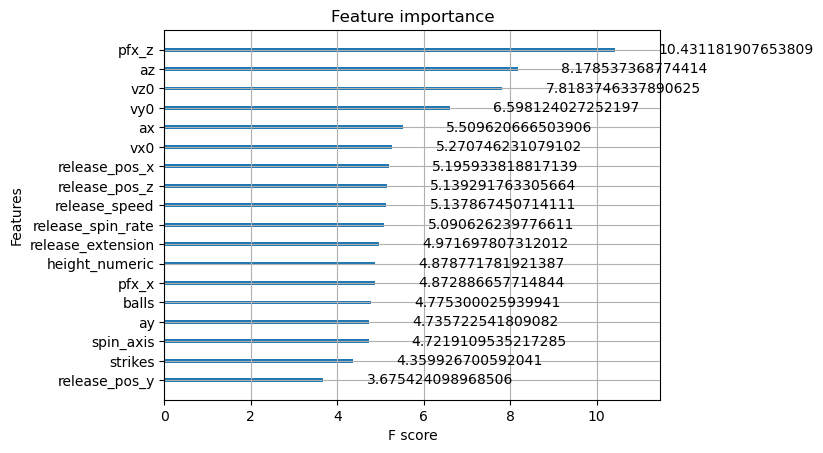

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

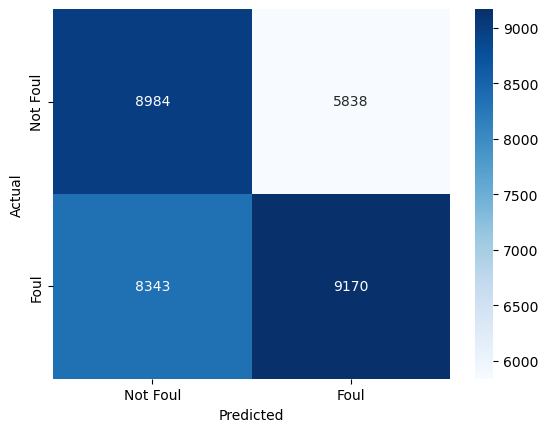

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xfoul'] = y_pred

C:\Users\clayton\AppData\Local\Temp\ipykernel_3744\2390537613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xfoul'] = y_pred


In [ ]:
testing_identifiers.head()

,pitch_id_raw,xfoul
0,663364_455139_617228_4_75_10,0.636266
1,663364_455139_617228_3_75_10,0.586549
2,663364_455139_617228_2_75_10,0.347812
3,663364_455139_617228_1_75_10,0.384995
5,663364_593428_605347_4_72_10,0.731799


In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/foul_2022&3_xfoul.csv")